# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import LSTMAE, FCAE, train_autoencoder

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False
TEST_EXISTING_MODEL = False

In [4]:
model_name = "LSTM_AE"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 1000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [5]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_df.shape

(28511, 5)

In [6]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [7]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [8]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [9]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [10]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [11]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [12]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [13]:
if model_name == "LSTM_AE":
    model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    model = FCAE(verbose=False).to(hyperparameters['device'])

In [14]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

  0%|          | 1/1000 [00:01<29:18,  1.76s/it]

Epoch: 0 
 Train Loss: 0.22552618246426254 
 Val Loss: 0.22602283636505685
**************************************************


  0%|          | 2/1000 [00:03<32:28,  1.95s/it]

Epoch: 1 
 Train Loss: 0.1904628940375958 
 Val Loss: 0.221254201919845
**************************************************


  0%|          | 3/1000 [00:05<29:27,  1.77s/it]

Epoch: 2 
 Train Loss: 0.1891977797258452 
 Val Loss: 0.2203182020549024
**************************************************


  0%|          | 4/1000 [00:06<27:58,  1.69s/it]

Epoch: 3 
 Train Loss: 0.18722715139974216 
 Val Loss: 0.21522003395503828
**************************************************


  0%|          | 5/1000 [00:08<27:30,  1.66s/it]

Epoch: 4 
 Train Loss: 0.18477477965064001 
 Val Loss: 0.20933160336499804
**************************************************


  1%|          | 6/1000 [00:10<26:51,  1.62s/it]

Epoch: 5 
 Train Loss: 0.18027994243577017 
 Val Loss: 0.19785279889455
**************************************************


  1%|          | 7/1000 [00:11<26:28,  1.60s/it]

INFO: Validation loss did not improve in epoch 7
Epoch: 6 
 Train Loss: 0.1683992731893046 
 Val Loss: 0.20339107890142483
**************************************************


  1%|          | 8/1000 [00:13<26:24,  1.60s/it]

INFO: Validation loss did not improve in epoch 8
Epoch: 7 
 Train Loss: 0.15835896096757887 
 Val Loss: 0.20243081283033565
**************************************************


  1%|          | 9/1000 [00:14<25:57,  1.57s/it]

INFO: Validation loss did not improve in epoch 9
Epoch: 8 
 Train Loss: 0.15650816601381062 
 Val Loss: 0.19823988903774303
**************************************************


  1%|          | 10/1000 [00:16<25:44,  1.56s/it]

Epoch: 9 
 Train Loss: 0.15552974576953418 
 Val Loss: 0.19645381693759661
**************************************************


  1%|          | 11/1000 [00:17<25:33,  1.55s/it]

Epoch: 10 
 Train Loss: 0.15469657768708292 
 Val Loss: 0.19513590516669027
**************************************************


  1%|          | 12/1000 [00:19<25:44,  1.56s/it]

Epoch: 11 
 Train Loss: 0.15385109213341502 
 Val Loss: 0.1939724556515726
**************************************************


  1%|▏         | 13/1000 [00:20<25:31,  1.55s/it]

Epoch: 12 
 Train Loss: 0.1529387974952247 
 Val Loss: 0.19307762652300717
**************************************************


  1%|▏         | 14/1000 [00:22<25:22,  1.54s/it]

Epoch: 13 
 Train Loss: 0.15202055828643213 
 Val Loss: 0.1921293390600869
**************************************************


  2%|▏         | 15/1000 [00:24<25:31,  1.55s/it]

Epoch: 14 
 Train Loss: 0.15111914609374705 
 Val Loss: 0.1911439292886284
**************************************************


  2%|▏         | 16/1000 [00:25<25:22,  1.55s/it]

Epoch: 15 
 Train Loss: 0.15031688642618868 
 Val Loss: 0.19018890281741538
**************************************************


  2%|▏         | 17/1000 [00:27<25:16,  1.54s/it]

Epoch: 16 
 Train Loss: 0.14958229264947173 
 Val Loss: 0.1893056600951077
**************************************************


  2%|▏         | 18/1000 [00:28<25:07,  1.54s/it]

Epoch: 17 
 Train Loss: 0.14887212500038857 
 Val Loss: 0.1885691409030657
**************************************************


  2%|▏         | 19/1000 [00:30<25:19,  1.55s/it]

Epoch: 18 
 Train Loss: 0.14821767594879506 
 Val Loss: 0.18777073032400582
**************************************************


  2%|▏         | 20/1000 [00:31<25:13,  1.54s/it]

Epoch: 19 
 Train Loss: 0.14756197678800384 
 Val Loss: 0.18712219177337175
**************************************************


  2%|▏         | 21/1000 [00:33<25:05,  1.54s/it]

Epoch: 20 
 Train Loss: 0.14690826210450658 
 Val Loss: 0.18660241348689863
**************************************************


  2%|▏         | 22/1000 [00:34<25:18,  1.55s/it]

Epoch: 21 
 Train Loss: 0.14611020964292123 
 Val Loss: 0.1848599562484227
**************************************************


  2%|▏         | 23/1000 [00:36<25:18,  1.55s/it]

Epoch: 22 
 Train Loss: 0.14178507538906823 
 Val Loss: 0.18265415845292338
**************************************************


  2%|▏         | 24/1000 [00:37<25:13,  1.55s/it]

INFO: Validation loss did not improve in epoch 24
Epoch: 23 
 Train Loss: 0.14014665342522536 
 Val Loss: 0.18326613909742806
**************************************************


  2%|▎         | 25/1000 [00:39<25:05,  1.54s/it]

Epoch: 24 
 Train Loss: 0.13954348124427848 
 Val Loss: 0.18166443102815177
**************************************************


  3%|▎         | 26/1000 [00:41<25:31,  1.57s/it]

Epoch: 25 
 Train Loss: 0.13882214316855307 
 Val Loss: 0.1805425092075648
**************************************************


  3%|▎         | 27/1000 [00:42<25:22,  1.56s/it]

Epoch: 26 
 Train Loss: 0.13818429964287585 
 Val Loss: 0.17936375921361902
**************************************************


  3%|▎         | 28/1000 [00:44<25:09,  1.55s/it]

Epoch: 27 
 Train Loss: 0.13751302414990407 
 Val Loss: 0.17795257471250683
**************************************************


  3%|▎         | 29/1000 [00:45<25:18,  1.56s/it]

Epoch: 28 
 Train Loss: 0.13688161158294196 
 Val Loss: 0.17633533226640036
**************************************************


  3%|▎         | 30/1000 [00:47<25:18,  1.57s/it]

Epoch: 29 
 Train Loss: 0.13626547194338112 
 Val Loss: 0.1748502179143134
**************************************************


  3%|▎         | 31/1000 [00:48<25:14,  1.56s/it]

Epoch: 30 
 Train Loss: 0.13565548013002307 
 Val Loss: 0.17318292096089782
**************************************************


  3%|▎         | 32/1000 [00:50<25:08,  1.56s/it]

Epoch: 31 
 Train Loss: 0.13504565423576562 
 Val Loss: 0.17149559065197292
**************************************************


  3%|▎         | 33/1000 [00:52<25:21,  1.57s/it]

Epoch: 32 
 Train Loss: 0.13443975452579254 
 Val Loss: 0.16946390823701793
**************************************************


  3%|▎         | 34/1000 [00:53<25:07,  1.56s/it]

Epoch: 33 
 Train Loss: 0.1338437484240298 
 Val Loss: 0.1674545423200961
**************************************************


  4%|▎         | 35/1000 [00:55<24:54,  1.55s/it]

Epoch: 34 
 Train Loss: 0.13331805835223298 
 Val Loss: 0.16559302756625616
**************************************************


  4%|▎         | 36/1000 [00:56<25:09,  1.57s/it]

Epoch: 35 
 Train Loss: 0.13284158999254458 
 Val Loss: 0.1638525037953023
**************************************************


  4%|▎         | 37/1000 [00:58<24:55,  1.55s/it]

Epoch: 36 
 Train Loss: 0.13241228536502844 
 Val Loss: 0.16242840308486745
**************************************************


  4%|▍         | 38/1000 [00:59<24:43,  1.54s/it]

Epoch: 37 
 Train Loss: 0.13202743667476977 
 Val Loss: 0.16112036467268226
**************************************************


  4%|▍         | 39/1000 [01:01<24:56,  1.56s/it]

Epoch: 38 
 Train Loss: 0.13166698351042636 
 Val Loss: 0.15987091544973717
**************************************************


  4%|▍         | 40/1000 [01:02<24:46,  1.55s/it]

Epoch: 39 
 Train Loss: 0.13133017803956382 
 Val Loss: 0.1589618493499381
**************************************************


  4%|▍         | 41/1000 [01:04<24:38,  1.54s/it]

Epoch: 40 
 Train Loss: 0.13101300137407482 
 Val Loss: 0.15796108393186933
**************************************************


  4%|▍         | 42/1000 [01:06<24:48,  1.55s/it]

Epoch: 41 
 Train Loss: 0.13070084944597302 
 Val Loss: 0.1569502464171206
**************************************************


  4%|▍         | 43/1000 [01:07<25:02,  1.57s/it]

Epoch: 42 
 Train Loss: 0.13040632032495394 
 Val Loss: 0.15589130879118202
**************************************************


  4%|▍         | 44/1000 [01:09<24:50,  1.56s/it]

Epoch: 43 
 Train Loss: 0.13011006832248198 
 Val Loss: 0.1549740427832925
**************************************************


  4%|▍         | 45/1000 [01:10<24:38,  1.55s/it]

Epoch: 44 
 Train Loss: 0.12982387103004508 
 Val Loss: 0.1539054886343774
**************************************************


  5%|▍         | 46/1000 [01:12<24:52,  1.56s/it]

Epoch: 45 
 Train Loss: 0.12953671081537618 
 Val Loss: 0.15287300818756724
**************************************************


  5%|▍         | 47/1000 [01:13<24:39,  1.55s/it]

Epoch: 46 
 Train Loss: 0.12924156172872425 
 Val Loss: 0.15187056153342965
**************************************************


  5%|▍         | 48/1000 [01:15<24:30,  1.55s/it]

Epoch: 47 
 Train Loss: 0.12895660759648633 
 Val Loss: 0.1508484606662493
**************************************************


  5%|▍         | 49/1000 [01:16<24:45,  1.56s/it]

Epoch: 48 
 Train Loss: 0.12864940555512822 
 Val Loss: 0.14986998160903373
**************************************************


  5%|▌         | 50/1000 [01:18<24:38,  1.56s/it]

Epoch: 49 
 Train Loss: 0.12828326310967664 
 Val Loss: 0.1484312652034706
**************************************************


  5%|▌         | 51/1000 [01:20<24:30,  1.55s/it]

Epoch: 50 
 Train Loss: 0.12786543417361476 
 Val Loss: 0.14696030804280485
**************************************************


  5%|▌         | 52/1000 [01:21<24:25,  1.55s/it]

Epoch: 51 
 Train Loss: 0.12741751700305337 
 Val Loss: 0.1454926160781571
**************************************************


  5%|▌         | 53/1000 [01:23<24:50,  1.57s/it]

Epoch: 52 
 Train Loss: 0.12696955865053108 
 Val Loss: 0.14444638018527728
**************************************************


  5%|▌         | 54/1000 [01:24<24:41,  1.57s/it]

Epoch: 53 
 Train Loss: 0.1265251227559164 
 Val Loss: 0.1435459582658296
**************************************************


  6%|▌         | 55/1000 [01:26<24:34,  1.56s/it]

Epoch: 54 
 Train Loss: 0.12597805999355263 
 Val Loss: 0.1423465037781201
**************************************************


  6%|▌         | 56/1000 [01:27<24:42,  1.57s/it]

Epoch: 55 
 Train Loss: 0.12539533827699417 
 Val Loss: 0.1415262482641788
**************************************************


  6%|▌         | 57/1000 [01:29<24:29,  1.56s/it]

Epoch: 56 
 Train Loss: 0.12470482448102883 
 Val Loss: 0.1406354217716817
**************************************************


  6%|▌         | 58/1000 [01:30<24:17,  1.55s/it]

Epoch: 57 
 Train Loss: 0.1240511706613558 
 Val Loss: 0.13997227296735462
**************************************************


  6%|▌         | 59/1000 [01:32<24:28,  1.56s/it]

Epoch: 58 
 Train Loss: 0.12342693508820815 
 Val Loss: 0.1394229123599074
**************************************************


  6%|▌         | 60/1000 [01:34<24:15,  1.55s/it]

Epoch: 59 
 Train Loss: 0.12287761915741595 
 Val Loss: 0.13884811228915547
**************************************************


  6%|▌         | 61/1000 [01:35<24:05,  1.54s/it]

Epoch: 60 
 Train Loss: 0.12236588414847266 
 Val Loss: 0.13827341234081247
**************************************************


  6%|▌         | 62/1000 [01:37<24:02,  1.54s/it]

Epoch: 61 
 Train Loss: 0.12188967284426448 
 Val Loss: 0.13777433285552465
**************************************************


  6%|▋         | 63/1000 [01:38<24:11,  1.55s/it]

Epoch: 62 
 Train Loss: 0.1214389221071361 
 Val Loss: 0.13738047808743595
**************************************************


  6%|▋         | 64/1000 [01:40<24:02,  1.54s/it]

Epoch: 63 
 Train Loss: 0.12101507510305454 
 Val Loss: 0.13697546846076344
**************************************************


  6%|▋         | 65/1000 [01:41<23:58,  1.54s/it]

Epoch: 64 
 Train Loss: 0.12063051484849142 
 Val Loss: 0.13662216092428464
**************************************************


  7%|▋         | 66/1000 [01:43<24:13,  1.56s/it]

Epoch: 65 
 Train Loss: 0.12027174119444416 
 Val Loss: 0.13630619352118353
**************************************************


  7%|▋         | 67/1000 [01:44<24:06,  1.55s/it]

Epoch: 66 
 Train Loss: 0.11994862115483465 
 Val Loss: 0.13612913750530628
**************************************************


  7%|▋         | 68/1000 [01:46<24:04,  1.55s/it]

Epoch: 67 
 Train Loss: 0.11967554036397252 
 Val Loss: 0.13595243191786027
**************************************************


  7%|▋         | 69/1000 [01:47<24:14,  1.56s/it]

Epoch: 68 
 Train Loss: 0.1194283563805663 
 Val Loss: 0.13470067435436034
**************************************************


  7%|▋         | 70/1000 [01:49<24:08,  1.56s/it]

Epoch: 69 
 Train Loss: 0.11556976689300062 
 Val Loss: 0.13168721286098609
**************************************************


  7%|▋         | 71/1000 [01:51<23:58,  1.55s/it]

Epoch: 70 
 Train Loss: 0.11524324681280707 
 Val Loss: 0.13150241703129886
**************************************************


  7%|▋         | 72/1000 [01:52<24:29,  1.58s/it]

Epoch: 71 
 Train Loss: 0.11507102846054341 
 Val Loss: 0.13127707196085642
**************************************************


  7%|▋         | 73/1000 [01:54<24:15,  1.57s/it]

Epoch: 72 
 Train Loss: 0.11492613745855917 
 Val Loss: 0.13108581480350387
**************************************************


  7%|▋         | 74/1000 [01:55<24:06,  1.56s/it]

Epoch: 73 
 Train Loss: 0.11479532195132378 
 Val Loss: 0.1309275629647662
**************************************************


  8%|▊         | 75/1000 [01:57<24:18,  1.58s/it]

Epoch: 74 
 Train Loss: 0.11466909241751568 
 Val Loss: 0.13071175564206047
**************************************************


  8%|▊         | 76/1000 [01:58<24:08,  1.57s/it]

Epoch: 75 
 Train Loss: 0.1145357125730033 
 Val Loss: 0.1305839837936873
**************************************************


  8%|▊         | 77/1000 [02:00<23:59,  1.56s/it]

Epoch: 76 
 Train Loss: 0.11439675131883227 
 Val Loss: 0.13039018950435552
**************************************************


  8%|▊         | 78/1000 [02:02<24:10,  1.57s/it]

Epoch: 77 
 Train Loss: 0.11425140251367658 
 Val Loss: 0.13028197718805143
**************************************************


  8%|▊         | 79/1000 [02:03<24:03,  1.57s/it]

Epoch: 78 
 Train Loss: 0.11410228316613368 
 Val Loss: 0.13016832619905472
**************************************************


  8%|▊         | 80/1000 [02:05<23:52,  1.56s/it]

Epoch: 79 
 Train Loss: 0.11395282312955964 
 Val Loss: 0.1300130051173521
**************************************************


  8%|▊         | 81/1000 [02:06<24:06,  1.57s/it]

Epoch: 80 
 Train Loss: 0.11379830966093597 
 Val Loss: 0.12989601986796667
**************************************************


  8%|▊         | 82/1000 [02:08<23:54,  1.56s/it]

Epoch: 81 
 Train Loss: 0.10612298076943628 
 Val Loss: 0.11516541845343087
**************************************************


  8%|▊         | 83/1000 [02:09<23:49,  1.56s/it]

Epoch: 82 
 Train Loss: 0.10044098073854353 
 Val Loss: 0.11438175927052337
**************************************************


  8%|▊         | 84/1000 [02:11<23:49,  1.56s/it]

Epoch: 83 
 Train Loss: 0.10009024366945404 
 Val Loss: 0.11399503487549471
**************************************************


  8%|▊         | 85/1000 [02:13<24:03,  1.58s/it]

Epoch: 84 
 Train Loss: 0.09977274380237658 
 Val Loss: 0.11379599495885077
**************************************************


  9%|▊         | 86/1000 [02:14<23:55,  1.57s/it]

Epoch: 85 
 Train Loss: 0.09947693959756286 
 Val Loss: 0.11364837953548752
**************************************************


  9%|▊         | 87/1000 [02:16<23:51,  1.57s/it]

Epoch: 86 
 Train Loss: 0.09919118654468785 
 Val Loss: 0.11335999183775333
**************************************************


  9%|▉         | 88/1000 [02:17<24:06,  1.59s/it]

Epoch: 87 
 Train Loss: 0.09890336863080047 
 Val Loss: 0.1133206392104706
**************************************************


  9%|▉         | 89/1000 [02:19<23:58,  1.58s/it]

Epoch: 88 
 Train Loss: 0.09862932417055835 
 Val Loss: 0.1130667281954476
**************************************************


  9%|▉         | 90/1000 [02:20<23:53,  1.58s/it]

Epoch: 89 
 Train Loss: 0.09836659677128136 
 Val Loss: 0.11289661369296942
**************************************************


  9%|▉         | 91/1000 [02:22<24:10,  1.60s/it]

Epoch: 90 
 Train Loss: 0.09813044160123795 
 Val Loss: 0.11262835997543978
**************************************************


  9%|▉         | 92/1000 [02:24<24:11,  1.60s/it]

Epoch: 91 
 Train Loss: 0.0979181832906909 
 Val Loss: 0.11238116770982742
**************************************************


  9%|▉         | 93/1000 [02:25<24:06,  1.59s/it]

Epoch: 92 
 Train Loss: 0.09772357958542682 
 Val Loss: 0.1120283216070593
**************************************************


  9%|▉         | 94/1000 [02:27<24:18,  1.61s/it]

Epoch: 93 
 Train Loss: 0.0896768005405452 
 Val Loss: 0.10138943799760904
**************************************************


 10%|▉         | 95/1000 [02:29<24:07,  1.60s/it]

Epoch: 94 
 Train Loss: 0.08822194035432783 
 Val Loss: 0.1003296458989047
**************************************************


 10%|▉         | 96/1000 [02:30<23:57,  1.59s/it]

Epoch: 95 
 Train Loss: 0.08788084305645205 
 Val Loss: 0.09962681471631768
**************************************************


 10%|▉         | 97/1000 [02:32<24:09,  1.61s/it]

Epoch: 96 
 Train Loss: 0.08761585225856655 
 Val Loss: 0.0990183987141995
**************************************************


 10%|▉         | 98/1000 [02:33<24:01,  1.60s/it]

Epoch: 97 
 Train Loss: 0.08738972049671503 
 Val Loss: 0.09847938085205099
**************************************************


 10%|▉         | 99/1000 [02:35<23:54,  1.59s/it]

Epoch: 98 
 Train Loss: 0.08719867611040072 
 Val Loss: 0.09806008662065763
**************************************************


 10%|█         | 100/1000 [02:37<24:09,  1.61s/it]

Epoch: 99 
 Train Loss: 0.08702932691089234 
 Val Loss: 0.09758670435527737
**************************************************


 10%|█         | 101/1000 [02:38<24:06,  1.61s/it]

Epoch: 100 
 Train Loss: 0.08687714189499993 
 Val Loss: 0.09719559094041921
**************************************************


 10%|█         | 102/1000 [02:40<24:03,  1.61s/it]

Epoch: 101 
 Train Loss: 0.08674057716239886 
 Val Loss: 0.09687026816137721
**************************************************


 10%|█         | 103/1000 [02:41<24:18,  1.63s/it]

Epoch: 102 
 Train Loss: 0.08660888063184509 
 Val Loss: 0.09663851760076674
**************************************************


 10%|█         | 104/1000 [02:43<24:22,  1.63s/it]

Epoch: 103 
 Train Loss: 0.08648978850868273 
 Val Loss: 0.09640709905142195
**************************************************


 10%|█         | 105/1000 [02:45<24:10,  1.62s/it]

Epoch: 104 
 Train Loss: 0.08637809944646054 
 Val Loss: 0.09621504514237468
**************************************************


 11%|█         | 106/1000 [02:46<24:07,  1.62s/it]

Epoch: 105 
 Train Loss: 0.08627323407632773 
 Val Loss: 0.09605460835809118
**************************************************


 11%|█         | 107/1000 [02:48<24:21,  1.64s/it]

Epoch: 106 
 Train Loss: 0.08617152117433087 
 Val Loss: 0.09588049172183101
**************************************************


 11%|█         | 108/1000 [02:50<24:08,  1.62s/it]

Epoch: 107 
 Train Loss: 0.08607620201471979 
 Val Loss: 0.09575711069314667
**************************************************


 11%|█         | 109/1000 [02:51<24:01,  1.62s/it]

Epoch: 108 
 Train Loss: 0.08597778745758416 
 Val Loss: 0.09550967712080881
**************************************************


 11%|█         | 110/1000 [02:53<24:12,  1.63s/it]

Epoch: 109 
 Train Loss: 0.08588635964844203 
 Val Loss: 0.09537068168433864
**************************************************


 11%|█         | 111/1000 [02:54<24:05,  1.63s/it]

Epoch: 110 
 Train Loss: 0.08579307569381565 
 Val Loss: 0.09515368766831549
**************************************************


 11%|█         | 112/1000 [02:56<24:00,  1.62s/it]

Epoch: 111 
 Train Loss: 0.08570042801668233 
 Val Loss: 0.09499287651328558
**************************************************


 11%|█▏        | 113/1000 [02:58<24:13,  1.64s/it]

Epoch: 112 
 Train Loss: 0.08561025458540857 
 Val Loss: 0.09485240845700328
**************************************************


 11%|█▏        | 114/1000 [02:59<24:02,  1.63s/it]

Epoch: 113 
 Train Loss: 0.08552398454256847 
 Val Loss: 0.0946878001428722
**************************************************


 12%|█▏        | 115/1000 [03:01<23:54,  1.62s/it]

Epoch: 114 
 Train Loss: 0.08543620556383949 
 Val Loss: 0.09456330006209653
**************************************************


 12%|█▏        | 116/1000 [03:03<24:16,  1.65s/it]

Epoch: 115 
 Train Loss: 0.08535367575948236 
 Val Loss: 0.09444479949856072
**************************************************


 12%|█▏        | 117/1000 [03:04<24:05,  1.64s/it]

Epoch: 116 
 Train Loss: 0.08526755796763706 
 Val Loss: 0.09432887679405427
**************************************************


 12%|█▏        | 118/1000 [03:06<23:58,  1.63s/it]

Epoch: 117 
 Train Loss: 0.08382784660388343 
 Val Loss: 0.08498480706737283
**************************************************


 12%|█▏        | 119/1000 [03:08<24:13,  1.65s/it]

Epoch: 118 
 Train Loss: 0.07629700208299625 
 Val Loss: 0.08368957674737727
**************************************************


 12%|█▏        | 120/1000 [03:09<24:03,  1.64s/it]

Epoch: 119 
 Train Loss: 0.07584947379512338 
 Val Loss: 0.08294731688298536
**************************************************


 12%|█▏        | 121/1000 [03:11<23:55,  1.63s/it]

Epoch: 120 
 Train Loss: 0.07560261870834971 
 Val Loss: 0.08233427105659849
**************************************************


 12%|█▏        | 122/1000 [03:12<24:06,  1.65s/it]

Epoch: 121 
 Train Loss: 0.07542872376123451 
 Val Loss: 0.0818531500656953
**************************************************


 12%|█▏        | 123/1000 [03:14<23:54,  1.64s/it]

Epoch: 122 
 Train Loss: 0.07528769772964808 
 Val Loss: 0.08145160198713956
**************************************************


 12%|█▏        | 124/1000 [03:16<23:59,  1.64s/it]

Epoch: 123 
 Train Loss: 0.07516721699799594 
 Val Loss: 0.08117503517966591
**************************************************


 12%|█▎        | 125/1000 [03:17<24:20,  1.67s/it]

Epoch: 124 
 Train Loss: 0.075058870336242 
 Val Loss: 0.0809275744838661
**************************************************


 13%|█▎        | 126/1000 [03:19<24:09,  1.66s/it]

Epoch: 125 
 Train Loss: 0.07495505802155711 
 Val Loss: 0.08075473926375422
**************************************************


 13%|█▎        | 127/1000 [03:21<23:56,  1.65s/it]

Epoch: 126 
 Train Loss: 0.07485506680975622 
 Val Loss: 0.0805707157830174
**************************************************


 13%|█▎        | 128/1000 [03:22<24:03,  1.65s/it]

Epoch: 127 
 Train Loss: 0.0747587151464916 
 Val Loss: 0.08033841689316075
**************************************************


 13%|█▎        | 129/1000 [03:24<23:51,  1.64s/it]

Epoch: 128 
 Train Loss: 0.07465684786961423 
 Val Loss: 0.0801805854262261
**************************************************


 13%|█▎        | 130/1000 [03:26<23:48,  1.64s/it]

Epoch: 129 
 Train Loss: 0.0745575713753951 
 Val Loss: 0.08000074573949481
**************************************************


 13%|█▎        | 131/1000 [03:27<24:07,  1.67s/it]

Epoch: 130 
 Train Loss: 0.07445624258060944 
 Val Loss: 0.0798652751810765
**************************************************


 13%|█▎        | 132/1000 [03:29<23:55,  1.65s/it]

Epoch: 131 
 Train Loss: 0.07435159963852142 
 Val Loss: 0.07972256039802948
**************************************************


 13%|█▎        | 133/1000 [03:31<23:46,  1.65s/it]

Epoch: 132 
 Train Loss: 0.07424873356063436 
 Val Loss: 0.07956430675943246
**************************************************


 13%|█▎        | 134/1000 [03:32<24:03,  1.67s/it]

Epoch: 133 
 Train Loss: 0.07414583593272561 
 Val Loss: 0.07941996142937896
**************************************************


 14%|█▎        | 135/1000 [03:34<23:51,  1.66s/it]

Epoch: 134 
 Train Loss: 0.07403675610196958 
 Val Loss: 0.0793078833918893
**************************************************


 14%|█▎        | 136/1000 [03:36<23:46,  1.65s/it]

Epoch: 135 
 Train Loss: 0.073921376593714 
 Val Loss: 0.07912138380696264
**************************************************


 14%|█▎        | 137/1000 [03:37<23:58,  1.67s/it]

Epoch: 136 
 Train Loss: 0.07380388683128741 
 Val Loss: 0.07898338532514787
**************************************************


 14%|█▍        | 138/1000 [03:39<23:48,  1.66s/it]

Epoch: 137 
 Train Loss: 0.07368089483598923 
 Val Loss: 0.07883048501242412
**************************************************


 14%|█▍        | 139/1000 [03:41<23:42,  1.65s/it]

Epoch: 138 
 Train Loss: 0.07355678610002092 
 Val Loss: 0.07867517263701793
**************************************************


 14%|█▍        | 140/1000 [03:42<23:58,  1.67s/it]

Epoch: 139 
 Train Loss: 0.07342567362497347 
 Val Loss: 0.07855619578046745
**************************************************


 14%|█▍        | 141/1000 [03:44<23:47,  1.66s/it]

Epoch: 140 
 Train Loss: 0.07329562165856696 
 Val Loss: 0.07839901305818825
**************************************************


 14%|█▍        | 142/1000 [03:46<23:39,  1.65s/it]

Epoch: 141 
 Train Loss: 0.07315715077642722 
 Val Loss: 0.078298663280988
**************************************************


 14%|█▍        | 143/1000 [03:47<23:51,  1.67s/it]

Epoch: 142 
 Train Loss: 0.0730188345068969 
 Val Loss: 0.07815869805518161
**************************************************


 14%|█▍        | 144/1000 [03:49<23:43,  1.66s/it]

Epoch: 143 
 Train Loss: 0.07287026640304677 
 Val Loss: 0.0780414306045918
**************************************************


 14%|█▍        | 145/1000 [03:51<23:40,  1.66s/it]

Epoch: 144 
 Train Loss: 0.07271785005864388 
 Val Loss: 0.07790896095586626
**************************************************


 15%|█▍        | 146/1000 [03:52<23:52,  1.68s/it]

Epoch: 145 
 Train Loss: 0.07256524903806864 
 Val Loss: 0.07778900079010578
**************************************************


 15%|█▍        | 147/1000 [03:54<23:39,  1.66s/it]

Epoch: 146 
 Train Loss: 0.0724149643277637 
 Val Loss: 0.07767059762826127
**************************************************


 15%|█▍        | 148/1000 [03:56<23:33,  1.66s/it]

Epoch: 147 
 Train Loss: 0.07226859884229482 
 Val Loss: 0.07761791637271978
**************************************************


 15%|█▍        | 149/1000 [03:57<23:45,  1.67s/it]

Epoch: 148 
 Train Loss: 0.07212495350841887 
 Val Loss: 0.07750092584932788
**************************************************


 15%|█▌        | 150/1000 [03:59<23:37,  1.67s/it]

Epoch: 149 
 Train Loss: 0.07197837087196438 
 Val Loss: 0.0774366038150332
**************************************************


 15%|█▌        | 151/1000 [04:01<23:55,  1.69s/it]

Epoch: 150 
 Train Loss: 0.07182935064692483 
 Val Loss: 0.07733192131592986
**************************************************


 15%|█▌        | 152/1000 [04:02<24:01,  1.70s/it]

Epoch: 151 
 Train Loss: 0.07168291519862321 
 Val Loss: 0.07722094018807572
**************************************************


 15%|█▌        | 153/1000 [04:04<23:45,  1.68s/it]

Epoch: 152 
 Train Loss: 0.07154434077117754 
 Val Loss: 0.07715630966625857
**************************************************


 15%|█▌        | 154/1000 [04:06<23:31,  1.67s/it]

Epoch: 153 
 Train Loss: 0.0714049980404877 
 Val Loss: 0.07702680513932464
**************************************************


 16%|█▌        | 155/1000 [04:07<23:39,  1.68s/it]

Epoch: 154 
 Train Loss: 0.07125607904355037 
 Val Loss: 0.07690720197357488
**************************************************


 16%|█▌        | 156/1000 [04:09<23:30,  1.67s/it]

Epoch: 155 
 Train Loss: 0.0711078527233293 
 Val Loss: 0.07681996521822522
**************************************************


 16%|█▌        | 157/1000 [04:11<23:29,  1.67s/it]

Epoch: 156 
 Train Loss: 0.07096061407788272 
 Val Loss: 0.0766681603501352
**************************************************


 16%|█▌        | 158/1000 [04:12<23:40,  1.69s/it]

Epoch: 157 
 Train Loss: 0.07079786682948157 
 Val Loss: 0.07653633354420072
**************************************************


 16%|█▌        | 159/1000 [04:14<23:29,  1.68s/it]

Epoch: 158 
 Train Loss: 0.07063757764308767 
 Val Loss: 0.07636481582113866
**************************************************


 16%|█▌        | 160/1000 [04:16<23:17,  1.66s/it]

Epoch: 159 
 Train Loss: 0.07046636042209946 
 Val Loss: 0.07620106767235177
**************************************************


 16%|█▌        | 161/1000 [04:17<23:33,  1.68s/it]

Epoch: 160 
 Train Loss: 0.07028200663626194 
 Val Loss: 0.07609794339102306
**************************************************


 16%|█▌        | 162/1000 [04:19<23:22,  1.67s/it]

Epoch: 161 
 Train Loss: 0.0700798430996013 
 Val Loss: 0.07589629623159934
**************************************************


 16%|█▋        | 163/1000 [04:21<23:11,  1.66s/it]

Epoch: 162 
 Train Loss: 0.06987551632134811 
 Val Loss: 0.0756653816428747
**************************************************


 16%|█▋        | 164/1000 [04:22<23:24,  1.68s/it]

Epoch: 163 
 Train Loss: 0.06963810092164792 
 Val Loss: 0.07546463252955608
**************************************************


 16%|█▋        | 165/1000 [04:24<23:17,  1.67s/it]

Epoch: 164 
 Train Loss: 0.06938659052297912 
 Val Loss: 0.07529032259677233
**************************************************


 17%|█▋        | 166/1000 [04:26<23:07,  1.66s/it]

Epoch: 165 
 Train Loss: 0.06913623364503806 
 Val Loss: 0.07502907305286172
**************************************************


 17%|█▋        | 167/1000 [04:28<23:25,  1.69s/it]

Epoch: 166 
 Train Loss: 0.06887569695418547 
 Val Loss: 0.07484160660860244
**************************************************


 17%|█▋        | 168/1000 [04:29<23:19,  1.68s/it]

Epoch: 167 
 Train Loss: 0.06861744445146467 
 Val Loss: 0.0745846556729815
**************************************************


 17%|█▋        | 169/1000 [04:31<23:06,  1.67s/it]

Epoch: 168 
 Train Loss: 0.06836105907416862 
 Val Loss: 0.07432069939174009
**************************************************


 17%|█▋        | 170/1000 [04:33<23:22,  1.69s/it]

Epoch: 169 
 Train Loss: 0.06812494522715601 
 Val Loss: 0.0741622746827897
**************************************************


 17%|█▋        | 171/1000 [04:34<23:13,  1.68s/it]

Epoch: 170 
 Train Loss: 0.06792078409631322 
 Val Loss: 0.07391729193289628
**************************************************


 17%|█▋        | 172/1000 [04:36<22:59,  1.67s/it]

Epoch: 171 
 Train Loss: 0.06771592130469156 
 Val Loss: 0.07370899646972003
**************************************************


 17%|█▋        | 173/1000 [04:38<23:08,  1.68s/it]

Epoch: 172 
 Train Loss: 0.0675481093621605 
 Val Loss: 0.07354263245557131
**************************************************


 17%|█▋        | 174/1000 [04:39<22:58,  1.67s/it]

Epoch: 173 
 Train Loss: 0.06740332666267268 
 Val Loss: 0.073364838622929
**************************************************


 18%|█▊        | 175/1000 [04:41<22:55,  1.67s/it]

Epoch: 174 
 Train Loss: 0.06726969851162624 
 Val Loss: 0.07317898439222507
**************************************************


 18%|█▊        | 176/1000 [04:43<23:09,  1.69s/it]

Epoch: 175 
 Train Loss: 0.0671455022261111 
 Val Loss: 0.07298525958583596
**************************************************


 18%|█▊        | 177/1000 [04:44<22:56,  1.67s/it]

Epoch: 176 
 Train Loss: 0.06702750927780403 
 Val Loss: 0.07276773105344075
**************************************************


 18%|█▊        | 178/1000 [04:46<22:48,  1.67s/it]

Epoch: 177 
 Train Loss: 0.06691708013174995 
 Val Loss: 0.07258314831873004
**************************************************


 18%|█▊        | 179/1000 [04:48<23:00,  1.68s/it]

Epoch: 178 
 Train Loss: 0.06681122981158162 
 Val Loss: 0.07243695114268346
**************************************************


 18%|█▊        | 180/1000 [04:49<22:52,  1.67s/it]

Epoch: 179 
 Train Loss: 0.06670905854213371 
 Val Loss: 0.07230032980442047
**************************************************


 18%|█▊        | 181/1000 [04:51<22:45,  1.67s/it]

Epoch: 180 
 Train Loss: 0.06661211660583759 
 Val Loss: 0.07216908807834882
**************************************************


 18%|█▊        | 182/1000 [04:53<22:57,  1.68s/it]

Epoch: 181 
 Train Loss: 0.0665173910135014 
 Val Loss: 0.07204119049096375
**************************************************


 18%|█▊        | 183/1000 [04:54<22:48,  1.68s/it]

Epoch: 182 
 Train Loss: 0.06642377121846857 
 Val Loss: 0.07190958623973172
**************************************************


 18%|█▊        | 184/1000 [04:56<22:43,  1.67s/it]

Epoch: 183 
 Train Loss: 0.0663319580141993 
 Val Loss: 0.07179137252354889
**************************************************


 18%|█▊        | 185/1000 [04:58<22:57,  1.69s/it]

Epoch: 184 
 Train Loss: 0.06624426421556533 
 Val Loss: 0.07164297395207908
**************************************************


 19%|█▊        | 186/1000 [04:59<22:49,  1.68s/it]

Epoch: 185 
 Train Loss: 0.0661548506703651 
 Val Loss: 0.07150647245096357
**************************************************


 19%|█▊        | 187/1000 [05:01<22:41,  1.67s/it]

Epoch: 186 
 Train Loss: 0.0660702802533438 
 Val Loss: 0.0713635634505347
**************************************************


 19%|█▉        | 188/1000 [05:03<22:53,  1.69s/it]

Epoch: 187 
 Train Loss: 0.06599044002237277 
 Val Loss: 0.07126765999566304
**************************************************


 19%|█▉        | 189/1000 [05:04<22:45,  1.68s/it]

Epoch: 188 
 Train Loss: 0.06590625532180447 
 Val Loss: 0.07115862870149398
**************************************************


 19%|█▉        | 190/1000 [05:06<22:37,  1.68s/it]

Epoch: 189 
 Train Loss: 0.06582241123973237 
 Val Loss: 0.07102946154354664
**************************************************


 19%|█▉        | 191/1000 [05:08<22:57,  1.70s/it]

Epoch: 190 
 Train Loss: 0.06573839959274419 
 Val Loss: 0.07096098622914111
**************************************************


 19%|█▉        | 192/1000 [05:09<22:45,  1.69s/it]

Epoch: 191 
 Train Loss: 0.06565898230239268 
 Val Loss: 0.07094154393907344
**************************************************


 19%|█▉        | 193/1000 [05:11<22:35,  1.68s/it]

Epoch: 192 
 Train Loss: 0.06558171791895744 
 Val Loss: 0.0708764468351107
**************************************************


 19%|█▉        | 194/1000 [05:13<22:43,  1.69s/it]

Epoch: 193 
 Train Loss: 0.06550751945988743 
 Val Loss: 0.07079248795850893
**************************************************


 20%|█▉        | 195/1000 [05:15<22:34,  1.68s/it]

Epoch: 194 
 Train Loss: 0.06543613109492069 
 Val Loss: 0.07071306100219824
**************************************************


 20%|█▉        | 196/1000 [05:16<22:25,  1.67s/it]

Epoch: 195 
 Train Loss: 0.06536719126713059 
 Val Loss: 0.07063959501265141
**************************************************


 20%|█▉        | 197/1000 [05:18<22:33,  1.69s/it]

Epoch: 196 
 Train Loss: 0.06530107957210397 
 Val Loss: 0.07054189366571019
**************************************************


 20%|█▉        | 198/1000 [05:20<22:22,  1.67s/it]

Epoch: 197 
 Train Loss: 0.0652347488634466 
 Val Loss: 0.07047246132841271
**************************************************


 20%|█▉        | 199/1000 [05:21<22:19,  1.67s/it]

Epoch: 198 
 Train Loss: 0.06517062131916324 
 Val Loss: 0.07041402182049966
**************************************************


 20%|██        | 200/1000 [05:23<22:31,  1.69s/it]

Epoch: 199 
 Train Loss: 0.06511021977314023 
 Val Loss: 0.07031462563390142
**************************************************


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_generation/AE/AE.py:181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
 20%|██        | 201/1000 [05:25<22:24,  1.68s/it]

Epoch: 200 
 Train Loss: 0.06505095287060253 
 Val Loss: 0.0702291741716058
**************************************************


 20%|██        | 202/1000 [05:26<22:19,  1.68s/it]

Epoch: 201 
 Train Loss: 0.06499343467314649 
 Val Loss: 0.0701689196938879
**************************************************


 20%|██        | 203/1000 [05:28<22:30,  1.69s/it]

Epoch: 202 
 Train Loss: 0.06493818393136475 
 Val Loss: 0.07010355922445823
**************************************************


 20%|██        | 204/1000 [05:30<22:20,  1.68s/it]

Epoch: 203 
 Train Loss: 0.06488505314622822 
 Val Loss: 0.07007549209206292
**************************************************


 20%|██        | 205/1000 [05:31<22:21,  1.69s/it]

Epoch: 204 
 Train Loss: 0.06483034575606211 
 Val Loss: 0.07002668999386637
**************************************************


 21%|██        | 206/1000 [05:33<22:33,  1.70s/it]

Epoch: 205 
 Train Loss: 0.06478507202876232 
 Val Loss: 0.06998331371820375
**************************************************


 21%|██        | 207/1000 [05:35<22:29,  1.70s/it]

Epoch: 206 
 Train Loss: 0.06473560696062834 
 Val Loss: 0.06996293579427044
**************************************************


 21%|██        | 208/1000 [05:36<22:20,  1.69s/it]

Epoch: 207 
 Train Loss: 0.06468431925633596 
 Val Loss: 0.06987323540817486
**************************************************


 21%|██        | 209/1000 [05:38<22:29,  1.71s/it]

Epoch: 208 
 Train Loss: 0.06463858056003632 
 Val Loss: 0.06982827898156777
**************************************************


 21%|██        | 210/1000 [05:40<22:22,  1.70s/it]

Epoch: 209 
 Train Loss: 0.06459247169109665 
 Val Loss: 0.06977957520592079
**************************************************


 21%|██        | 211/1000 [05:42<22:14,  1.69s/it]

Epoch: 210 
 Train Loss: 0.06454199568732925 
 Val Loss: 0.06973298224672843
**************************************************


 21%|██        | 212/1000 [05:43<22:26,  1.71s/it]

Epoch: 211 
 Train Loss: 0.06449510178530032 
 Val Loss: 0.06967676259326132
**************************************************


 21%|██▏       | 213/1000 [05:45<22:17,  1.70s/it]

Epoch: 212 
 Train Loss: 0.06444553462958269 
 Val Loss: 0.06967564295516925
**************************************************


 21%|██▏       | 214/1000 [05:47<22:07,  1.69s/it]

Epoch: 213 
 Train Loss: 0.06440236439293598 
 Val Loss: 0.06961672903781527
**************************************************


 22%|██▏       | 215/1000 [05:48<22:15,  1.70s/it]

Epoch: 214 
 Train Loss: 0.06436444217859026 
 Val Loss: 0.0695410141867868
**************************************************


 22%|██▏       | 216/1000 [05:50<22:06,  1.69s/it]

Epoch: 215 
 Train Loss: 0.064318948627814 
 Val Loss: 0.0694585552627451
**************************************************


 22%|██▏       | 217/1000 [05:52<21:58,  1.68s/it]

Epoch: 216 
 Train Loss: 0.06427657879042592 
 Val Loss: 0.06944564127185371
**************************************************


 22%|██▏       | 218/1000 [05:53<22:11,  1.70s/it]

Epoch: 217 
 Train Loss: 0.06423087528845371 
 Val Loss: 0.06942767947075072
**************************************************


 22%|██▏       | 219/1000 [05:55<22:04,  1.70s/it]

Epoch: 218 
 Train Loss: 0.06419269825484693 
 Val Loss: 0.06938395201322738
**************************************************


 22%|██▏       | 220/1000 [05:57<22:01,  1.69s/it]

Epoch: 219 
 Train Loss: 0.06415248133743712 
 Val Loss: 0.06932386567585924
**************************************************


 22%|██▏       | 221/1000 [05:59<22:13,  1.71s/it]

Epoch: 220 
 Train Loss: 0.06411231423076373 
 Val Loss: 0.06927425828710031
**************************************************


 22%|██▏       | 222/1000 [06:00<22:05,  1.70s/it]

Epoch: 221 
 Train Loss: 0.0640708266810983 
 Val Loss: 0.06923277345433664
**************************************************


 22%|██▏       | 223/1000 [06:02<21:56,  1.69s/it]

Epoch: 222 
 Train Loss: 0.06403411138504952 
 Val Loss: 0.06917755138338282
**************************************************


 22%|██▏       | 224/1000 [06:04<22:08,  1.71s/it]

Epoch: 223 
 Train Loss: 0.06399613055616074 
 Val Loss: 0.0691249921415629
**************************************************


 22%|██▎       | 225/1000 [06:05<22:01,  1.71s/it]

Epoch: 224 
 Train Loss: 0.06395773043095815 
 Val Loss: 0.06906550955236627
**************************************************


 23%|██▎       | 226/1000 [06:07<22:18,  1.73s/it]

Epoch: 225 
 Train Loss: 0.0639221521504589 
 Val Loss: 0.06903112148133557
**************************************************


 23%|██▎       | 227/1000 [06:09<22:18,  1.73s/it]

Epoch: 226 
 Train Loss: 0.06388800477851993 
 Val Loss: 0.06893535870849417
**************************************************


 23%|██▎       | 228/1000 [06:11<22:04,  1.72s/it]

Epoch: 227 
 Train Loss: 0.06385155492638556 
 Val Loss: 0.06888319853316532
**************************************************


 23%|██▎       | 229/1000 [06:12<21:53,  1.70s/it]

Epoch: 228 
 Train Loss: 0.06381806766491535 
 Val Loss: 0.06888307697987289
**************************************************


 23%|██▎       | 230/1000 [06:14<21:59,  1.71s/it]

Epoch: 229 
 Train Loss: 0.06379114301433737 
 Val Loss: 0.06880239560530427
**************************************************


 23%|██▎       | 231/1000 [06:16<21:49,  1.70s/it]

Epoch: 230 
 Train Loss: 0.06375136529454677 
 Val Loss: 0.06878338570005438
**************************************************


 23%|██▎       | 232/1000 [06:17<21:38,  1.69s/it]

Epoch: 231 
 Train Loss: 0.06371073809623468 
 Val Loss: 0.06871607075079103
**************************************************


 23%|██▎       | 233/1000 [06:19<21:50,  1.71s/it]

Epoch: 232 
 Train Loss: 0.06368466972949462 
 Val Loss: 0.06867019961891549
**************************************************


 23%|██▎       | 234/1000 [06:21<21:39,  1.70s/it]

Epoch: 233 
 Train Loss: 0.06364594727002221 
 Val Loss: 0.06861486051524623
**************************************************


 24%|██▎       | 235/1000 [06:22<21:31,  1.69s/it]

INFO: Validation loss did not improve in epoch 235
Epoch: 234 
 Train Loss: 0.06361417155477726 
 Val Loss: 0.06862593676601902
**************************************************


 24%|██▎       | 236/1000 [06:24<21:40,  1.70s/it]

Epoch: 235 
 Train Loss: 0.06358797268793091 
 Val Loss: 0.06853848725055041
**************************************************


 24%|██▎       | 237/1000 [06:26<21:31,  1.69s/it]

Epoch: 236 
 Train Loss: 0.06355408432293908 
 Val Loss: 0.06846259124158474
**************************************************


 24%|██▍       | 238/1000 [06:28<21:24,  1.69s/it]

Epoch: 237 
 Train Loss: 0.06352007206722697 
 Val Loss: 0.06841325713844781
**************************************************


 24%|██▍       | 239/1000 [06:29<21:37,  1.70s/it]

Epoch: 238 
 Train Loss: 0.06348943834677652 
 Val Loss: 0.06837086258142182
**************************************************


 24%|██▍       | 240/1000 [06:31<21:27,  1.69s/it]

Epoch: 239 
 Train Loss: 0.0634595048450571 
 Val Loss: 0.06832791458857193
**************************************************


 24%|██▍       | 241/1000 [06:33<21:22,  1.69s/it]

Epoch: 240 
 Train Loss: 0.06342559012873059 
 Val Loss: 0.06832062687431828
**************************************************


 24%|██▍       | 242/1000 [06:34<21:34,  1.71s/it]

Epoch: 241 
 Train Loss: 0.0633919217126107 
 Val Loss: 0.06831945575187716
**************************************************


 24%|██▍       | 243/1000 [06:36<21:28,  1.70s/it]

Epoch: 242 
 Train Loss: 0.06335940096543012 
 Val Loss: 0.06831662503353665
**************************************************


 24%|██▍       | 244/1000 [06:38<21:19,  1.69s/it]

Epoch: 243 
 Train Loss: 0.06207995008557073 
 Val Loss: 0.0656258762301354
**************************************************


 24%|██▍       | 245/1000 [06:39<21:26,  1.70s/it]

Epoch: 244 
 Train Loss: 0.059110076962166885 
 Val Loss: 0.0648098522064726
**************************************************


 25%|██▍       | 246/1000 [06:41<21:18,  1.70s/it]

Epoch: 245 
 Train Loss: 0.05853130071989534 
 Val Loss: 0.0644486185288831
**************************************************


 25%|██▍       | 247/1000 [06:43<21:15,  1.69s/it]

Epoch: 246 
 Train Loss: 0.05834384274578864 
 Val Loss: 0.06438389638166749
**************************************************


 25%|██▍       | 248/1000 [06:45<21:24,  1.71s/it]

Epoch: 247 
 Train Loss: 0.058236948278475274 
 Val Loss: 0.0643176312108388
**************************************************


 25%|██▍       | 249/1000 [06:46<21:22,  1.71s/it]

Epoch: 248 
 Train Loss: 0.05816488923847174 
 Val Loss: 0.06423543636383636
**************************************************


 25%|██▌       | 250/1000 [06:48<21:15,  1.70s/it]

Epoch: 249 
 Train Loss: 0.05811485529552001 
 Val Loss: 0.06420359161964963
**************************************************


 25%|██▌       | 251/1000 [06:50<21:23,  1.71s/it]

Epoch: 250 
 Train Loss: 0.05807194995940735 
 Val Loss: 0.06414014940265189
**************************************************


 25%|██▌       | 252/1000 [06:51<21:12,  1.70s/it]

Epoch: 251 
 Train Loss: 0.058038927003385976 
 Val Loss: 0.06407847529632991
**************************************************


 25%|██▌       | 253/1000 [06:53<21:04,  1.69s/it]

Epoch: 252 
 Train Loss: 0.05800093833205576 
 Val Loss: 0.06399824007759604
**************************************************


 25%|██▌       | 254/1000 [06:55<21:10,  1.70s/it]

Epoch: 253 
 Train Loss: 0.057965424483926734 
 Val Loss: 0.0639787046761995
**************************************************


 26%|██▌       | 255/1000 [06:56<21:04,  1.70s/it]

Epoch: 254 
 Train Loss: 0.05793288242212937 
 Val Loss: 0.06390101519109828
**************************************************


 26%|██▌       | 256/1000 [06:58<20:55,  1.69s/it]

Epoch: 255 
 Train Loss: 0.057899426958859385 
 Val Loss: 0.063888697644298
**************************************************


 26%|██▌       | 257/1000 [07:00<20:47,  1.68s/it]

Epoch: 256 
 Train Loss: 0.05786846433393918 
 Val Loss: 0.06383325326978491
**************************************************


 26%|██▌       | 258/1000 [07:01<20:53,  1.69s/it]

Epoch: 257 
 Train Loss: 0.0578394957503296 
 Val Loss: 0.06380642075719459
**************************************************


 26%|██▌       | 259/1000 [07:03<20:47,  1.68s/it]

Epoch: 258 
 Train Loss: 0.05781341829503067 
 Val Loss: 0.0637283069447855
**************************************************


 26%|██▌       | 260/1000 [07:05<20:45,  1.68s/it]

Epoch: 259 
 Train Loss: 0.05778174824375257 
 Val Loss: 0.06368453356991993
**************************************************


 26%|██▌       | 261/1000 [07:07<20:56,  1.70s/it]

Epoch: 260 
 Train Loss: 0.05775468623550376 
 Val Loss: 0.06361897660189131
**************************************************


 26%|██▌       | 262/1000 [07:08<20:49,  1.69s/it]

Epoch: 261 
 Train Loss: 0.05772736442874892 
 Val Loss: 0.06361454959665791
**************************************************


 26%|██▋       | 263/1000 [07:10<20:42,  1.69s/it]

Epoch: 262 
 Train Loss: 0.05769883847023461 
 Val Loss: 0.06355909952956638
**************************************************


 26%|██▋       | 264/1000 [07:12<20:40,  1.68s/it]

Epoch: 263 
 Train Loss: 0.057672893469121314 
 Val Loss: 0.06355373492317923
**************************************************


 26%|██▋       | 265/1000 [07:13<20:51,  1.70s/it]

INFO: Validation loss did not improve in epoch 265
Epoch: 264 
 Train Loss: 0.05764720218744636 
 Val Loss: 0.06356361096076081
**************************************************


 27%|██▋       | 266/1000 [07:15<20:41,  1.69s/it]

Epoch: 265 
 Train Loss: 0.05762505723322842 
 Val Loss: 0.06352433597857363
**************************************************


 27%|██▋       | 267/1000 [07:17<20:34,  1.68s/it]

Epoch: 266 
 Train Loss: 0.05759899832078401 
 Val Loss: 0.06345115570623554
**************************************************


 27%|██▋       | 268/1000 [07:18<20:44,  1.70s/it]

Epoch: 267 
 Train Loss: 0.05757156816712185 
 Val Loss: 0.0634347235972292
**************************************************


 27%|██▋       | 269/1000 [07:20<20:37,  1.69s/it]

Epoch: 268 
 Train Loss: 0.0575504423436535 
 Val Loss: 0.06339668413477667
**************************************************


 27%|██▋       | 270/1000 [07:22<20:32,  1.69s/it]

Epoch: 269 
 Train Loss: 0.057527281568603796 
 Val Loss: 0.06339560620737879
**************************************************


 27%|██▋       | 271/1000 [07:23<20:29,  1.69s/it]

Epoch: 270 
 Train Loss: 0.05750470383544707 
 Val Loss: 0.06339166616874464
**************************************************


 27%|██▋       | 272/1000 [07:25<20:23,  1.68s/it]

Epoch: 271 
 Train Loss: 0.05748067375110543 
 Val Loss: 0.06338432745149966
**************************************************


 27%|██▋       | 273/1000 [07:27<20:37,  1.70s/it]

Epoch: 272 
 Train Loss: 0.05745704503152598 
 Val Loss: 0.06336247757746932
**************************************************


 27%|██▋       | 274/1000 [07:29<20:31,  1.70s/it]

Epoch: 273 
 Train Loss: 0.05743429147825167 
 Val Loss: 0.06333632585121675
**************************************************


 28%|██▊       | 275/1000 [07:30<20:24,  1.69s/it]

Epoch: 274 
 Train Loss: 0.05741041288991964 
 Val Loss: 0.06331843200526881
**************************************************


 28%|██▊       | 276/1000 [07:32<20:18,  1.68s/it]

Epoch: 275 
 Train Loss: 0.057391245432751876 
 Val Loss: 0.0632639577549495
**************************************************


 28%|██▊       | 277/1000 [07:34<20:14,  1.68s/it]

Epoch: 276 
 Train Loss: 0.05736739841272838 
 Val Loss: 0.06323496744120388
**************************************************


 28%|██▊       | 278/1000 [07:35<20:26,  1.70s/it]

Epoch: 277 
 Train Loss: 0.05734729362184085 
 Val Loss: 0.06320156500245748
**************************************************


 28%|██▊       | 279/1000 [07:37<20:17,  1.69s/it]

Epoch: 278 
 Train Loss: 0.05732321725612269 
 Val Loss: 0.06316165699299132
**************************************************


 28%|██▊       | 280/1000 [07:39<20:15,  1.69s/it]

INFO: Validation loss did not improve in epoch 280
Epoch: 279 
 Train Loss: 0.057301328095593095 
 Val Loss: 0.06317281576522281
**************************************************


 28%|██▊       | 281/1000 [07:40<20:25,  1.70s/it]

Epoch: 280 
 Train Loss: 0.05727763018906534 
 Val Loss: 0.06312153672569254
**************************************************


 28%|██▊       | 282/1000 [07:42<20:19,  1.70s/it]

Epoch: 281 
 Train Loss: 0.05725647675508286 
 Val Loss: 0.06309478219305531
**************************************************


 28%|██▊       | 283/1000 [07:44<20:20,  1.70s/it]

Epoch: 282 
 Train Loss: 0.057234784938280076 
 Val Loss: 0.06307465015921031
**************************************************


 28%|██▊       | 284/1000 [07:46<20:26,  1.71s/it]

Epoch: 283 
 Train Loss: 0.05721286435834907 
 Val Loss: 0.06305770121849655
**************************************************


 28%|██▊       | 285/1000 [07:47<20:19,  1.71s/it]

Epoch: 284 
 Train Loss: 0.05719127572895267 
 Val Loss: 0.06302865739032794
**************************************************


 29%|██▊       | 286/1000 [07:49<20:15,  1.70s/it]

INFO: Validation loss did not improve in epoch 286
Epoch: 285 
 Train Loss: 0.05717116335163946 
 Val Loss: 0.06303418580484524
**************************************************


 29%|██▊       | 287/1000 [07:51<20:19,  1.71s/it]

Epoch: 286 
 Train Loss: 0.057150650978464564 
 Val Loss: 0.06300996126753561
**************************************************


 29%|██▉       | 288/1000 [07:52<20:09,  1.70s/it]

Epoch: 287 
 Train Loss: 0.05712929452399803 
 Val Loss: 0.06297909158669161
**************************************************


 29%|██▉       | 289/1000 [07:54<20:03,  1.69s/it]

Epoch: 288 
 Train Loss: 0.05710852176975067 
 Val Loss: 0.06296479915467541
**************************************************


 29%|██▉       | 290/1000 [07:56<19:59,  1.69s/it]

Epoch: 289 
 Train Loss: 0.057087441692115715 
 Val Loss: 0.06295587369397784
**************************************************


 29%|██▉       | 291/1000 [07:57<19:54,  1.69s/it]

Epoch: 290 
 Train Loss: 0.05706706529726153 
 Val Loss: 0.06294139926688055
**************************************************


 29%|██▉       | 292/1000 [07:59<20:05,  1.70s/it]

Epoch: 291 
 Train Loss: 0.05704314340830769 
 Val Loss: 0.06292938215009282
**************************************************


 29%|██▉       | 293/1000 [08:01<19:59,  1.70s/it]

Epoch: 292 
 Train Loss: 0.05702797722118433 
 Val Loss: 0.06289260070561693
**************************************************


 29%|██▉       | 294/1000 [08:02<19:54,  1.69s/it]

Epoch: 293 
 Train Loss: 0.05700499951567757 
 Val Loss: 0.06286577800853868
**************************************************


 30%|██▉       | 295/1000 [08:04<20:04,  1.71s/it]

Epoch: 294 
 Train Loss: 0.056983054217165346 
 Val Loss: 0.06284942888142017
**************************************************


 30%|██▉       | 296/1000 [08:06<20:11,  1.72s/it]

Epoch: 295 
 Train Loss: 0.05696377328493819 
 Val Loss: 0.06283926737777303
**************************************************


 30%|██▉       | 297/1000 [08:08<20:02,  1.71s/it]

Epoch: 296 
 Train Loss: 0.05694257142218182 
 Val Loss: 0.06281745580307553
**************************************************


 30%|██▉       | 298/1000 [08:09<20:11,  1.73s/it]

Epoch: 297 
 Train Loss: 0.05692268874062562 
 Val Loss: 0.06278606784645091
**************************************************


 30%|██▉       | 299/1000 [08:11<19:59,  1.71s/it]

Epoch: 298 
 Train Loss: 0.05690288136688389 
 Val Loss: 0.0627605574352018
**************************************************


 30%|███       | 300/1000 [08:13<19:55,  1.71s/it]

Epoch: 299 
 Train Loss: 0.05688328461833873 
 Val Loss: 0.0627123202835576
**************************************************


 30%|███       | 301/1000 [08:15<20:05,  1.72s/it]

Epoch: 300 
 Train Loss: 0.056863248612089044 
 Val Loss: 0.06269608735201064
**************************************************


 30%|███       | 302/1000 [08:16<19:54,  1.71s/it]

Epoch: 301 
 Train Loss: 0.05684422901707478 
 Val Loss: 0.06267592386248406
**************************************************


 30%|███       | 303/1000 [08:18<20:01,  1.72s/it]

Epoch: 302 
 Train Loss: 0.0568228413678737 
 Val Loss: 0.06264912889579709
**************************************************


 30%|███       | 304/1000 [08:20<20:05,  1.73s/it]

Epoch: 303 
 Train Loss: 0.05680165438276688 
 Val Loss: 0.06262911994303211
**************************************************


 30%|███       | 305/1000 [08:21<19:53,  1.72s/it]

Epoch: 304 
 Train Loss: 0.05678366628301762 
 Val Loss: 0.0626066206546312
**************************************************


 31%|███       | 306/1000 [08:23<19:43,  1.71s/it]

Epoch: 305 
 Train Loss: 0.056761298448808735 
 Val Loss: 0.06255165294984753
**************************************************


 31%|███       | 307/1000 [08:25<19:50,  1.72s/it]

Epoch: 306 
 Train Loss: 0.05674407379584175 
 Val Loss: 0.06251547908347645
**************************************************


 31%|███       | 308/1000 [08:27<19:42,  1.71s/it]

Epoch: 307 
 Train Loss: 0.056724371521787255 
 Val Loss: 0.06248983188291614
**************************************************


 31%|███       | 309/1000 [08:28<19:40,  1.71s/it]

Epoch: 308 
 Train Loss: 0.05670404677941538 
 Val Loss: 0.062465763870584834
**************************************************


 31%|███       | 310/1000 [08:30<19:51,  1.73s/it]

Epoch: 309 
 Train Loss: 0.05668343912136087 
 Val Loss: 0.06244161067886299
**************************************************


 31%|███       | 311/1000 [08:32<19:46,  1.72s/it]

INFO: Validation loss did not improve in epoch 311
Epoch: 310 
 Train Loss: 0.05666450195819098 
 Val Loss: 0.06244445303350352
**************************************************


 31%|███       | 312/1000 [08:33<19:38,  1.71s/it]

Epoch: 311 
 Train Loss: 0.05664765748860207 
 Val Loss: 0.06242503267660569
**************************************************


 31%|███▏      | 313/1000 [08:35<19:59,  1.75s/it]

Epoch: 312 
 Train Loss: 0.05662801543310765 
 Val Loss: 0.06238311428702279
**************************************************


 31%|███▏      | 314/1000 [08:37<19:47,  1.73s/it]

Epoch: 313 
 Train Loss: 0.056611314823466964 
 Val Loss: 0.062346743440695025
**************************************************


 32%|███▏      | 315/1000 [08:39<19:39,  1.72s/it]

Epoch: 314 
 Train Loss: 0.056591616102284 
 Val Loss: 0.06232249380999737
**************************************************


 32%|███▏      | 316/1000 [08:40<19:46,  1.73s/it]

Epoch: 315 
 Train Loss: 0.05657351925331697 
 Val Loss: 0.0623030120904526
**************************************************


 32%|███▏      | 317/1000 [08:42<19:36,  1.72s/it]

Epoch: 316 
 Train Loss: 0.05655493962396913 
 Val Loss: 0.06222282739335232
**************************************************


 32%|███▏      | 318/1000 [08:44<19:30,  1.72s/it]

Epoch: 317 
 Train Loss: 0.05653766445230384 
 Val Loss: 0.06219652311855488
**************************************************


 32%|███▏      | 319/1000 [08:46<19:37,  1.73s/it]

INFO: Validation loss did not improve in epoch 319
Epoch: 318 
 Train Loss: 0.056521522022292624 
 Val Loss: 0.06220411718561408
**************************************************


 32%|███▏      | 320/1000 [08:47<19:28,  1.72s/it]

Epoch: 319 
 Train Loss: 0.056499864893010586 
 Val Loss: 0.062161461314123666
**************************************************


 32%|███▏      | 321/1000 [08:49<19:48,  1.75s/it]

Epoch: 320 
 Train Loss: 0.056484845449931154 
 Val Loss: 0.06211739615275619
**************************************************


 32%|███▏      | 322/1000 [08:51<19:49,  1.76s/it]

Epoch: 321 
 Train Loss: 0.05646614008550473 
 Val Loss: 0.06210518657658877
**************************************************


 32%|███▏      | 323/1000 [08:53<19:40,  1.74s/it]

Epoch: 322 
 Train Loss: 0.056451545544961394 
 Val Loss: 0.062091732251175334
**************************************************


 32%|███▏      | 324/1000 [08:54<19:32,  1.73s/it]

INFO: Validation loss did not improve in epoch 324
Epoch: 323 
 Train Loss: 0.05643438148412848 
 Val Loss: 0.06210099884800697
**************************************************


 32%|███▎      | 325/1000 [08:56<19:36,  1.74s/it]

Epoch: 324 
 Train Loss: 0.05641852292855274 
 Val Loss: 0.06205608766902698
**************************************************


 33%|███▎      | 326/1000 [08:58<19:25,  1.73s/it]

Epoch: 325 
 Train Loss: 0.05640188772048472 
 Val Loss: 0.062046205729581
**************************************************


 33%|███▎      | 327/1000 [08:59<19:20,  1.72s/it]

Epoch: 326 
 Train Loss: 0.05638484741975181 
 Val Loss: 0.06203837102551139
**************************************************


 33%|███▎      | 328/1000 [09:01<19:25,  1.73s/it]

Epoch: 327 
 Train Loss: 0.05637082002200134 
 Val Loss: 0.06200587326723538
**************************************************


 33%|███▎      | 329/1000 [09:03<19:17,  1.72s/it]

Epoch: 328 
 Train Loss: 0.05635407752243784 
 Val Loss: 0.061996377167407045
**************************************************


 33%|███▎      | 330/1000 [09:05<19:13,  1.72s/it]

Epoch: 329 
 Train Loss: 0.05633964913611158 
 Val Loss: 0.061995403903923677
**************************************************


 33%|███▎      | 331/1000 [09:06<19:22,  1.74s/it]

Epoch: 330 
 Train Loss: 0.05632152129879005 
 Val Loss: 0.06197213762429323
**************************************************


 33%|███▎      | 332/1000 [09:08<19:16,  1.73s/it]

Epoch: 331 
 Train Loss: 0.05630465569222793 
 Val Loss: 0.06194988793034232
**************************************************


 33%|███▎      | 333/1000 [09:10<19:11,  1.73s/it]

Epoch: 332 
 Train Loss: 0.05628952474645529 
 Val Loss: 0.06193394502729512
**************************************************


 33%|███▎      | 334/1000 [09:12<19:21,  1.74s/it]

Epoch: 333 
 Train Loss: 0.05627517162875741 
 Val Loss: 0.061919503332523815
**************************************************


 34%|███▎      | 335/1000 [09:13<19:06,  1.72s/it]

Epoch: 334 
 Train Loss: 0.056260181711085384 
 Val Loss: 0.06188509027274807
**************************************************


 34%|███▎      | 336/1000 [09:15<18:58,  1.71s/it]

Epoch: 335 
 Train Loss: 0.05624359208949401 
 Val Loss: 0.06185026525446538
**************************************************


 34%|███▎      | 337/1000 [09:17<19:06,  1.73s/it]

Epoch: 336 
 Train Loss: 0.05622785474169806 
 Val Loss: 0.06180189323894093
**************************************************


 34%|███▍      | 338/1000 [09:18<18:55,  1.72s/it]

Epoch: 337 
 Train Loss: 0.05621437488847411 
 Val Loss: 0.06178875778163417
**************************************************


 34%|███▍      | 339/1000 [09:20<18:50,  1.71s/it]

INFO: Validation loss did not improve in epoch 339
Epoch: 338 
 Train Loss: 0.05619691388856562 
 Val Loss: 0.06180048926492755
**************************************************


 34%|███▍      | 340/1000 [09:22<18:55,  1.72s/it]

Epoch: 339 
 Train Loss: 0.05618128542060772 
 Val Loss: 0.06173016005352642
**************************************************


 34%|███▍      | 341/1000 [09:24<18:50,  1.72s/it]

Epoch: 340 
 Train Loss: 0.05616762605593716 
 Val Loss: 0.061697399306498216
**************************************************


 34%|███▍      | 342/1000 [09:25<18:49,  1.72s/it]

Epoch: 341 
 Train Loss: 0.05614948097673907 
 Val Loss: 0.06168300574750043
**************************************************


 34%|███▍      | 343/1000 [09:27<18:57,  1.73s/it]

Epoch: 342 
 Train Loss: 0.05613370961019819 
 Val Loss: 0.06167078687903586
**************************************************


 34%|███▍      | 344/1000 [09:29<19:16,  1.76s/it]

Epoch: 343 
 Train Loss: 0.056118081528876304 
 Val Loss: 0.06162680731563086
**************************************************


 34%|███▍      | 345/1000 [09:31<19:06,  1.75s/it]

Epoch: 344 
 Train Loss: 0.056102992141250974 
 Val Loss: 0.06159644444169623
**************************************************


 35%|███▍      | 346/1000 [09:32<19:07,  1.76s/it]

Epoch: 345 
 Train Loss: 0.05608871024556531 
 Val Loss: 0.061594531484199376
**************************************************


 35%|███▍      | 347/1000 [09:34<18:56,  1.74s/it]

Epoch: 346 
 Train Loss: 0.0560731414345003 
 Val Loss: 0.06159070548549127
**************************************************


 35%|███▍      | 348/1000 [09:36<18:46,  1.73s/it]

Epoch: 347 
 Train Loss: 0.05605648720289514 
 Val Loss: 0.06157101159182827
**************************************************


 35%|███▍      | 349/1000 [09:38<18:51,  1.74s/it]

Epoch: 348 
 Train Loss: 0.05604182048942397 
 Val Loss: 0.06153301065892316
**************************************************


 35%|███▌      | 350/1000 [09:39<18:42,  1.73s/it]

Epoch: 349 
 Train Loss: 0.05602504881712782 
 Val Loss: 0.06151854924941331
**************************************************


 35%|███▌      | 351/1000 [09:41<18:38,  1.72s/it]

Epoch: 350 
 Train Loss: 0.05601023714649811 
 Val Loss: 0.06148516654633404
**************************************************


 35%|███▌      | 352/1000 [09:43<18:53,  1.75s/it]

Epoch: 351 
 Train Loss: 0.05599246886500052 
 Val Loss: 0.061467140159580144
**************************************************


 35%|███▌      | 353/1000 [09:44<18:48,  1.74s/it]

Epoch: 352 
 Train Loss: 0.05597626571745976 
 Val Loss: 0.06142248447691457
**************************************************


 35%|███▌      | 354/1000 [09:46<18:43,  1.74s/it]

Epoch: 353 
 Train Loss: 0.0559616143335843 
 Val Loss: 0.061419183451138185
**************************************************


 36%|███▌      | 355/1000 [09:48<18:49,  1.75s/it]

Epoch: 354 
 Train Loss: 0.05594682446609122 
 Val Loss: 0.06139390430088793
**************************************************


 36%|███▌      | 356/1000 [09:50<18:43,  1.74s/it]

Epoch: 355 
 Train Loss: 0.055929546854439155 
 Val Loss: 0.06137677964367223
**************************************************


 36%|███▌      | 357/1000 [09:51<18:34,  1.73s/it]

Epoch: 356 
 Train Loss: 0.05591456095203444 
 Val Loss: 0.06136081497488397
**************************************************


 36%|███▌      | 358/1000 [09:53<18:39,  1.74s/it]

Epoch: 357 
 Train Loss: 0.055899552969578103 
 Val Loss: 0.061340974999612635
**************************************************


 36%|███▌      | 359/1000 [09:55<18:32,  1.74s/it]

Epoch: 358 
 Train Loss: 0.05588160755131054 
 Val Loss: 0.061321135714985014
**************************************************


 36%|███▌      | 360/1000 [09:57<18:23,  1.72s/it]

Epoch: 359 
 Train Loss: 0.05586761360018819 
 Val Loss: 0.06130264601094669
**************************************************


 36%|███▌      | 361/1000 [09:58<18:27,  1.73s/it]

Epoch: 360 
 Train Loss: 0.05585405281202823 
 Val Loss: 0.06129840633758668
**************************************************


 36%|███▌      | 362/1000 [10:00<18:23,  1.73s/it]

Epoch: 361 
 Train Loss: 0.05583768435668979 
 Val Loss: 0.061280886506598985
**************************************************


 36%|███▋      | 363/1000 [10:02<18:18,  1.72s/it]

Epoch: 362 
 Train Loss: 0.0558236211062857 
 Val Loss: 0.061262740889626945
**************************************************


 36%|███▋      | 364/1000 [10:04<18:27,  1.74s/it]

Epoch: 363 
 Train Loss: 0.05580800936033565 
 Val Loss: 0.06124703596565831
**************************************************


 36%|███▋      | 365/1000 [10:05<18:25,  1.74s/it]

Epoch: 364 
 Train Loss: 0.05579083963058273 
 Val Loss: 0.061223719143465666
**************************************************


 37%|███▋      | 366/1000 [10:07<18:19,  1.73s/it]

Epoch: 365 
 Train Loss: 0.055774201945954255 
 Val Loss: 0.06120162277241771
**************************************************


 37%|███▋      | 367/1000 [10:09<18:30,  1.75s/it]

Epoch: 366 
 Train Loss: 0.05576067388078608 
 Val Loss: 0.06118550844323099
**************************************************


 37%|███▋      | 368/1000 [10:11<18:32,  1.76s/it]

Epoch: 367 
 Train Loss: 0.05574388115511369 
 Val Loss: 0.06116396048514361
**************************************************


 37%|███▋      | 369/1000 [10:12<18:29,  1.76s/it]

Epoch: 368 
 Train Loss: 0.055727029441324225 
 Val Loss: 0.06113068748977077
**************************************************


 37%|███▋      | 370/1000 [10:14<18:29,  1.76s/it]

Epoch: 369 
 Train Loss: 0.05571292227115822 
 Val Loss: 0.06110105981652656
**************************************************


 37%|███▋      | 371/1000 [10:16<18:19,  1.75s/it]

Epoch: 370 
 Train Loss: 0.05569671510051293 
 Val Loss: 0.061077359122004404
**************************************************


 37%|███▋      | 372/1000 [10:18<18:09,  1.73s/it]

Epoch: 371 
 Train Loss: 0.05568090156190944 
 Val Loss: 0.061055849881821805
**************************************************


 37%|███▋      | 373/1000 [10:19<18:14,  1.75s/it]

Epoch: 372 
 Train Loss: 0.055666176074538457 
 Val Loss: 0.06104304233377569
**************************************************


 37%|███▋      | 374/1000 [10:21<18:07,  1.74s/it]

Epoch: 373 
 Train Loss: 0.05564961074048139 
 Val Loss: 0.06103701977415031
**************************************************


 38%|███▊      | 375/1000 [10:23<18:02,  1.73s/it]

Epoch: 374 
 Train Loss: 0.05563328863705442 
 Val Loss: 0.06101457682553302
**************************************************


 38%|███▊      | 376/1000 [10:25<18:15,  1.76s/it]

Epoch: 375 
 Train Loss: 0.05562009541435379 
 Val Loss: 0.06100925939220391
**************************************************


 38%|███▊      | 377/1000 [10:26<18:26,  1.78s/it]

Epoch: 376 
 Train Loss: 0.05560596776554076 
 Val Loss: 0.060958026918802366
**************************************************


 38%|███▊      | 378/1000 [10:28<18:15,  1.76s/it]

INFO: Validation loss did not improve in epoch 378
Epoch: 377 
 Train Loss: 0.055590761872465616 
 Val Loss: 0.06096166537635112
**************************************************


 38%|███▊      | 379/1000 [10:30<18:20,  1.77s/it]

Epoch: 378 
 Train Loss: 0.05557692450370645 
 Val Loss: 0.06094374618587199
**************************************************


 38%|███▊      | 380/1000 [10:32<18:03,  1.75s/it]

INFO: Validation loss did not improve in epoch 380
Epoch: 379 
 Train Loss: 0.05556077586139486 
 Val Loss: 0.06095431301366078
**************************************************


 38%|███▊      | 381/1000 [10:33<17:53,  1.73s/it]

Epoch: 380 
 Train Loss: 0.055546611419462225 
 Val Loss: 0.06089848252745827
**************************************************


 38%|███▊      | 382/1000 [10:35<17:56,  1.74s/it]

Epoch: 381 
 Train Loss: 0.05553091273788065 
 Val Loss: 0.06089415051712749
**************************************************


 38%|███▊      | 383/1000 [10:37<17:47,  1.73s/it]

Epoch: 382 
 Train Loss: 0.05551624183149859 
 Val Loss: 0.06088568994335914
**************************************************


 38%|███▊      | 384/1000 [10:38<17:39,  1.72s/it]

Epoch: 383 
 Train Loss: 0.05550039186551226 
 Val Loss: 0.060865238518192526
**************************************************


 38%|███▊      | 385/1000 [10:40<17:51,  1.74s/it]

Epoch: 384 
 Train Loss: 0.05548668039902564 
 Val Loss: 0.06084153347052215
**************************************************


 39%|███▊      | 386/1000 [10:42<17:44,  1.73s/it]

Epoch: 385 
 Train Loss: 0.05547074200311182 
 Val Loss: 0.060833683802505555
**************************************************


 39%|███▊      | 387/1000 [10:44<17:44,  1.74s/it]

Epoch: 386 
 Train Loss: 0.05545644568694758 
 Val Loss: 0.060804855664459506
**************************************************


 39%|███▉      | 388/1000 [10:46<17:59,  1.76s/it]

Epoch: 387 
 Train Loss: 0.05544034661241869 
 Val Loss: 0.060745659420329536
**************************************************


 39%|███▉      | 389/1000 [10:47<17:53,  1.76s/it]

Epoch: 388 
 Train Loss: 0.05542449801010805 
 Val Loss: 0.060740113049075846
**************************************************


 39%|███▉      | 390/1000 [10:49<17:48,  1.75s/it]

Epoch: 389 
 Train Loss: 0.055409309951925514 
 Val Loss: 0.060718996701448154
**************************************************


 39%|███▉      | 391/1000 [10:51<17:57,  1.77s/it]

Epoch: 390 
 Train Loss: 0.05539218529139294 
 Val Loss: 0.06070121576528201
**************************************************


 39%|███▉      | 392/1000 [10:53<17:46,  1.75s/it]

Epoch: 391 
 Train Loss: 0.05537767874973017 
 Val Loss: 0.06066884470873334
**************************************************


 39%|███▉      | 393/1000 [10:54<17:35,  1.74s/it]

Epoch: 392 
 Train Loss: 0.05536308168560308 
 Val Loss: 0.060660725501313635
**************************************************


 39%|███▉      | 394/1000 [10:56<17:41,  1.75s/it]

Epoch: 393 
 Train Loss: 0.055347931969696645 
 Val Loss: 0.06063473082325432
**************************************************


 40%|███▉      | 395/1000 [10:58<17:29,  1.74s/it]

INFO: Validation loss did not improve in epoch 395
Epoch: 394 
 Train Loss: 0.055332859152559644 
 Val Loss: 0.06063874222840486
**************************************************


 40%|███▉      | 396/1000 [10:59<17:23,  1.73s/it]

Epoch: 395 
 Train Loss: 0.05531657507792011 
 Val Loss: 0.06062074133268233
**************************************************


 40%|███▉      | 397/1000 [11:01<17:35,  1.75s/it]

Epoch: 396 
 Train Loss: 0.05529994386160775 
 Val Loss: 0.0606131392499704
**************************************************


 40%|███▉      | 398/1000 [11:03<17:40,  1.76s/it]

Epoch: 397 
 Train Loss: 0.05528820601525765 
 Val Loss: 0.06060934458137228
**************************************************


 40%|███▉      | 399/1000 [11:05<17:38,  1.76s/it]

Epoch: 398 
 Train Loss: 0.05527256925552457 
 Val Loss: 0.060588911259442234
**************************************************


 40%|████      | 400/1000 [11:07<17:46,  1.78s/it]

Epoch: 399 
 Train Loss: 0.05525867501469681 
 Val Loss: 0.06056622855281562
**************************************************


 40%|████      | 401/1000 [11:08<17:37,  1.76s/it]

Epoch: 400 
 Train Loss: 0.055243646621516006 
 Val Loss: 0.060546618771184696
**************************************************


 40%|████      | 402/1000 [11:10<17:30,  1.76s/it]

Epoch: 401 
 Train Loss: 0.05522819163557273 
 Val Loss: 0.06054165894479564
**************************************************


 40%|████      | 403/1000 [11:12<17:31,  1.76s/it]

Epoch: 402 
 Train Loss: 0.05521527062291685 
 Val Loss: 0.06051323274045848
**************************************************


 40%|████      | 404/1000 [11:14<17:21,  1.75s/it]

Epoch: 403 
 Train Loss: 0.05520147042085128 
 Val Loss: 0.060502705363075386
**************************************************


 40%|████      | 405/1000 [11:15<17:16,  1.74s/it]

Epoch: 404 
 Train Loss: 0.05518734077093561 
 Val Loss: 0.06049361958932341
**************************************************


 41%|████      | 406/1000 [11:17<17:23,  1.76s/it]

Epoch: 405 
 Train Loss: 0.055172711344328704 
 Val Loss: 0.06046924591483025
**************************************************


 41%|████      | 407/1000 [11:19<17:16,  1.75s/it]

Epoch: 406 
 Train Loss: 0.055157893009452466 
 Val Loss: 0.060450613101044395
**************************************************


 41%|████      | 408/1000 [11:21<17:15,  1.75s/it]

Epoch: 407 
 Train Loss: 0.05514470214836644 
 Val Loss: 0.060442692192082995
**************************************************


 41%|████      | 409/1000 [11:22<17:22,  1.76s/it]

Epoch: 408 
 Train Loss: 0.05513132055032721 
 Val Loss: 0.06043493797939815
**************************************************


 41%|████      | 410/1000 [11:24<17:13,  1.75s/it]

INFO: Validation loss did not improve in epoch 410
Epoch: 409 
 Train Loss: 0.05511881184057551 
 Val Loss: 0.06044441840370719
**************************************************


 41%|████      | 411/1000 [11:26<17:07,  1.74s/it]

Epoch: 410 
 Train Loss: 0.0551038431095124 
 Val Loss: 0.060417452617810015
**************************************************


 41%|████      | 412/1000 [11:28<17:12,  1.76s/it]

INFO: Validation loss did not improve in epoch 412
Epoch: 411 
 Train Loss: 0.0550943345097932 
 Val Loss: 0.060423998371436353
**************************************************


 41%|████▏     | 413/1000 [11:29<17:01,  1.74s/it]

INFO: Validation loss did not improve in epoch 413
Epoch: 412 
 Train Loss: 0.05507727474141422 
 Val Loss: 0.06042760411758771
**************************************************


 41%|████▏     | 414/1000 [11:31<16:58,  1.74s/it]

Epoch: 413 
 Train Loss: 0.055064496185844775 
 Val Loss: 0.06039264477956831
**************************************************


 42%|████▏     | 415/1000 [11:33<17:05,  1.75s/it]

Epoch: 414 
 Train Loss: 0.05505002447277266 
 Val Loss: 0.06039140193482463
**************************************************


 42%|████▏     | 416/1000 [11:35<17:00,  1.75s/it]

Epoch: 415 
 Train Loss: 0.05503323178106154 
 Val Loss: 0.06035454776347353
**************************************************


 42%|████▏     | 417/1000 [11:36<17:01,  1.75s/it]

Epoch: 416 
 Train Loss: 0.05501984393414826 
 Val Loss: 0.06033452033075724
**************************************************


 42%|████▏     | 418/1000 [11:38<17:08,  1.77s/it]

Epoch: 417 
 Train Loss: 0.05500627731771155 
 Val Loss: 0.060324061452672724
**************************************************


 42%|████▏     | 419/1000 [11:40<16:59,  1.76s/it]

Epoch: 418 
 Train Loss: 0.054994766677495976 
 Val Loss: 0.06029832551486037
**************************************************


 42%|████▏     | 420/1000 [11:42<16:54,  1.75s/it]

Epoch: 419 
 Train Loss: 0.054979249727905716 
 Val Loss: 0.06028515408129505
**************************************************


 42%|████▏     | 421/1000 [11:43<17:00,  1.76s/it]

Epoch: 420 
 Train Loss: 0.05496801911666467 
 Val Loss: 0.06027202498628182
**************************************************


 42%|████▏     | 422/1000 [11:45<16:52,  1.75s/it]

Epoch: 421 
 Train Loss: 0.05495664254248895 
 Val Loss: 0.0602422808453943
**************************************************


 42%|████▏     | 423/1000 [11:47<16:49,  1.75s/it]

INFO: Validation loss did not improve in epoch 423
Epoch: 422 
 Train Loss: 0.05494040695670861 
 Val Loss: 0.06024346025555991
**************************************************


 42%|████▏     | 424/1000 [11:49<16:52,  1.76s/it]

Epoch: 423 
 Train Loss: 0.05492864115500684 
 Val Loss: 0.06020898365656312
**************************************************


 42%|████▎     | 425/1000 [11:50<16:48,  1.75s/it]

Epoch: 424 
 Train Loss: 0.05491296406495705 
 Val Loss: 0.060164860334624065
**************************************************


 43%|████▎     | 426/1000 [11:52<16:43,  1.75s/it]

INFO: Validation loss did not improve in epoch 426
Epoch: 425 
 Train Loss: 0.05490157389059809 
 Val Loss: 0.0601700342605623
**************************************************


 43%|████▎     | 427/1000 [11:54<16:50,  1.76s/it]

Epoch: 426 
 Train Loss: 0.05488562659944341 
 Val Loss: 0.060147010522444595
**************************************************


 43%|████▎     | 428/1000 [11:56<16:45,  1.76s/it]

Epoch: 427 
 Train Loss: 0.0548725236144549 
 Val Loss: 0.060133809077270915
**************************************************


 43%|████▎     | 429/1000 [11:57<16:39,  1.75s/it]

Epoch: 428 
 Train Loss: 0.054859003493611974 
 Val Loss: 0.06010829960780867
**************************************************


 43%|████▎     | 430/1000 [11:59<16:44,  1.76s/it]

Epoch: 429 
 Train Loss: 0.054845869951315886 
 Val Loss: 0.06008591921476836
**************************************************


 43%|████▎     | 431/1000 [12:01<16:47,  1.77s/it]

INFO: Validation loss did not improve in epoch 431
Epoch: 430 
 Train Loss: 0.05483210125224871 
 Val Loss: 0.06009685712751378
**************************************************


 43%|████▎     | 432/1000 [12:03<16:39,  1.76s/it]

Epoch: 431 
 Train Loss: 0.05481934882334707 
 Val Loss: 0.0600807350966033
**************************************************


 43%|████▎     | 433/1000 [12:04<16:42,  1.77s/it]

Epoch: 432 
 Train Loss: 0.05480748985542656 
 Val Loss: 0.06004759380489253
**************************************************


 43%|████▎     | 434/1000 [12:06<16:36,  1.76s/it]

Epoch: 433 
 Train Loss: 0.05479382790186211 
 Val Loss: 0.06002732904188419
**************************************************


 44%|████▎     | 435/1000 [12:08<16:31,  1.75s/it]

Epoch: 434 
 Train Loss: 0.05478093176453177 
 Val Loss: 0.06002018705345272
**************************************************


 44%|████▎     | 436/1000 [12:10<16:39,  1.77s/it]

INFO: Validation loss did not improve in epoch 436
Epoch: 435 
 Train Loss: 0.054768199618346725 
 Val Loss: 0.06002191937622729
**************************************************


 44%|████▎     | 437/1000 [12:12<16:34,  1.77s/it]

Epoch: 436 
 Train Loss: 0.0547558359310637 
 Val Loss: 0.06000635149271301
**************************************************


 44%|████▍     | 438/1000 [12:13<16:27,  1.76s/it]

Epoch: 437 
 Train Loss: 0.05474172639667068 
 Val Loss: 0.05999167257229264
**************************************************


 44%|████▍     | 439/1000 [12:15<16:31,  1.77s/it]

Epoch: 438 
 Train Loss: 0.054730553224390216 
 Val Loss: 0.05998644515286001
**************************************************


 44%|████▍     | 440/1000 [12:17<16:23,  1.76s/it]

Epoch: 439 
 Train Loss: 0.054715481177912854 
 Val Loss: 0.05996972923114728
**************************************************


 44%|████▍     | 441/1000 [12:19<16:15,  1.75s/it]

Epoch: 440 
 Train Loss: 0.05470152191169884 
 Val Loss: 0.05993141863871826
**************************************************


 44%|████▍     | 442/1000 [12:20<16:18,  1.75s/it]

Epoch: 441 
 Train Loss: 0.054689467321626765 
 Val Loss: 0.05991336678186159
**************************************************


 44%|████▍     | 443/1000 [12:22<16:10,  1.74s/it]

Epoch: 442 
 Train Loss: 0.054674787331910654 
 Val Loss: 0.05988321390547109
**************************************************


 44%|████▍     | 444/1000 [12:24<16:05,  1.74s/it]

INFO: Validation loss did not improve in epoch 444
Epoch: 443 
 Train Loss: 0.05466087645528443 
 Val Loss: 0.05988538631478722
**************************************************


 44%|████▍     | 445/1000 [12:26<16:23,  1.77s/it]

Epoch: 444 
 Train Loss: 0.05464707401699973 
 Val Loss: 0.05985523467318395
**************************************************


 45%|████▍     | 446/1000 [12:27<16:16,  1.76s/it]

Epoch: 445 
 Train Loss: 0.054632596864899276 
 Val Loss: 0.059840961035048025
**************************************************


 45%|████▍     | 447/1000 [12:29<16:10,  1.75s/it]

Epoch: 446 
 Train Loss: 0.05161355609834445 
 Val Loss: 0.054798563356312474
**************************************************


 45%|████▍     | 448/1000 [12:31<16:15,  1.77s/it]

Epoch: 447 
 Train Loss: 0.048918816578400755 
 Val Loss: 0.05422727006037584
**************************************************


 45%|████▍     | 449/1000 [12:33<16:06,  1.75s/it]

Epoch: 448 
 Train Loss: 0.04864162496626795 
 Val Loss: 0.05390577104068204
**************************************************


 45%|████▌     | 450/1000 [12:34<15:56,  1.74s/it]

Epoch: 449 
 Train Loss: 0.04850606134665547 
 Val Loss: 0.053694114968013226
**************************************************


 45%|████▌     | 451/1000 [12:36<16:19,  1.78s/it]

Epoch: 450 
 Train Loss: 0.04841580439416423 
 Val Loss: 0.05351103155800466
**************************************************


 45%|████▌     | 452/1000 [12:38<16:06,  1.76s/it]

Epoch: 451 
 Train Loss: 0.048348002543288894 
 Val Loss: 0.053356624951355916
**************************************************


 45%|████▌     | 453/1000 [12:40<16:00,  1.76s/it]

Epoch: 452 
 Train Loss: 0.048294350538836454 
 Val Loss: 0.053262729469812316
**************************************************


 45%|████▌     | 454/1000 [12:41<16:09,  1.77s/it]

Epoch: 453 
 Train Loss: 0.04825003642646327 
 Val Loss: 0.05321928978050023
**************************************************


 46%|████▌     | 455/1000 [12:43<16:04,  1.77s/it]

Epoch: 454 
 Train Loss: 0.0482168648559156 
 Val Loss: 0.05316217762700627
**************************************************


 46%|████▌     | 456/1000 [12:45<15:59,  1.76s/it]

Epoch: 455 
 Train Loss: 0.04818753671125727 
 Val Loss: 0.053102632252018105
**************************************************


 46%|████▌     | 457/1000 [12:47<16:05,  1.78s/it]

Epoch: 456 
 Train Loss: 0.048158463801232496 
 Val Loss: 0.053071222445938024
**************************************************


 46%|████▌     | 458/1000 [12:49<15:56,  1.76s/it]

INFO: Validation loss did not improve in epoch 458
Epoch: 457 
 Train Loss: 0.048134706049718666 
 Val Loss: 0.05308712267557557
**************************************************


 46%|████▌     | 459/1000 [12:50<15:46,  1.75s/it]

INFO: Validation loss did not improve in epoch 459
Epoch: 458 
 Train Loss: 0.04811144048063317 
 Val Loss: 0.053073345756765165
**************************************************


 46%|████▌     | 460/1000 [12:52<15:50,  1.76s/it]

Epoch: 459 
 Train Loss: 0.04809115072359627 
 Val Loss: 0.05305638224974777
**************************************************


 46%|████▌     | 461/1000 [12:54<15:42,  1.75s/it]

INFO: Validation loss did not improve in epoch 461
Epoch: 460 
 Train Loss: 0.0480694800385419 
 Val Loss: 0.05308465902390105
**************************************************


 46%|████▌     | 462/1000 [12:55<15:36,  1.74s/it]

INFO: Validation loss did not improve in epoch 462
Epoch: 461 
 Train Loss: 0.048051029519500604 
 Val Loss: 0.05307397692139899
**************************************************


 46%|████▋     | 463/1000 [12:57<15:46,  1.76s/it]

INFO: Validation loss did not improve in epoch 463
Epoch: 462 
 Train Loss: 0.04803141914987297 
 Val Loss: 0.05307285925059506
**************************************************


 46%|████▋     | 464/1000 [12:59<15:41,  1.76s/it]

Epoch: 463 
 Train Loss: 0.04801490839419241 
 Val Loss: 0.05303632817492726
**************************************************


 46%|████▋     | 465/1000 [13:01<15:39,  1.76s/it]

INFO: Validation loss did not improve in epoch 465
Epoch: 464 
 Train Loss: 0.04799842413091643 
 Val Loss: 0.05305297687398584
**************************************************


 47%|████▋     | 466/1000 [13:03<15:52,  1.78s/it]

INFO: Validation loss did not improve in epoch 466
Epoch: 465 
 Train Loss: 0.047979750593426684 
 Val Loss: 0.053051237519202606
**************************************************


 47%|████▋     | 467/1000 [13:04<15:42,  1.77s/it]

INFO: Validation loss did not improve in epoch 467
Epoch: 466 
 Train Loss: 0.04796361859213838 
 Val Loss: 0.053043362213654466
**************************************************


 47%|████▋     | 468/1000 [13:06<15:35,  1.76s/it]

Epoch: 467 
 Train Loss: 0.047946925832776335 
 Val Loss: 0.05301884362955442
**************************************************


 47%|████▋     | 469/1000 [13:08<15:38,  1.77s/it]

Epoch: 468 
 Train Loss: 0.04792988973279153 
 Val Loss: 0.0530102862610241
**************************************************


 47%|████▋     | 470/1000 [13:10<15:32,  1.76s/it]

INFO: Validation loss did not improve in epoch 470
Epoch: 469 
 Train Loss: 0.04791444846197733 
 Val Loss: 0.05301184018843629
**************************************************


 47%|████▋     | 471/1000 [13:11<15:30,  1.76s/it]

INFO: Validation loss did not improve in epoch 471
Epoch: 470 
 Train Loss: 0.04789807128120439 
 Val Loss: 0.05301155884530437
**************************************************


 47%|████▋     | 472/1000 [13:13<15:34,  1.77s/it]

Epoch: 471 
 Train Loss: 0.04788185266822284 
 Val Loss: 0.05299296751199813
**************************************************


 47%|████▋     | 473/1000 [13:15<15:28,  1.76s/it]

INFO: Validation loss did not improve in epoch 473
Epoch: 472 
 Train Loss: 0.047864281283730714 
 Val Loss: 0.05300321838075525
**************************************************


 47%|████▋     | 474/1000 [13:17<15:26,  1.76s/it]

INFO: Validation loss did not improve in epoch 474
Epoch: 473 
 Train Loss: 0.04784887274897032 
 Val Loss: 0.05299963057041168
**************************************************


 48%|████▊     | 475/1000 [13:18<15:31,  1.77s/it]

Epoch: 474 
 Train Loss: 0.04783324324127501 
 Val Loss: 0.052974465083372724
**************************************************


 48%|████▊     | 476/1000 [13:20<15:23,  1.76s/it]

INFO: Validation loss did not improve in epoch 476
Epoch: 475 
 Train Loss: 0.04781628138324322 
 Val Loss: 0.05298135502870833
**************************************************


 48%|████▊     | 477/1000 [13:22<15:20,  1.76s/it]

Epoch: 476 
 Train Loss: 0.047803229324488286 
 Val Loss: 0.052961233438233314
**************************************************


 48%|████▊     | 478/1000 [13:24<15:24,  1.77s/it]

Epoch: 477 
 Train Loss: 0.04778719236512589 
 Val Loss: 0.05294266483338361
**************************************************


 48%|████▊     | 479/1000 [13:25<15:15,  1.76s/it]

Epoch: 478 
 Train Loss: 0.04777148529511013 
 Val Loss: 0.052915964045383956
**************************************************


 48%|████▊     | 480/1000 [13:27<15:24,  1.78s/it]

Epoch: 479 
 Train Loss: 0.04775392645016459 
 Val Loss: 0.052897925499115095
**************************************************


 48%|████▊     | 481/1000 [13:29<15:15,  1.76s/it]

INFO: Validation loss did not improve in epoch 481
Epoch: 480 
 Train Loss: 0.04774169579702123 
 Val Loss: 0.05289905066235682
**************************************************


 48%|████▊     | 482/1000 [13:31<15:07,  1.75s/it]

Epoch: 481 
 Train Loss: 0.047725630508733165 
 Val Loss: 0.05288547940887092
**************************************************


 48%|████▊     | 483/1000 [13:33<15:12,  1.77s/it]

Epoch: 482 
 Train Loss: 0.04771217361071668 
 Val Loss: 0.052851639771729374
**************************************************


 48%|████▊     | 484/1000 [13:34<15:03,  1.75s/it]

Epoch: 483 
 Train Loss: 0.04769539974922468 
 Val Loss: 0.05284182065993213
**************************************************


 48%|████▊     | 485/1000 [13:36<15:00,  1.75s/it]

Epoch: 484 
 Train Loss: 0.04768066971888047 
 Val Loss: 0.052834006047315814
**************************************************


 49%|████▊     | 486/1000 [13:38<15:07,  1.77s/it]

INFO: Validation loss did not improve in epoch 486
Epoch: 485 
 Train Loss: 0.04766801515852753 
 Val Loss: 0.052847259458196294
**************************************************


 49%|████▊     | 487/1000 [13:40<15:02,  1.76s/it]

Epoch: 486 
 Train Loss: 0.047651844258520745 
 Val Loss: 0.052813132743487194
**************************************************


 49%|████▉     | 488/1000 [13:41<15:03,  1.76s/it]

INFO: Validation loss did not improve in epoch 488
Epoch: 487 
 Train Loss: 0.04763800719541303 
 Val Loss: 0.052821657191334144
**************************************************


 49%|████▉     | 489/1000 [13:43<15:11,  1.78s/it]

INFO: Validation loss did not improve in epoch 489
Epoch: 488 
 Train Loss: 0.04762383260167247 
 Val Loss: 0.052817345105027884
**************************************************


 49%|████▉     | 490/1000 [13:45<15:04,  1.77s/it]

INFO: Validation loss did not improve in epoch 490
Epoch: 489 
 Train Loss: 0.04760902857494137 
 Val Loss: 0.05281835426105542
**************************************************


 49%|████▉     | 491/1000 [13:47<15:02,  1.77s/it]

Epoch: 490 
 Train Loss: 0.04759611918487773 
 Val Loss: 0.052810483162155315
**************************************************


 49%|████▉     | 492/1000 [13:48<15:04,  1.78s/it]

INFO: Validation loss did not improve in epoch 492
Epoch: 491 
 Train Loss: 0.04758169108330367 
 Val Loss: 0.052816882185386806
**************************************************


 49%|████▉     | 493/1000 [13:50<14:55,  1.77s/it]

Epoch: 492 
 Train Loss: 0.047568039877175616 
 Val Loss: 0.05280069167610635
**************************************************


 49%|████▉     | 494/1000 [13:52<14:49,  1.76s/it]

INFO: Validation loss did not improve in epoch 494
Epoch: 493 
 Train Loss: 0.04755483825297877 
 Val Loss: 0.05280301956397094
**************************************************


 50%|████▉     | 495/1000 [13:54<14:55,  1.77s/it]

Epoch: 494 
 Train Loss: 0.04753892929626297 
 Val Loss: 0.05278869318577011
**************************************************


 50%|████▉     | 496/1000 [13:56<14:50,  1.77s/it]

Epoch: 495 
 Train Loss: 0.04752661276812473 
 Val Loss: 0.05276114342922575
**************************************************


 50%|████▉     | 497/1000 [13:57<14:46,  1.76s/it]

Epoch: 496 
 Train Loss: 0.0475113598621995 
 Val Loss: 0.05274769716132223
**************************************************


 50%|████▉     | 498/1000 [13:59<14:51,  1.78s/it]

Epoch: 497 
 Train Loss: 0.04749934547966109 
 Val Loss: 0.052740882475222094
**************************************************


 50%|████▉     | 499/1000 [14:01<14:42,  1.76s/it]

INFO: Validation loss did not improve in epoch 499
Epoch: 498 
 Train Loss: 0.04748493880764967 
 Val Loss: 0.05274384376708041
**************************************************


 50%|█████     | 500/1000 [14:03<14:38,  1.76s/it]

Epoch: 499 
 Train Loss: 0.04746998977934913 
 Val Loss: 0.052723391421055525
**************************************************


 50%|█████     | 501/1000 [14:04<14:43,  1.77s/it]

Epoch: 500 
 Train Loss: 0.047455640376491935 
 Val Loss: 0.052711063451813846
**************************************************


 50%|█████     | 502/1000 [14:06<14:49,  1.79s/it]

Epoch: 501 
 Train Loss: 0.04744268076554421 
 Val Loss: 0.0526767499075177
**************************************************


 50%|█████     | 503/1000 [14:08<14:45,  1.78s/it]

Epoch: 502 
 Train Loss: 0.047428510035551444 
 Val Loss: 0.05265421995872192
**************************************************


 50%|█████     | 504/1000 [14:10<14:47,  1.79s/it]

Epoch: 503 
 Train Loss: 0.04741590453617452 
 Val Loss: 0.05263699090966348
**************************************************


 50%|█████     | 505/1000 [14:12<14:48,  1.79s/it]

Epoch: 504 
 Train Loss: 0.04740154294122068 
 Val Loss: 0.05262945632167747
**************************************************


 51%|█████     | 506/1000 [14:13<14:56,  1.81s/it]

Epoch: 505 
 Train Loss: 0.047389060791796084 
 Val Loss: 0.05261574735802211
**************************************************


 51%|█████     | 507/1000 [14:15<15:09,  1.84s/it]

Epoch: 506 
 Train Loss: 0.047373325708955735 
 Val Loss: 0.05261107565563047
**************************************************


 51%|█████     | 508/1000 [14:17<14:57,  1.82s/it]

Epoch: 507 
 Train Loss: 0.047360770610718875 
 Val Loss: 0.05257778914038385
**************************************************


 51%|█████     | 509/1000 [14:19<14:41,  1.79s/it]

Epoch: 508 
 Train Loss: 0.0473458374135959 
 Val Loss: 0.05257422529328405
**************************************************


 51%|█████     | 510/1000 [14:21<14:38,  1.79s/it]

INFO: Validation loss did not improve in epoch 510
Epoch: 509 
 Train Loss: 0.04733711430413693 
 Val Loss: 0.05258339469771037
**************************************************


 51%|█████     | 511/1000 [14:22<14:37,  1.79s/it]

Epoch: 510 
 Train Loss: 0.047319079951747604 
 Val Loss: 0.05256579498226723
**************************************************


 51%|█████     | 512/1000 [14:24<14:29,  1.78s/it]

Epoch: 511 
 Train Loss: 0.0473088618461957 
 Val Loss: 0.05253716828196906
**************************************************


 51%|█████▏    | 513/1000 [14:26<14:31,  1.79s/it]

Epoch: 512 
 Train Loss: 0.04729492823380407 
 Val Loss: 0.05252946201670036
**************************************************


 51%|█████▏    | 514/1000 [14:28<14:26,  1.78s/it]

Epoch: 513 
 Train Loss: 0.04727982232793852 
 Val Loss: 0.05251295167659776
**************************************************


 52%|█████▏    | 515/1000 [14:30<14:30,  1.79s/it]

Epoch: 514 
 Train Loss: 0.04726599398504049 
 Val Loss: 0.05249669559802232
**************************************************


 52%|█████▏    | 516/1000 [14:31<14:21,  1.78s/it]

Epoch: 515 
 Train Loss: 0.047252394731821384 
 Val Loss: 0.05249274902966585
**************************************************


 52%|█████▏    | 517/1000 [14:33<14:18,  1.78s/it]

Epoch: 516 
 Train Loss: 0.04723883998093063 
 Val Loss: 0.052486591920089185
**************************************************


 52%|█████▏    | 518/1000 [14:35<14:18,  1.78s/it]

Epoch: 517 
 Train Loss: 0.047224232613476094 
 Val Loss: 0.05247231629373652
**************************************************


 52%|█████▏    | 519/1000 [14:37<14:09,  1.77s/it]

Epoch: 518 
 Train Loss: 0.04721551676650452 
 Val Loss: 0.052470221634158924
**************************************************


 52%|█████▏    | 520/1000 [14:38<14:01,  1.75s/it]

Epoch: 519 
 Train Loss: 0.04720286326678822 
 Val Loss: 0.052441575281908
**************************************************


 52%|█████▏    | 521/1000 [14:40<14:05,  1.77s/it]

Epoch: 520 
 Train Loss: 0.04718732091939132 
 Val Loss: 0.052417197840267354
**************************************************


 52%|█████▏    | 522/1000 [14:42<14:02,  1.76s/it]

INFO: Validation loss did not improve in epoch 522
Epoch: 521 
 Train Loss: 0.04717340499821 
 Val Loss: 0.052418551836790665
**************************************************


 52%|█████▏    | 523/1000 [14:44<14:11,  1.78s/it]

Epoch: 522 
 Train Loss: 0.047161504401607234 
 Val Loss: 0.052415236495853806
**************************************************


 52%|█████▏    | 524/1000 [14:46<14:14,  1.79s/it]

INFO: Validation loss did not improve in epoch 524
Epoch: 523 
 Train Loss: 0.0471506667745314 
 Val Loss: 0.052415652179651044
**************************************************


 52%|█████▎    | 525/1000 [14:47<14:12,  1.79s/it]

Epoch: 524 
 Train Loss: 0.047133691927619265 
 Val Loss: 0.05239085677299607
**************************************************


 53%|█████▎    | 526/1000 [14:49<14:06,  1.79s/it]

Epoch: 525 
 Train Loss: 0.047125244377308945 
 Val Loss: 0.0523602847177326
**************************************************


 53%|█████▎    | 527/1000 [14:51<14:08,  1.79s/it]

Epoch: 526 
 Train Loss: 0.0471079420601377 
 Val Loss: 0.052344556856021456
**************************************************


 53%|█████▎    | 528/1000 [14:53<14:00,  1.78s/it]

Epoch: 527 
 Train Loss: 0.0470985989589218 
 Val Loss: 0.05230877148719986
**************************************************


 53%|█████▎    | 529/1000 [14:54<14:00,  1.78s/it]

INFO: Validation loss did not improve in epoch 529
Epoch: 528 
 Train Loss: 0.04708442765419982 
 Val Loss: 0.05231618487767959
**************************************************


 53%|█████▎    | 530/1000 [14:56<14:02,  1.79s/it]

Epoch: 529 
 Train Loss: 0.0470728278055599 
 Val Loss: 0.05228445017605685
**************************************************


 53%|█████▎    | 531/1000 [14:58<13:56,  1.78s/it]

Epoch: 530 
 Train Loss: 0.04706025937360517 
 Val Loss: 0.05225244735817561
**************************************************


 53%|█████▎    | 532/1000 [15:00<13:59,  1.79s/it]

Epoch: 531 
 Train Loss: 0.047046601448370064 
 Val Loss: 0.052251359657122846
**************************************************


 53%|█████▎    | 533/1000 [15:02<13:54,  1.79s/it]

Epoch: 532 
 Train Loss: 0.04703453857174762 
 Val Loss: 0.05223437865379821
**************************************************


 53%|█████▎    | 534/1000 [15:03<13:49,  1.78s/it]

Epoch: 533 
 Train Loss: 0.04297991058962919 
 Val Loss: 0.046750209304723844
**************************************************


 54%|█████▎    | 535/1000 [15:05<13:55,  1.80s/it]

Epoch: 534 
 Train Loss: 0.04110129310280544 
 Val Loss: 0.04647132193439462
**************************************************


 54%|█████▎    | 536/1000 [15:07<13:49,  1.79s/it]

Epoch: 535 
 Train Loss: 0.040982115958904816 
 Val Loss: 0.04632038520544433
**************************************************


 54%|█████▎    | 537/1000 [15:09<13:43,  1.78s/it]

Epoch: 536 
 Train Loss: 0.040906001488465245 
 Val Loss: 0.04615788492426444
**************************************************


 54%|█████▍    | 538/1000 [15:11<13:48,  1.79s/it]

Epoch: 537 
 Train Loss: 0.04084780452796487 
 Val Loss: 0.04607166605216734
**************************************************


 54%|█████▍    | 539/1000 [15:12<13:42,  1.78s/it]

Epoch: 538 
 Train Loss: 0.040802950078692043 
 Val Loss: 0.04596541604299224
**************************************************


 54%|█████▍    | 540/1000 [15:14<13:37,  1.78s/it]

Epoch: 539 
 Train Loss: 0.04076761846544239 
 Val Loss: 0.045867743619372334
**************************************************


 54%|█████▍    | 541/1000 [15:16<13:43,  1.79s/it]

Epoch: 540 
 Train Loss: 0.04073508451255182 
 Val Loss: 0.04585126293509194
**************************************************


 54%|█████▍    | 542/1000 [15:18<13:47,  1.81s/it]

Epoch: 541 
 Train Loss: 0.04071121066181723 
 Val Loss: 0.045775051553095324
**************************************************


 54%|█████▍    | 543/1000 [15:20<13:40,  1.80s/it]

Epoch: 542 
 Train Loss: 0.040685451414493576 
 Val Loss: 0.0457530463679453
**************************************************


 54%|█████▍    | 544/1000 [15:21<13:49,  1.82s/it]

Epoch: 543 
 Train Loss: 0.04066307461189647 
 Val Loss: 0.045715660756725944
**************************************************


 55%|█████▍    | 545/1000 [15:23<13:44,  1.81s/it]

Epoch: 544 
 Train Loss: 0.04063932423650968 
 Val Loss: 0.04569711835447992
**************************************************


 55%|█████▍    | 546/1000 [15:25<13:47,  1.82s/it]

Epoch: 545 
 Train Loss: 0.04062126331464982 
 Val Loss: 0.04563854848233501
**************************************************


 55%|█████▍    | 547/1000 [15:27<13:40,  1.81s/it]

Epoch: 546 
 Train Loss: 0.04060195932663758 
 Val Loss: 0.045607632277219486
**************************************************


 55%|█████▍    | 548/1000 [15:29<13:34,  1.80s/it]

Epoch: 547 
 Train Loss: 0.040582885880801736 
 Val Loss: 0.04559192578360606
**************************************************


 55%|█████▍    | 549/1000 [15:30<13:39,  1.82s/it]

Epoch: 548 
 Train Loss: 0.040562756343902745 
 Val Loss: 0.04557393905654382
**************************************************


 55%|█████▌    | 550/1000 [15:32<13:36,  1.81s/it]

Epoch: 549 
 Train Loss: 0.040543537922621525 
 Val Loss: 0.045553721278236155
**************************************************


 55%|█████▌    | 551/1000 [15:34<13:37,  1.82s/it]

Epoch: 550 
 Train Loss: 0.0405275630196465 
 Val Loss: 0.045538337859377435
**************************************************


 55%|█████▌    | 552/1000 [15:36<13:41,  1.83s/it]

Epoch: 551 
 Train Loss: 0.04050885091129518 
 Val Loss: 0.04551076160722904
**************************************************


 55%|█████▌    | 553/1000 [15:38<13:37,  1.83s/it]

INFO: Validation loss did not improve in epoch 553
Epoch: 552 
 Train Loss: 0.040493463679395755 
 Val Loss: 0.04551541328095318
**************************************************


 55%|█████▌    | 554/1000 [15:40<13:32,  1.82s/it]

Epoch: 553 
 Train Loss: 0.040475578614227146 
 Val Loss: 0.04548266843965884
**************************************************


 56%|█████▌    | 555/1000 [15:41<13:37,  1.84s/it]

Epoch: 554 
 Train Loss: 0.04046041619288637 
 Val Loss: 0.04545857774072819
**************************************************


 56%|█████▌    | 556/1000 [15:43<13:34,  1.83s/it]

Epoch: 555 
 Train Loss: 0.04044535469269017 
 Val Loss: 0.04544764298820094
**************************************************


 56%|█████▌    | 557/1000 [15:45<13:30,  1.83s/it]

Epoch: 556 
 Train Loss: 0.04042968373526238 
 Val Loss: 0.04543374832510279
**************************************************


 56%|█████▌    | 558/1000 [15:47<13:38,  1.85s/it]

INFO: Validation loss did not improve in epoch 558
Epoch: 557 
 Train Loss: 0.040411901619771255 
 Val Loss: 0.04544021984499492
**************************************************


 56%|█████▌    | 559/1000 [15:49<13:33,  1.84s/it]

Epoch: 558 
 Train Loss: 0.0403967302483291 
 Val Loss: 0.0453891097411011
**************************************************


 56%|█████▌    | 560/1000 [15:51<13:39,  1.86s/it]

Epoch: 559 
 Train Loss: 0.04038362633985523 
 Val Loss: 0.04537729732692242
**************************************************


 56%|█████▌    | 561/1000 [15:53<13:36,  1.86s/it]

Epoch: 560 
 Train Loss: 0.040366742702470086 
 Val Loss: 0.04537082373509916
**************************************************


 56%|█████▌    | 562/1000 [15:54<13:32,  1.85s/it]

Epoch: 561 
 Train Loss: 0.0403539150741688 
 Val Loss: 0.04533613207383772
**************************************************


 56%|█████▋    | 563/1000 [15:56<13:36,  1.87s/it]

INFO: Validation loss did not improve in epoch 563
Epoch: 562 
 Train Loss: 0.040339906343362104 
 Val Loss: 0.04533672309742215
**************************************************


 56%|█████▋    | 564/1000 [15:58<13:32,  1.86s/it]

Epoch: 563 
 Train Loss: 0.040325245306648175 
 Val Loss: 0.045314181010040006
**************************************************


 56%|█████▋    | 565/1000 [16:00<13:27,  1.86s/it]

INFO: Validation loss did not improve in epoch 565
Epoch: 564 
 Train Loss: 0.040312127497564444 
 Val Loss: 0.04531720726426398
**************************************************


 57%|█████▋    | 566/1000 [16:02<13:33,  1.88s/it]

Epoch: 565 
 Train Loss: 0.04029850592264621 
 Val Loss: 0.04527677790251341
**************************************************


 57%|█████▋    | 567/1000 [16:04<13:28,  1.87s/it]

Epoch: 566 
 Train Loss: 0.040286770208019025 
 Val Loss: 0.04526487739986918
**************************************************


 57%|█████▋    | 568/1000 [16:06<13:23,  1.86s/it]

Epoch: 567 
 Train Loss: 0.040273183470834854 
 Val Loss: 0.04525630163510194
**************************************************


 57%|█████▋    | 569/1000 [16:08<13:31,  1.88s/it]

Epoch: 568 
 Train Loss: 0.04025841739713142 
 Val Loss: 0.045234230985299925
**************************************************


 57%|█████▋    | 570/1000 [16:09<13:26,  1.88s/it]

Epoch: 569 
 Train Loss: 0.04024758828519145 
 Val Loss: 0.04521612262123086
**************************************************


 57%|█████▋    | 571/1000 [16:11<13:23,  1.87s/it]

Epoch: 570 
 Train Loss: 0.040232366882264614 
 Val Loss: 0.045199065333169496
**************************************************


 57%|█████▋    | 572/1000 [16:13<13:30,  1.89s/it]

Epoch: 571 
 Train Loss: 0.04022151056603956 
 Val Loss: 0.04519517410002398
**************************************************


 57%|█████▋    | 573/1000 [16:15<13:24,  1.88s/it]

Epoch: 572 
 Train Loss: 0.04020969586794331 
 Val Loss: 0.045169980652379184
**************************************************


 57%|█████▋    | 574/1000 [16:17<13:20,  1.88s/it]

Epoch: 573 
 Train Loss: 0.04019844512681139 
 Val Loss: 0.04515362415839447
**************************************************


 57%|█████▊    | 575/1000 [16:19<13:26,  1.90s/it]

Epoch: 574 
 Train Loss: 0.04018418454313011 
 Val Loss: 0.0451462808787153
**************************************************


 58%|█████▊    | 576/1000 [16:21<13:21,  1.89s/it]

Epoch: 575 
 Train Loss: 0.0401705892046007 
 Val Loss: 0.0451391041906697
**************************************************


 58%|█████▊    | 577/1000 [16:23<13:20,  1.89s/it]

Epoch: 576 
 Train Loss: 0.040161886879440195 
 Val Loss: 0.045134997455758996
**************************************************


 58%|█████▊    | 578/1000 [16:25<13:26,  1.91s/it]

Epoch: 577 
 Train Loss: 0.04015134213568034 
 Val Loss: 0.045094038433070936
**************************************************


 58%|█████▊    | 579/1000 [16:27<13:21,  1.90s/it]

INFO: Validation loss did not improve in epoch 579
Epoch: 578 
 Train Loss: 0.040137023183022105 
 Val Loss: 0.045106959393185174
**************************************************


 58%|█████▊    | 580/1000 [16:29<13:27,  1.92s/it]

Epoch: 579 
 Train Loss: 0.04012468518221654 
 Val Loss: 0.04508910265364004
**************************************************


 58%|█████▊    | 581/1000 [16:30<13:21,  1.91s/it]

Epoch: 580 
 Train Loss: 0.04011618382680174 
 Val Loss: 0.045075985550713
**************************************************


 58%|█████▊    | 582/1000 [16:32<13:18,  1.91s/it]

INFO: Validation loss did not improve in epoch 582
Epoch: 581 
 Train Loss: 0.04010361191904144 
 Val Loss: 0.045087967193528505
**************************************************


 58%|█████▊    | 583/1000 [16:34<13:28,  1.94s/it]

Epoch: 582 
 Train Loss: 0.04009620953863291 
 Val Loss: 0.045053256257029065
**************************************************


 58%|█████▊    | 584/1000 [16:36<13:20,  1.92s/it]

Epoch: 583 
 Train Loss: 0.04008191195022717 
 Val Loss: 0.0450329998236024
**************************************************


 58%|█████▊    | 585/1000 [16:38<13:31,  1.95s/it]

Epoch: 584 
 Train Loss: 0.040073156513555856 
 Val Loss: 0.04499957630975863
**************************************************


 59%|█████▊    | 586/1000 [16:40<13:22,  1.94s/it]

INFO: Validation loss did not improve in epoch 586
Epoch: 585 
 Train Loss: 0.04006093900995577 
 Val Loss: 0.04500963245884756
**************************************************


 59%|█████▊    | 587/1000 [16:42<13:15,  1.93s/it]

Epoch: 586 
 Train Loss: 0.04004936131451483 
 Val Loss: 0.044982459500766875
**************************************************


 59%|█████▉    | 588/1000 [16:44<13:21,  1.95s/it]

Epoch: 587 
 Train Loss: 0.04003869876693961 
 Val Loss: 0.044974079962526815
**************************************************


 59%|█████▉    | 589/1000 [16:46<13:16,  1.94s/it]

Epoch: 588 
 Train Loss: 0.040028025713575506 
 Val Loss: 0.04495729026750902
**************************************************


 59%|█████▉    | 590/1000 [16:48<13:19,  1.95s/it]

Epoch: 589 
 Train Loss: 0.04001609560332116 
 Val Loss: 0.04492566263658947
**************************************************


 59%|█████▉    | 591/1000 [16:50<13:19,  1.95s/it]

Epoch: 590 
 Train Loss: 0.04000415606097662 
 Val Loss: 0.04491966420763664
**************************************************


 59%|█████▉    | 592/1000 [16:52<13:22,  1.97s/it]

Epoch: 591 
 Train Loss: 0.03999570411006916 
 Val Loss: 0.04491069161573823
**************************************************


 59%|█████▉    | 593/1000 [16:54<13:23,  1.98s/it]

Epoch: 592 
 Train Loss: 0.0399858754658536 
 Val Loss: 0.04490923668059071
**************************************************


 59%|█████▉    | 594/1000 [16:56<13:15,  1.96s/it]

Epoch: 593 
 Train Loss: 0.03997195894643142 
 Val Loss: 0.044898034167591104
**************************************************


 60%|█████▉    | 595/1000 [16:58<13:10,  1.95s/it]

Epoch: 594 
 Train Loss: 0.03996074149257087 
 Val Loss: 0.04486180377307902
**************************************************


 60%|█████▉    | 596/1000 [17:00<13:12,  1.96s/it]

Epoch: 595 
 Train Loss: 0.0399548166221188 
 Val Loss: 0.04483231431229061
**************************************************


 60%|█████▉    | 597/1000 [17:02<13:05,  1.95s/it]

Epoch: 596 
 Train Loss: 0.03994105613384223 
 Val Loss: 0.044806376497229836
**************************************************


 60%|█████▉    | 598/1000 [17:04<13:11,  1.97s/it]

Epoch: 597 
 Train Loss: 0.039931215429456504 
 Val Loss: 0.04479097304970361
**************************************************


 60%|█████▉    | 599/1000 [17:06<13:04,  1.96s/it]

Epoch: 598 
 Train Loss: 0.03992336434357882 
 Val Loss: 0.044782089885700954
**************************************************


 60%|██████    | 600/1000 [17:08<13:00,  1.95s/it]

Epoch: 599 
 Train Loss: 0.039911319965400004 
 Val Loss: 0.04477430515912142
**************************************************


 60%|██████    | 601/1000 [17:10<13:04,  1.97s/it]

Epoch: 600 
 Train Loss: 0.03990103005657566 
 Val Loss: 0.04474720706263285
**************************************************


 60%|██████    | 602/1000 [17:11<12:58,  1.96s/it]

INFO: Validation loss did not improve in epoch 602
Epoch: 601 
 Train Loss: 0.03989109124983092 
 Val Loss: 0.04475703542487005
**************************************************


 60%|██████    | 603/1000 [17:13<13:04,  1.98s/it]

Epoch: 602 
 Train Loss: 0.039882601321077946 
 Val Loss: 0.04473406637317679
**************************************************


 60%|██████    | 604/1000 [17:15<12:57,  1.96s/it]

Epoch: 603 
 Train Loss: 0.039870924305897025 
 Val Loss: 0.04472889177752345
**************************************************


 60%|██████    | 605/1000 [17:17<12:50,  1.95s/it]

Epoch: 604 
 Train Loss: 0.039864729806456875 
 Val Loss: 0.04470607106772701
**************************************************


 61%|██████    | 606/1000 [17:19<12:55,  1.97s/it]

Epoch: 605 
 Train Loss: 0.039852465013091726 
 Val Loss: 0.04469381283257115
**************************************************


 61%|██████    | 607/1000 [17:21<12:49,  1.96s/it]

Epoch: 606 
 Train Loss: 0.0398441989505128 
 Val Loss: 0.04468303653045317
**************************************************


 61%|██████    | 608/1000 [17:23<13:01,  1.99s/it]

Epoch: 607 
 Train Loss: 0.03983047819300587 
 Val Loss: 0.04465940069365368
**************************************************


 61%|██████    | 609/1000 [17:25<12:52,  1.98s/it]

Epoch: 608 
 Train Loss: 0.03982216350702885 
 Val Loss: 0.04465281249683225
**************************************************


 61%|██████    | 610/1000 [17:27<12:47,  1.97s/it]

Epoch: 609 
 Train Loss: 0.03981236841001902 
 Val Loss: 0.04464963875878393
**************************************************


 61%|██████    | 611/1000 [17:29<12:59,  2.00s/it]

Epoch: 610 
 Train Loss: 0.039804957952052564 
 Val Loss: 0.044627373640456894
**************************************************


 61%|██████    | 612/1000 [17:31<12:50,  1.99s/it]

INFO: Validation loss did not improve in epoch 612
Epoch: 611 
 Train Loss: 0.03979366460911731 
 Val Loss: 0.04462762459526571
**************************************************


 61%|██████▏   | 613/1000 [17:33<12:46,  1.98s/it]

Epoch: 612 
 Train Loss: 0.03978463973155112 
 Val Loss: 0.04461515975299846
**************************************************


 61%|██████▏   | 614/1000 [17:35<12:48,  1.99s/it]

Epoch: 613 
 Train Loss: 0.03977615047026776 
 Val Loss: 0.044604505799459605
**************************************************


 62%|██████▏   | 615/1000 [17:37<12:41,  1.98s/it]

Epoch: 614 
 Train Loss: 0.03976622874343044 
 Val Loss: 0.04457247345132774
**************************************************


 62%|██████▏   | 616/1000 [17:39<12:46,  2.00s/it]

Epoch: 615 
 Train Loss: 0.039755772346001104 
 Val Loss: 0.04455101276549061
**************************************************


 62%|██████▏   | 617/1000 [17:41<12:39,  1.98s/it]

Epoch: 616 
 Train Loss: 0.03974847493074093 
 Val Loss: 0.044530485223016045
**************************************************


 62%|██████▏   | 618/1000 [17:43<12:35,  1.98s/it]

Epoch: 617 
 Train Loss: 0.0397404216773296 
 Val Loss: 0.04451774002126094
**************************************************


 62%|██████▏   | 619/1000 [17:45<12:38,  1.99s/it]

Epoch: 618 
 Train Loss: 0.039730316566154465 
 Val Loss: 0.044504565260048666
**************************************************


 62%|██████▏   | 620/1000 [17:47<12:33,  1.98s/it]

Epoch: 619 
 Train Loss: 0.039719358495427466 
 Val Loss: 0.044496862552641486
**************************************************


 62%|██████▏   | 621/1000 [17:49<12:38,  2.00s/it]

Epoch: 620 
 Train Loss: 0.039711065370939554 
 Val Loss: 0.04448244764647457
**************************************************


 62%|██████▏   | 622/1000 [17:51<12:31,  1.99s/it]

INFO: Validation loss did not improve in epoch 622
Epoch: 621 
 Train Loss: 0.039705213822873744 
 Val Loss: 0.044483982466077536
**************************************************


 62%|██████▏   | 623/1000 [17:53<12:28,  1.99s/it]

Epoch: 622 
 Train Loss: 0.03969237816795644 
 Val Loss: 0.044455045206325774
**************************************************


 62%|██████▏   | 624/1000 [17:55<12:31,  2.00s/it]

INFO: Validation loss did not improve in epoch 624
Epoch: 623 
 Train Loss: 0.03968417059060651 
 Val Loss: 0.044466184221961524
**************************************************


 62%|██████▎   | 625/1000 [17:57<12:26,  1.99s/it]

Epoch: 624 
 Train Loss: 0.03967551535405584 
 Val Loss: 0.044442497382170695
**************************************************


 63%|██████▎   | 626/1000 [17:59<12:31,  2.01s/it]

Epoch: 625 
 Train Loss: 0.03966780253365991 
 Val Loss: 0.04442732396085611
**************************************************


 63%|██████▎   | 627/1000 [18:01<12:25,  2.00s/it]

INFO: Validation loss did not improve in epoch 627
Epoch: 626 
 Train Loss: 0.03965914181236382 
 Val Loss: 0.04443415047161365
**************************************************


 63%|██████▎   | 628/1000 [18:03<12:21,  1.99s/it]

Epoch: 627 
 Train Loss: 0.03965142928978212 
 Val Loss: 0.044404255121611474
**************************************************


 63%|██████▎   | 629/1000 [18:05<12:29,  2.02s/it]

Epoch: 628 
 Train Loss: 0.03964014576949169 
 Val Loss: 0.044401755054177865
**************************************************


 63%|██████▎   | 630/1000 [18:07<12:20,  2.00s/it]

INFO: Validation loss did not improve in epoch 630
Epoch: 629 
 Train Loss: 0.03963115096463186 
 Val Loss: 0.04440802034367336
**************************************************


 63%|██████▎   | 631/1000 [18:09<12:24,  2.02s/it]

Epoch: 630 
 Train Loss: 0.03962311068050783 
 Val Loss: 0.04439518320259084
**************************************************


 63%|██████▎   | 632/1000 [18:11<12:18,  2.01s/it]

INFO: Validation loss did not improve in epoch 632
Epoch: 631 
 Train Loss: 0.03961563790883205 
 Val Loss: 0.04440097175957112
**************************************************


 63%|██████▎   | 633/1000 [18:13<12:13,  2.00s/it]

Epoch: 632 
 Train Loss: 0.03960630396017896 
 Val Loss: 0.044383494225278326
**************************************************


 63%|██████▎   | 634/1000 [18:15<12:17,  2.01s/it]

Epoch: 633 
 Train Loss: 0.039597249924248346 
 Val Loss: 0.04437735773036989
**************************************************


 64%|██████▎   | 635/1000 [18:17<12:11,  2.00s/it]

INFO: Validation loss did not improve in epoch 635
Epoch: 634 
 Train Loss: 0.039591540006442626 
 Val Loss: 0.04437832423391637
**************************************************


 64%|██████▎   | 636/1000 [18:19<12:23,  2.04s/it]

Epoch: 635 
 Train Loss: 0.03958232537810632 
 Val Loss: 0.04436928259857585
**************************************************


 64%|██████▎   | 637/1000 [18:21<12:14,  2.02s/it]

Epoch: 636 
 Train Loss: 0.03957500046335924 
 Val Loss: 0.04435502664510454
**************************************************


 64%|██████▍   | 638/1000 [18:23<12:09,  2.01s/it]

Epoch: 637 
 Train Loss: 0.03956539772560645 
 Val Loss: 0.044337236793355994
**************************************************


 64%|██████▍   | 639/1000 [18:25<12:11,  2.03s/it]

Epoch: 638 
 Train Loss: 0.03955572982792851 
 Val Loss: 0.04433116040537866
**************************************************


 64%|██████▍   | 640/1000 [18:27<12:07,  2.02s/it]

Epoch: 639 
 Train Loss: 0.03954858402754239 
 Val Loss: 0.04432290980822585
**************************************************


 64%|██████▍   | 641/1000 [18:29<12:12,  2.04s/it]

Epoch: 640 
 Train Loss: 0.039545008233457093 
 Val Loss: 0.04431823278997052
**************************************************


 64%|██████▍   | 642/1000 [18:31<12:04,  2.02s/it]

Epoch: 641 
 Train Loss: 0.03953415750777989 
 Val Loss: 0.04430910388237975
**************************************************


 64%|██████▍   | 643/1000 [18:34<12:11,  2.05s/it]

Epoch: 642 
 Train Loss: 0.0395271542559144 
 Val Loss: 0.0443033455253652
**************************************************


 64%|██████▍   | 644/1000 [18:36<12:03,  2.03s/it]

Epoch: 643 
 Train Loss: 0.03951970872770979 
 Val Loss: 0.04428739711809694
**************************************************


 64%|██████▍   | 645/1000 [18:38<11:57,  2.02s/it]

Epoch: 644 
 Train Loss: 0.039509082104629334 
 Val Loss: 0.04427621105497473
**************************************************


 65%|██████▍   | 646/1000 [18:40<12:01,  2.04s/it]

Epoch: 645 
 Train Loss: 0.03950361403418499 
 Val Loss: 0.04426604450753566
**************************************************


 65%|██████▍   | 647/1000 [18:42<11:54,  2.03s/it]

INFO: Validation loss did not improve in epoch 647
Epoch: 646 
 Train Loss: 0.039494658900009465 
 Val Loss: 0.04428118140844817
**************************************************


 65%|██████▍   | 648/1000 [18:44<11:58,  2.04s/it]

Epoch: 647 
 Train Loss: 0.03948517675350876 
 Val Loss: 0.044239016710205026
**************************************************


 65%|██████▍   | 649/1000 [18:46<11:51,  2.03s/it]

INFO: Validation loss did not improve in epoch 649
Epoch: 648 
 Train Loss: 0.03947796700143505 
 Val Loss: 0.044276004468791944
**************************************************


 65%|██████▌   | 650/1000 [18:48<11:45,  2.02s/it]

INFO: Validation loss did not improve in epoch 650
Epoch: 649 
 Train Loss: 0.03947313618552342 
 Val Loss: 0.04424797521715754
**************************************************


 65%|██████▌   | 651/1000 [18:50<11:51,  2.04s/it]

INFO: Validation loss did not improve in epoch 651
Epoch: 650 
 Train Loss: 0.03946336857885707 
 Val Loss: 0.04426228935212902
**************************************************


 65%|██████▌   | 652/1000 [18:52<11:48,  2.04s/it]

Epoch: 651 
 Train Loss: 0.03945616347817142 
 Val Loss: 0.04422144480886754
**************************************************


 65%|██████▌   | 653/1000 [18:54<11:51,  2.05s/it]

Epoch: 652 
 Train Loss: 0.03944973506655173 
 Val Loss: 0.04422009489342068
**************************************************


 65%|██████▌   | 654/1000 [18:56<11:44,  2.04s/it]

Epoch: 653 
 Train Loss: 0.03944122496480318 
 Val Loss: 0.044204895248573815
**************************************************


 66%|██████▌   | 655/1000 [18:58<11:38,  2.02s/it]

INFO: Validation loss did not improve in epoch 655
Epoch: 654 
 Train Loss: 0.0394339373591258 
 Val Loss: 0.04421738194029653
**************************************************


 66%|██████▌   | 656/1000 [19:00<11:53,  2.07s/it]

Epoch: 655 
 Train Loss: 0.03942715357544964 
 Val Loss: 0.04420178548924709
**************************************************


 66%|██████▌   | 657/1000 [19:02<11:44,  2.05s/it]

Epoch: 656 
 Train Loss: 0.039420774347589026 
 Val Loss: 0.04416892058059071
**************************************************


 66%|██████▌   | 658/1000 [19:04<11:47,  2.07s/it]

Epoch: 657 
 Train Loss: 0.039413850126215906 
 Val Loss: 0.04416744270770068
**************************************************


 66%|██████▌   | 659/1000 [19:06<11:39,  2.05s/it]

Epoch: 658 
 Train Loss: 0.03940586246638905 
 Val Loss: 0.044150519195232496
**************************************************


 66%|██████▌   | 660/1000 [19:08<11:33,  2.04s/it]

INFO: Validation loss did not improve in epoch 660
Epoch: 659 
 Train Loss: 0.03939827503884658 
 Val Loss: 0.04415765465394165
**************************************************


 66%|██████▌   | 661/1000 [19:10<11:39,  2.06s/it]

Epoch: 660 
 Train Loss: 0.03939145272349492 
 Val Loss: 0.04413202497061719
**************************************************


 66%|██████▌   | 662/1000 [19:12<11:32,  2.05s/it]

INFO: Validation loss did not improve in epoch 662
Epoch: 661 
 Train Loss: 0.039385490482581616 
 Val Loss: 0.04414939049505786
**************************************************


 66%|██████▋   | 663/1000 [19:14<11:36,  2.07s/it]

INFO: Validation loss did not improve in epoch 663
Epoch: 662 
 Train Loss: 0.039378822849068115 
 Val Loss: 0.044143566212962185
**************************************************


 66%|██████▋   | 664/1000 [19:16<11:30,  2.05s/it]

Epoch: 663 
 Train Loss: 0.03936866781090453 
 Val Loss: 0.044095686793829615
**************************************************


 66%|██████▋   | 665/1000 [19:18<11:24,  2.04s/it]

INFO: Validation loss did not improve in epoch 665
Epoch: 664 
 Train Loss: 0.03936613039446663 
 Val Loss: 0.04410356768731321
**************************************************


 67%|██████▋   | 666/1000 [19:21<11:29,  2.06s/it]

INFO: Validation loss did not improve in epoch 666
Epoch: 665 
 Train Loss: 0.03935657860907147 
 Val Loss: 0.04410175694508499
**************************************************


 67%|██████▋   | 667/1000 [19:23<11:26,  2.06s/it]

Epoch: 666 
 Train Loss: 0.039349307441955944 
 Val Loss: 0.044091664987166275
**************************************************


 67%|██████▋   | 668/1000 [19:25<11:29,  2.08s/it]

Epoch: 667 
 Train Loss: 0.03934251556504743 
 Val Loss: 0.04407714428694061
**************************************************


 67%|██████▋   | 669/1000 [19:27<11:23,  2.06s/it]

Epoch: 668 
 Train Loss: 0.039337539183286765 
 Val Loss: 0.04406977551623007
**************************************************


 67%|██████▋   | 670/1000 [19:29<11:17,  2.05s/it]

Epoch: 669 
 Train Loss: 0.0393283306105065 
 Val Loss: 0.04405122945147954
**************************************************


 67%|██████▋   | 671/1000 [19:31<11:21,  2.07s/it]

Epoch: 670 
 Train Loss: 0.039323549115505244 
 Val Loss: 0.044026534271876465
**************************************************


 67%|██████▋   | 672/1000 [19:33<11:15,  2.06s/it]

Epoch: 671 
 Train Loss: 0.03931696127661272 
 Val Loss: 0.0440210092477919
**************************************************


 67%|██████▋   | 673/1000 [19:35<11:18,  2.08s/it]

Epoch: 672 
 Train Loss: 0.03931079215538619 
 Val Loss: 0.04401436718076133
**************************************************


 67%|██████▋   | 674/1000 [19:37<11:13,  2.06s/it]

Epoch: 673 
 Train Loss: 0.039301901281162115 
 Val Loss: 0.04400024763988645
**************************************************


 68%|██████▊   | 675/1000 [19:39<11:08,  2.06s/it]

INFO: Validation loss did not improve in epoch 675
Epoch: 674 
 Train Loss: 0.03929575197111298 
 Val Loss: 0.044011613165729505
**************************************************


 68%|██████▊   | 676/1000 [19:41<11:11,  2.07s/it]

Epoch: 675 
 Train Loss: 0.03928795259127192 
 Val Loss: 0.04397844638298737
**************************************************


 68%|██████▊   | 677/1000 [19:43<11:05,  2.06s/it]

Epoch: 676 
 Train Loss: 0.03928143207668255 
 Val Loss: 0.043967920031105535
**************************************************


 68%|██████▊   | 678/1000 [19:45<11:09,  2.08s/it]

Epoch: 677 
 Train Loss: 0.0392765433763952 
 Val Loss: 0.043954679344812134
**************************************************


 68%|██████▊   | 679/1000 [19:47<11:03,  2.07s/it]

INFO: Validation loss did not improve in epoch 679
Epoch: 678 
 Train Loss: 0.03926811270222465 
 Val Loss: 0.04397796008610324
**************************************************


 68%|██████▊   | 680/1000 [19:50<11:00,  2.07s/it]

Epoch: 679 
 Train Loss: 0.039261499276126086 
 Val Loss: 0.04394204286711939
**************************************************


 68%|██████▊   | 681/1000 [19:52<11:04,  2.08s/it]

INFO: Validation loss did not improve in epoch 681
Epoch: 680 
 Train Loss: 0.03925338725926456 
 Val Loss: 0.04394400343717484
**************************************************


 68%|██████▊   | 682/1000 [19:54<10:58,  2.07s/it]

Epoch: 681 
 Train Loss: 0.03924924886144102 
 Val Loss: 0.043924716018726315
**************************************************


 68%|██████▊   | 683/1000 [19:56<11:10,  2.12s/it]

INFO: Validation loss did not improve in epoch 683
Epoch: 682 
 Train Loss: 0.03924217696208899 
 Val Loss: 0.0439250667192293
**************************************************


 68%|██████▊   | 684/1000 [19:58<11:01,  2.09s/it]

INFO: Validation loss did not improve in epoch 684
Epoch: 683 
 Train Loss: 0.03923390681501399 
 Val Loss: 0.043938683806343026
**************************************************


 68%|██████▊   | 685/1000 [20:00<10:56,  2.08s/it]

Epoch: 684 
 Train Loss: 0.03922917701429354 
 Val Loss: 0.04391588609707489
**************************************************


 69%|██████▊   | 686/1000 [20:02<10:57,  2.09s/it]

INFO: Validation loss did not improve in epoch 686
Epoch: 685 
 Train Loss: 0.03922048897507273 
 Val Loss: 0.04391749259712321
**************************************************


 69%|██████▊   | 687/1000 [20:04<10:51,  2.08s/it]

Epoch: 686 
 Train Loss: 0.039214703202153575 
 Val Loss: 0.043915631312332795
**************************************************


 69%|██████▉   | 688/1000 [20:06<10:55,  2.10s/it]

Epoch: 687 
 Train Loss: 0.039209211787253326 
 Val Loss: 0.04388736334911893
**************************************************


 69%|██████▉   | 689/1000 [20:08<10:48,  2.09s/it]

Epoch: 688 
 Train Loss: 0.039202703372020205 
 Val Loss: 0.04387504680689131
**************************************************


 69%|██████▉   | 690/1000 [20:10<10:44,  2.08s/it]

Epoch: 689 
 Train Loss: 0.03919344493233681 
 Val Loss: 0.043869440621706876
**************************************************


 69%|██████▉   | 691/1000 [20:13<10:48,  2.10s/it]

Epoch: 690 
 Train Loss: 0.03919043695504502 
 Val Loss: 0.04386218720942401
**************************************************


 69%|██████▉   | 692/1000 [20:15<10:43,  2.09s/it]

Epoch: 691 
 Train Loss: 0.03918328709498069 
 Val Loss: 0.043860040102781876
**************************************************


 69%|██████▉   | 693/1000 [20:17<10:45,  2.10s/it]

INFO: Validation loss did not improve in epoch 693
Epoch: 692 
 Train Loss: 0.039174424464779097 
 Val Loss: 0.04386231031143264
**************************************************


 69%|██████▉   | 694/1000 [20:19<10:38,  2.09s/it]

Epoch: 693 
 Train Loss: 0.03917198742610542 
 Val Loss: 0.043852782693136944
**************************************************


 70%|██████▉   | 695/1000 [20:21<10:34,  2.08s/it]

INFO: Validation loss did not improve in epoch 695
Epoch: 694 
 Train Loss: 0.03916578089000675 
 Val Loss: 0.043859199442890254
**************************************************


 70%|██████▉   | 696/1000 [20:23<10:37,  2.10s/it]

Epoch: 695 
 Train Loss: 0.03916026085489763 
 Val Loss: 0.043837566891413056
**************************************************


 70%|██████▉   | 697/1000 [20:25<10:33,  2.09s/it]

INFO: Validation loss did not improve in epoch 697
Epoch: 696 
 Train Loss: 0.03915206273314954 
 Val Loss: 0.043846892925460686
**************************************************


 70%|██████▉   | 698/1000 [20:27<10:35,  2.10s/it]

Epoch: 697 
 Train Loss: 0.039145562447722465 
 Val Loss: 0.04382596083320259
**************************************************


 70%|██████▉   | 699/1000 [20:29<10:30,  2.09s/it]

INFO: Validation loss did not improve in epoch 699
Epoch: 698 
 Train Loss: 0.03914096615398708 
 Val Loss: 0.04383799599044109
**************************************************


 70%|███████   | 700/1000 [20:31<10:24,  2.08s/it]

INFO: Validation loss did not improve in epoch 700
Epoch: 699 
 Train Loss: 0.039133973178018776 
 Val Loss: 0.04383165052348978
**************************************************


 70%|███████   | 701/1000 [20:34<10:28,  2.10s/it]

Epoch: 700 
 Train Loss: 0.03912753012909085 
 Val Loss: 0.04381462448182401
**************************************************


 70%|███████   | 702/1000 [20:36<10:26,  2.10s/it]

Epoch: 701 
 Train Loss: 0.0391248782670849 
 Val Loss: 0.04380481139746275
**************************************************


 70%|███████   | 703/1000 [20:38<10:28,  2.12s/it]

INFO: Validation loss did not improve in epoch 703
Epoch: 702 
 Train Loss: 0.039115320317718874 
 Val Loss: 0.043810103674618045
**************************************************


 70%|███████   | 704/1000 [20:40<10:22,  2.10s/it]

INFO: Validation loss did not improve in epoch 704
Epoch: 703 
 Train Loss: 0.039111891011661765 
 Val Loss: 0.04382155381477951
**************************************************


 70%|███████   | 705/1000 [20:42<10:17,  2.09s/it]

INFO: Validation loss did not improve in epoch 705
Epoch: 704 
 Train Loss: 0.039103365769716916 
 Val Loss: 0.04380831476091669
**************************************************


 71%|███████   | 706/1000 [20:44<10:20,  2.11s/it]

Epoch: 705 
 Train Loss: 0.03909712388777131 
 Val Loss: 0.04379492142143544
**************************************************


 71%|███████   | 707/1000 [20:46<10:16,  2.10s/it]

INFO: Validation loss did not improve in epoch 707
Epoch: 706 
 Train Loss: 0.03909003524681838 
 Val Loss: 0.04380490007192901
**************************************************


 71%|███████   | 708/1000 [20:48<10:18,  2.12s/it]

INFO: Validation loss did not improve in epoch 708
Epoch: 707 
 Train Loss: 0.03908571461542166 
 Val Loss: 0.04380481581339676
**************************************************


 71%|███████   | 709/1000 [20:50<10:14,  2.11s/it]

INFO: Validation loss did not improve in epoch 709
Epoch: 708 
 Train Loss: 0.039080442376121315 
 Val Loss: 0.0438178155068936
**************************************************


 71%|███████   | 710/1000 [20:52<10:09,  2.10s/it]

Epoch: 709 
 Train Loss: 0.03907125372032088 
 Val Loss: 0.04378994606602728
**************************************************


 71%|███████   | 711/1000 [20:55<10:14,  2.13s/it]

Epoch: 710 
 Train Loss: 0.0390671250719948 
 Val Loss: 0.04376749005796534
**************************************************


 71%|███████   | 712/1000 [20:57<10:09,  2.12s/it]

INFO: Validation loss did not improve in epoch 712
Epoch: 711 
 Train Loss: 0.03905912107679611 
 Val Loss: 0.043786250033907674
**************************************************


 71%|███████▏  | 713/1000 [20:59<10:11,  2.13s/it]

INFO: Validation loss did not improve in epoch 713
Epoch: 712 
 Train Loss: 0.03905583793352271 
 Val Loss: 0.04378093077979061
**************************************************


 71%|███████▏  | 714/1000 [21:01<10:08,  2.13s/it]

Epoch: 713 
 Train Loss: 0.0390473989780266 
 Val Loss: 0.0437571658554037
**************************************************


 72%|███████▏  | 715/1000 [21:03<10:03,  2.12s/it]

Epoch: 714 
 Train Loss: 0.03904413507120138 
 Val Loss: 0.04375024284288455
**************************************************


 72%|███████▏  | 716/1000 [21:05<10:07,  2.14s/it]

Epoch: 715 
 Train Loss: 0.039036108739935335 
 Val Loss: 0.04372287690220924
**************************************************


 72%|███████▏  | 717/1000 [21:08<10:15,  2.18s/it]

INFO: Validation loss did not improve in epoch 717
Epoch: 716 
 Train Loss: 0.03902699044405327 
 Val Loss: 0.04374967808468958
**************************************************


 72%|███████▏  | 718/1000 [21:10<10:15,  2.18s/it]

INFO: Validation loss did not improve in epoch 718
Epoch: 717 
 Train Loss: 0.03901850189073181 
 Val Loss: 0.04372847657859995
**************************************************


 72%|███████▏  | 719/1000 [21:12<10:15,  2.19s/it]

INFO: Validation loss did not improve in epoch 719
Epoch: 718 
 Train Loss: 0.03901547074401529 
 Val Loss: 0.043734345103750065
**************************************************


 72%|███████▏  | 720/1000 [21:14<10:06,  2.17s/it]

INFO: Validation loss did not improve in epoch 720
Epoch: 719 
 Train Loss: 0.039006649290549804 
 Val Loss: 0.04372405528687359
**************************************************


 72%|███████▏  | 721/1000 [21:16<10:08,  2.18s/it]

Epoch: 720 
 Train Loss: 0.039003441226505384 
 Val Loss: 0.04369988367798623
**************************************************


 72%|███████▏  | 722/1000 [21:18<10:00,  2.16s/it]

Epoch: 721 
 Train Loss: 0.03899442999353332 
 Val Loss: 0.04369564833684584
**************************************************


 72%|███████▏  | 723/1000 [21:21<10:02,  2.17s/it]

INFO: Validation loss did not improve in epoch 723
Epoch: 722 
 Train Loss: 0.03899013998083572 
 Val Loss: 0.04370003700088919
**************************************************


 72%|███████▏  | 724/1000 [21:23<09:54,  2.15s/it]

Epoch: 723 
 Train Loss: 0.03898513255586004 
 Val Loss: 0.04368482875438889
**************************************************


 72%|███████▎  | 725/1000 [21:25<09:49,  2.14s/it]

INFO: Validation loss did not improve in epoch 725
Epoch: 724 
 Train Loss: 0.03897895095909085 
 Val Loss: 0.043695640530479085
**************************************************


 73%|███████▎  | 726/1000 [21:27<09:51,  2.16s/it]

INFO: Validation loss did not improve in epoch 726
Epoch: 725 
 Train Loss: 0.0389741294720794 
 Val Loss: 0.043694350219677006
**************************************************


 73%|███████▎  | 727/1000 [21:29<09:45,  2.14s/it]

INFO: Validation loss did not improve in epoch 727
Epoch: 726 
 Train Loss: 0.038966006722149726 
 Val Loss: 0.043712106292669695
**************************************************


 73%|███████▎  | 728/1000 [21:31<09:48,  2.16s/it]

Epoch: 727 
 Train Loss: 0.038959396082181665 
 Val Loss: 0.04368423360787081
**************************************************


 73%|███████▎  | 729/1000 [21:33<09:42,  2.15s/it]

INFO: Validation loss did not improve in epoch 729
Epoch: 728 
 Train Loss: 0.038955936490507145 
 Val Loss: 0.043711159106218415
**************************************************


 73%|███████▎  | 730/1000 [21:36<09:38,  2.14s/it]

INFO: Validation loss did not improve in epoch 730
Epoch: 729 
 Train Loss: 0.03894642241518594 
 Val Loss: 0.04368782874322339
**************************************************


 73%|███████▎  | 731/1000 [21:38<09:41,  2.16s/it]

Epoch: 730 
 Train Loss: 0.03894281666725874 
 Val Loss: 0.04367494250365188
**************************************************


 73%|███████▎  | 732/1000 [21:40<09:36,  2.15s/it]

INFO: Validation loss did not improve in epoch 732
Epoch: 731 
 Train Loss: 0.038937515707171896 
 Val Loss: 0.04368160118798861
**************************************************


 73%|███████▎  | 733/1000 [21:42<09:38,  2.17s/it]

Epoch: 732 
 Train Loss: 0.03893035233835853 
 Val Loss: 0.043634165831831065
**************************************************


 73%|███████▎  | 734/1000 [21:44<09:33,  2.15s/it]

INFO: Validation loss did not improve in epoch 734
Epoch: 733 
 Train Loss: 0.03892257209569425 
 Val Loss: 0.04365468623765399
**************************************************


 74%|███████▎  | 735/1000 [21:47<09:36,  2.18s/it]

INFO: Validation loss did not improve in epoch 735
Epoch: 734 
 Train Loss: 0.038912795849802784 
 Val Loss: 0.04363676685881748
**************************************************


 74%|███████▎  | 736/1000 [21:49<09:36,  2.18s/it]

Epoch: 735 
 Train Loss: 0.0389069183709996 
 Val Loss: 0.04360228264181132
**************************************************


 74%|███████▎  | 737/1000 [21:51<09:31,  2.17s/it]

Epoch: 736 
 Train Loss: 0.03890239826154074 
 Val Loss: 0.04359835562076461
**************************************************


 74%|███████▍  | 738/1000 [21:53<09:31,  2.18s/it]

INFO: Validation loss did not improve in epoch 738
Epoch: 737 
 Train Loss: 0.038893335963877604 
 Val Loss: 0.043599992697493414
**************************************************


 74%|███████▍  | 739/1000 [21:55<09:25,  2.17s/it]

Epoch: 738 
 Train Loss: 0.03888307033083173 
 Val Loss: 0.04358571322027887
**************************************************


 74%|███████▍  | 740/1000 [21:57<09:21,  2.16s/it]

Epoch: 739 
 Train Loss: 0.0388798273624369 
 Val Loss: 0.04356846870498711
**************************************************


 74%|███████▍  | 741/1000 [22:00<09:23,  2.17s/it]

Epoch: 740 
 Train Loss: 0.03886997317542618 
 Val Loss: 0.04354707369308793
**************************************************


 74%|███████▍  | 742/1000 [22:02<09:18,  2.16s/it]

Epoch: 741 
 Train Loss: 0.03886106298376935 
 Val Loss: 0.043524254092507146
**************************************************


 74%|███████▍  | 743/1000 [22:04<09:26,  2.20s/it]

Epoch: 742 
 Train Loss: 0.038853477037460823 
 Val Loss: 0.04351583834779396
**************************************************


 74%|███████▍  | 744/1000 [22:06<09:20,  2.19s/it]

INFO: Validation loss did not improve in epoch 744
Epoch: 743 
 Train Loss: 0.03884795900214814 
 Val Loss: 0.043529004423638405
**************************************************


 74%|███████▍  | 745/1000 [22:08<09:13,  2.17s/it]

INFO: Validation loss did not improve in epoch 745
Epoch: 744 
 Train Loss: 0.038840564449812806 
 Val Loss: 0.043521033495329736
**************************************************


 75%|███████▍  | 746/1000 [22:11<09:17,  2.19s/it]

INFO: Validation loss did not improve in epoch 746
Epoch: 745 
 Train Loss: 0.03883322680611973 
 Val Loss: 0.04352363184345572
**************************************************


 75%|███████▍  | 747/1000 [22:13<09:12,  2.18s/it]

Epoch: 746 
 Train Loss: 0.038826310894808626 
 Val Loss: 0.04350775093091338
**************************************************


 75%|███████▍  | 748/1000 [22:15<09:14,  2.20s/it]

Epoch: 747 
 Train Loss: 0.03881553531236435 
 Val Loss: 0.04350294980607676
**************************************************


 75%|███████▍  | 749/1000 [22:17<09:09,  2.19s/it]

Epoch: 748 
 Train Loss: 0.03880942105949134 
 Val Loss: 0.04349828306376265
**************************************************


 75%|███████▌  | 750/1000 [22:19<09:04,  2.18s/it]

Epoch: 749 
 Train Loss: 0.038798996788119114 
 Val Loss: 0.04347818093688301
**************************************************


 75%|███████▌  | 751/1000 [22:21<09:07,  2.20s/it]

INFO: Validation loss did not improve in epoch 751
Epoch: 750 
 Train Loss: 0.03879579681600085 
 Val Loss: 0.04348285845742467
**************************************************


 75%|███████▌  | 752/1000 [22:24<09:01,  2.18s/it]

Epoch: 751 
 Train Loss: 0.0387871398435067 
 Val Loss: 0.04345714955935987
**************************************************


 75%|███████▌  | 753/1000 [22:26<09:04,  2.20s/it]

INFO: Validation loss did not improve in epoch 753
Epoch: 752 
 Train Loss: 0.03877996321151041 
 Val Loss: 0.04345729520146766
**************************************************


 75%|███████▌  | 754/1000 [22:28<08:58,  2.19s/it]

INFO: Validation loss did not improve in epoch 754
Epoch: 753 
 Train Loss: 0.03877268633498258 
 Val Loss: 0.043458694047974734
**************************************************


 76%|███████▌  | 755/1000 [22:30<08:54,  2.18s/it]

INFO: Validation loss did not improve in epoch 755
Epoch: 754 
 Train Loss: 0.03876454078136495 
 Val Loss: 0.04345752206746112
**************************************************


 76%|███████▌  | 756/1000 [22:32<08:57,  2.20s/it]

Epoch: 755 
 Train Loss: 0.03875808826246695 
 Val Loss: 0.043456825312603725
**************************************************


 76%|███████▌  | 757/1000 [22:35<08:54,  2.20s/it]

Epoch: 756 
 Train Loss: 0.03875384531225513 
 Val Loss: 0.043447860861929616
**************************************************


 76%|███████▌  | 758/1000 [22:37<08:50,  2.19s/it]

Epoch: 757 
 Train Loss: 0.03874264917431757 
 Val Loss: 0.04341989422865798
**************************************************


 76%|███████▌  | 759/1000 [22:39<08:51,  2.21s/it]

Epoch: 758 
 Train Loss: 0.03873590191076464 
 Val Loss: 0.04340028304481105
**************************************************


 76%|███████▌  | 760/1000 [22:41<08:47,  2.20s/it]

Epoch: 759 
 Train Loss: 0.03872731287648894 
 Val Loss: 0.043377794911352435
**************************************************


 76%|███████▌  | 761/1000 [22:43<08:48,  2.21s/it]

INFO: Validation loss did not improve in epoch 761
Epoch: 760 
 Train Loss: 0.038723420110096184 
 Val Loss: 0.04338147888860006
**************************************************


 76%|███████▌  | 762/1000 [22:46<08:43,  2.20s/it]

INFO: Validation loss did not improve in epoch 762
Epoch: 761 
 Train Loss: 0.038712280503308286 
 Val Loss: 0.04338318484134219
**************************************************


 76%|███████▋  | 763/1000 [22:48<08:38,  2.19s/it]

Epoch: 762 
 Train Loss: 0.038705355328407146 
 Val Loss: 0.04336791816219855
**************************************************


 76%|███████▋  | 764/1000 [22:50<08:40,  2.21s/it]

Epoch: 763 
 Train Loss: 0.038698639228239885 
 Val Loss: 0.04334854138910436
**************************************************


 76%|███████▋  | 765/1000 [22:52<08:36,  2.20s/it]

Epoch: 764 
 Train Loss: 0.03869096088506605 
 Val Loss: 0.043348508437028095
**************************************************


 77%|███████▋  | 766/1000 [22:54<08:37,  2.21s/it]

INFO: Validation loss did not improve in epoch 766
Epoch: 765 
 Train Loss: 0.038684803466110126 
 Val Loss: 0.043360890297407514
**************************************************


 77%|███████▋  | 767/1000 [22:57<08:32,  2.20s/it]

INFO: Validation loss did not improve in epoch 767
Epoch: 766 
 Train Loss: 0.0386789620502592 
 Val Loss: 0.04336260585637575
**************************************************


 77%|███████▋  | 768/1000 [22:59<08:28,  2.19s/it]

Epoch: 767 
 Train Loss: 0.038668887660973206 
 Val Loss: 0.04332441829270526
**************************************************


 77%|███████▋  | 769/1000 [23:01<08:35,  2.23s/it]

Epoch: 768 
 Train Loss: 0.03865995002730239 
 Val Loss: 0.04331734482450097
**************************************************


 77%|███████▋  | 770/1000 [23:03<08:28,  2.21s/it]

INFO: Validation loss did not improve in epoch 770
Epoch: 769 
 Train Loss: 0.038656502738751757 
 Val Loss: 0.04332234461404634
**************************************************


 77%|███████▋  | 771/1000 [23:06<08:29,  2.22s/it]

Epoch: 770 
 Train Loss: 0.03865368200823936 
 Val Loss: 0.0433106633593862
**************************************************


 77%|███████▋  | 772/1000 [23:08<08:24,  2.21s/it]

Epoch: 771 
 Train Loss: 0.03863916061896972 
 Val Loss: 0.043297259660249346
**************************************************


 77%|███████▋  | 773/1000 [23:10<08:18,  2.20s/it]

Epoch: 772 
 Train Loss: 0.03864053870730238 
 Val Loss: 0.04329444677307365
**************************************************


 77%|███████▋  | 774/1000 [23:12<08:21,  2.22s/it]

Epoch: 773 
 Train Loss: 0.03863304111516158 
 Val Loss: 0.043287391753427766
**************************************************


 78%|███████▊  | 775/1000 [23:14<08:15,  2.20s/it]

Epoch: 774 
 Train Loss: 0.038622076509502126 
 Val Loss: 0.043284147737150114
**************************************************


 78%|███████▊  | 776/1000 [23:17<08:23,  2.25s/it]

Epoch: 775 
 Train Loss: 0.03861436769261768 
 Val Loss: 0.04327800311148167
**************************************************


 78%|███████▊  | 777/1000 [23:19<08:15,  2.22s/it]

INFO: Validation loss did not improve in epoch 777
Epoch: 776 
 Train Loss: 0.03860697686818505 
 Val Loss: 0.043279810076098095
**************************************************


 78%|███████▊  | 778/1000 [23:21<08:15,  2.23s/it]

Epoch: 777 
 Train Loss: 0.03860155093976065 
 Val Loss: 0.04325705623316966
**************************************************


 78%|███████▊  | 779/1000 [23:23<08:08,  2.21s/it]

Epoch: 778 
 Train Loss: 0.038590880442635374 
 Val Loss: 0.04324749210493618
**************************************************


 78%|███████▊  | 780/1000 [23:25<08:02,  2.19s/it]

Epoch: 779 
 Train Loss: 0.03858670730634918 
 Val Loss: 0.043215615172566994
**************************************************


 78%|███████▊  | 781/1000 [23:28<08:05,  2.22s/it]

INFO: Validation loss did not improve in epoch 781
Epoch: 780 
 Train Loss: 0.038576409639986584 
 Val Loss: 0.043233360435939235
**************************************************


 78%|███████▊  | 782/1000 [23:30<07:59,  2.20s/it]

Epoch: 781 
 Train Loss: 0.03856832081475524 
 Val Loss: 0.04319399529335539
**************************************************


 78%|███████▊  | 783/1000 [23:32<07:55,  2.19s/it]

Epoch: 782 
 Train Loss: 0.03855770732946224 
 Val Loss: 0.04318726554596692
**************************************************


 78%|███████▊  | 784/1000 [23:34<08:02,  2.23s/it]

Epoch: 783 
 Train Loss: 0.03853812072358158 
 Val Loss: 0.04315440747049752
**************************************************


 78%|███████▊  | 785/1000 [23:37<07:56,  2.21s/it]

Epoch: 784 
 Train Loss: 0.03853173068297444 
 Val Loss: 0.0431468699525079
**************************************************


 79%|███████▊  | 786/1000 [23:39<07:55,  2.22s/it]

Epoch: 785 
 Train Loss: 0.03851918059794381 
 Val Loss: 0.04313776630573393
**************************************************


 79%|███████▊  | 787/1000 [23:41<07:48,  2.20s/it]

INFO: Validation loss did not improve in epoch 787
Epoch: 786 
 Train Loss: 0.03851376731486842 
 Val Loss: 0.043144786217658035
**************************************************


 79%|███████▉  | 788/1000 [23:43<07:44,  2.19s/it]

INFO: Validation loss did not improve in epoch 788
Epoch: 787 
 Train Loss: 0.038503488257976684 
 Val Loss: 0.04314238303916508
**************************************************


 79%|███████▉  | 789/1000 [23:45<07:44,  2.20s/it]

INFO: Validation loss did not improve in epoch 789
Epoch: 788 
 Train Loss: 0.038495030604187935 
 Val Loss: 0.0431430246367046
**************************************************


 79%|███████▉  | 790/1000 [23:47<07:40,  2.19s/it]

Epoch: 789 
 Train Loss: 0.03848768026942876 
 Val Loss: 0.04313729153004255
**************************************************


 79%|███████▉  | 791/1000 [23:50<07:41,  2.21s/it]

Epoch: 790 
 Train Loss: 0.03847714702547809 
 Val Loss: 0.043124232713258666
**************************************************


 79%|███████▉  | 792/1000 [23:52<07:36,  2.20s/it]

Epoch: 791 
 Train Loss: 0.03846439464098733 
 Val Loss: 0.0431160188876511
**************************************************


 79%|███████▉  | 793/1000 [23:54<07:35,  2.20s/it]

Epoch: 792 
 Train Loss: 0.03846142257643448 
 Val Loss: 0.0430968716489465
**************************************************


 79%|███████▉  | 794/1000 [23:56<07:38,  2.23s/it]

Epoch: 793 
 Train Loss: 0.038452632181858445 
 Val Loss: 0.04308640762242708
**************************************************


 80%|███████▉  | 795/1000 [23:59<07:32,  2.21s/it]

INFO: Validation loss did not improve in epoch 795
Epoch: 794 
 Train Loss: 0.03844393618916897 
 Val Loss: 0.04309339302309444
**************************************************


 80%|███████▉  | 796/1000 [24:01<07:33,  2.22s/it]

Epoch: 795 
 Train Loss: 0.03843758629470395 
 Val Loss: 0.043074085837585874
**************************************************


 80%|███████▉  | 797/1000 [24:03<07:28,  2.21s/it]

Epoch: 796 
 Train Loss: 0.03843152171410986 
 Val Loss: 0.043071141633927154
**************************************************


 80%|███████▉  | 798/1000 [24:05<07:23,  2.20s/it]

Epoch: 797 
 Train Loss: 0.038424374086346066 
 Val Loss: 0.0430579466452257
**************************************************


 80%|███████▉  | 799/1000 [24:07<07:27,  2.23s/it]

Epoch: 798 
 Train Loss: 0.038415058188109044 
 Val Loss: 0.043042069154509
**************************************************


 80%|████████  | 800/1000 [24:10<07:22,  2.21s/it]

Epoch: 799 
 Train Loss: 0.038410065894186246 
 Val Loss: 0.04303011554554942
**************************************************


 80%|████████  | 801/1000 [24:12<07:29,  2.26s/it]

Epoch: 800 
 Train Loss: 0.038401870809359605 
 Val Loss: 0.04302076808061828
**************************************************


 80%|████████  | 802/1000 [24:14<07:21,  2.23s/it]

INFO: Validation loss did not improve in epoch 802
Epoch: 801 
 Train Loss: 0.03839311302674812 
 Val Loss: 0.04304621350857314
**************************************************


 80%|████████  | 803/1000 [24:16<07:20,  2.24s/it]

Epoch: 802 
 Train Loss: 0.03838501170899348 
 Val Loss: 0.04300168732160263
**************************************************


 80%|████████  | 804/1000 [24:19<07:13,  2.21s/it]

INFO: Validation loss did not improve in epoch 804
Epoch: 803 
 Train Loss: 0.03837794005128896 
 Val Loss: 0.04301126132813397
**************************************************


 80%|████████  | 805/1000 [24:21<07:07,  2.19s/it]

INFO: Validation loss did not improve in epoch 805
Epoch: 804 
 Train Loss: 0.03836948203698825 
 Val Loss: 0.043007218645194946
**************************************************


 81%|████████  | 806/1000 [24:23<07:07,  2.20s/it]

INFO: Validation loss did not improve in epoch 806
Epoch: 805 
 Train Loss: 0.03836094251040991 
 Val Loss: 0.04301142647569434
**************************************************


 81%|████████  | 807/1000 [24:25<07:07,  2.22s/it]

Epoch: 806 
 Train Loss: 0.03835197310858154 
 Val Loss: 0.04300126142464997
**************************************************


 81%|████████  | 808/1000 [24:27<07:02,  2.20s/it]

Epoch: 807 
 Train Loss: 0.03834814061822179 
 Val Loss: 0.04298248054103905
**************************************************


 81%|████████  | 809/1000 [24:30<07:01,  2.21s/it]

INFO: Validation loss did not improve in epoch 809
Epoch: 808 
 Train Loss: 0.03833770805507439 
 Val Loss: 0.04298398715935731
**************************************************


 81%|████████  | 810/1000 [24:32<06:58,  2.20s/it]

INFO: Validation loss did not improve in epoch 810
Epoch: 809 
 Train Loss: 0.03833058142843872 
 Val Loss: 0.04298474203292908
**************************************************


 81%|████████  | 811/1000 [24:34<06:54,  2.19s/it]

INFO: Validation loss did not improve in epoch 811
Epoch: 810 
 Train Loss: 0.03832368977200684 
 Val Loss: 0.042988648177700095
**************************************************


 81%|████████  | 812/1000 [24:36<06:57,  2.22s/it]

Epoch: 811 
 Train Loss: 0.0383191467961623 
 Val Loss: 0.042980498613350175
**************************************************


 81%|████████▏ | 813/1000 [24:38<06:53,  2.21s/it]

Epoch: 812 
 Train Loss: 0.038310795622717116 
 Val Loss: 0.042978146113455296
**************************************************


 81%|████████▏ | 814/1000 [24:41<06:53,  2.23s/it]

Epoch: 813 
 Train Loss: 0.03830864871388398 
 Val Loss: 0.042958357894604796
**************************************************


 82%|████████▏ | 815/1000 [24:43<06:49,  2.22s/it]

INFO: Validation loss did not improve in epoch 815
Epoch: 814 
 Train Loss: 0.03830048246740208 
 Val Loss: 0.04297198638780398
**************************************************


 82%|████████▏ | 816/1000 [24:45<06:45,  2.20s/it]

INFO: Validation loss did not improve in epoch 816
Epoch: 815 
 Train Loss: 0.03829124613911917 
 Val Loss: 0.042963578125064295
**************************************************


 82%|████████▏ | 817/1000 [24:47<06:48,  2.23s/it]

INFO: Validation loss did not improve in epoch 817
Epoch: 816 
 Train Loss: 0.03828454456784531 
 Val Loss: 0.042967762086498607
**************************************************


 82%|████████▏ | 818/1000 [24:50<06:42,  2.21s/it]

Epoch: 817 
 Train Loss: 0.03827815585695259 
 Val Loss: 0.04294441330633807
**************************************************


 82%|████████▏ | 819/1000 [24:52<06:46,  2.24s/it]

Epoch: 818 
 Train Loss: 0.03827295913054055 
 Val Loss: 0.04294245175263855
**************************************************


 82%|████████▏ | 820/1000 [24:54<06:39,  2.22s/it]

Epoch: 819 
 Train Loss: 0.03826294078910919 
 Val Loss: 0.042940197847365
**************************************************


 82%|████████▏ | 821/1000 [24:56<06:34,  2.20s/it]

Epoch: 820 
 Train Loss: 0.038261284176547596 
 Val Loss: 0.04293224734536717
**************************************************


 82%|████████▏ | 822/1000 [24:58<06:34,  2.22s/it]

INFO: Validation loss did not improve in epoch 822
Epoch: 821 
 Train Loss: 0.03825117334681674 
 Val Loss: 0.04294194302029824
**************************************************


 82%|████████▏ | 823/1000 [25:01<06:29,  2.20s/it]

Epoch: 822 
 Train Loss: 0.03824476372623009 
 Val Loss: 0.04290103551335214
**************************************************


 82%|████████▏ | 824/1000 [25:03<06:29,  2.21s/it]

INFO: Validation loss did not improve in epoch 824
Epoch: 823 
 Train Loss: 0.03824140290046558 
 Val Loss: 0.04293826449495018
**************************************************


 82%|████████▎ | 825/1000 [25:05<06:24,  2.20s/it]

INFO: Validation loss did not improve in epoch 825
Epoch: 824 
 Train Loss: 0.03823142009428056 
 Val Loss: 0.042905236458343064
**************************************************


 83%|████████▎ | 826/1000 [25:07<06:25,  2.21s/it]

INFO: Validation loss did not improve in epoch 826
Epoch: 825 
 Train Loss: 0.03822789097343262 
 Val Loss: 0.042907819779736275
**************************************************


 83%|████████▎ | 827/1000 [25:09<06:19,  2.20s/it]

INFO: Validation loss did not improve in epoch 827
Epoch: 826 
 Train Loss: 0.038223920764890076 
 Val Loss: 0.042904398027347045
**************************************************


 83%|████████▎ | 828/1000 [25:12<06:15,  2.18s/it]

Epoch: 827 
 Train Loss: 0.03821716268859062 
 Val Loss: 0.042893360797943696
**************************************************


 83%|████████▎ | 829/1000 [25:14<06:17,  2.21s/it]

Epoch: 828 
 Train Loss: 0.038209433342117245 
 Val Loss: 0.04288961725790849
**************************************************


 83%|████████▎ | 830/1000 [25:16<06:12,  2.19s/it]

Epoch: 829 
 Train Loss: 0.0382061406073969 
 Val Loss: 0.042887410128049634
**************************************************


 83%|████████▎ | 831/1000 [25:18<06:13,  2.21s/it]

INFO: Validation loss did not improve in epoch 831
Epoch: 830 
 Train Loss: 0.038200853453873335 
 Val Loss: 0.04289478440298123
**************************************************


 83%|████████▎ | 832/1000 [25:20<06:09,  2.20s/it]

Epoch: 831 
 Train Loss: 0.03819455988025933 
 Val Loss: 0.04286607653111889
**************************************************


 83%|████████▎ | 833/1000 [25:23<06:05,  2.19s/it]

Epoch: 832 
 Train Loss: 0.03819009451637094 
 Val Loss: 0.04286229306978456
**************************************************


 83%|████████▎ | 834/1000 [25:25<06:11,  2.24s/it]

INFO: Validation loss did not improve in epoch 834
Epoch: 833 
 Train Loss: 0.03818130625743644 
 Val Loss: 0.04287992245151421
**************************************************


 84%|████████▎ | 835/1000 [25:27<06:06,  2.22s/it]

Epoch: 834 
 Train Loss: 0.03817718419367853 
 Val Loss: 0.04285899278697338
**************************************************


 84%|████████▎ | 836/1000 [25:29<06:07,  2.24s/it]

Epoch: 835 
 Train Loss: 0.03816998727243462 
 Val Loss: 0.04285384155809879
**************************************************


 84%|████████▎ | 837/1000 [25:32<06:05,  2.25s/it]

Epoch: 836 
 Train Loss: 0.03816665703924516 
 Val Loss: 0.04284169784422671
**************************************************


 84%|████████▍ | 838/1000 [25:34<06:01,  2.23s/it]

Epoch: 837 
 Train Loss: 0.03815895111690606 
 Val Loss: 0.04281251541642326
**************************************************


 84%|████████▍ | 839/1000 [25:36<05:55,  2.21s/it]

INFO: Validation loss did not improve in epoch 839
Epoch: 838 
 Train Loss: 0.038155437030451995 
 Val Loss: 0.04282075697242209
**************************************************


 84%|████████▍ | 840/1000 [25:38<05:55,  2.22s/it]

INFO: Validation loss did not improve in epoch 840
Epoch: 839 
 Train Loss: 0.038150219844985976 
 Val Loss: 0.042835452876399074
**************************************************


 84%|████████▍ | 841/1000 [25:40<05:51,  2.21s/it]

Epoch: 840 
 Train Loss: 0.03814219241781581 
 Val Loss: 0.04280806892666589
**************************************************


 84%|████████▍ | 842/1000 [25:43<05:52,  2.23s/it]

Epoch: 841 
 Train Loss: 0.03813761917333449 
 Val Loss: 0.04279492302598913
**************************************************


 84%|████████▍ | 843/1000 [25:45<05:54,  2.26s/it]

INFO: Validation loss did not improve in epoch 843
Epoch: 842 
 Train Loss: 0.03813361452153112 
 Val Loss: 0.04279958242236563
**************************************************


 84%|████████▍ | 844/1000 [25:47<05:50,  2.25s/it]

Epoch: 843 
 Train Loss: 0.03812746051437683 
 Val Loss: 0.042787280896406495
**************************************************


 84%|████████▍ | 845/1000 [25:50<05:50,  2.26s/it]

Epoch: 844 
 Train Loss: 0.038120297734660906 
 Val Loss: 0.042778025621945936
**************************************************


 85%|████████▍ | 846/1000 [25:52<05:44,  2.24s/it]

Epoch: 845 
 Train Loss: 0.038116271646763886 
 Val Loss: 0.04275697831776035
**************************************************


 85%|████████▍ | 847/1000 [25:54<05:40,  2.23s/it]

INFO: Validation loss did not improve in epoch 847
Epoch: 846 
 Train Loss: 0.03811364131097957 
 Val Loss: 0.04276083953929751
**************************************************


 85%|████████▍ | 848/1000 [25:56<05:40,  2.24s/it]

INFO: Validation loss did not improve in epoch 848
Epoch: 847 
 Train Loss: 0.038105961085567554 
 Val Loss: 0.04277504636288694
**************************************************


 85%|████████▍ | 849/1000 [25:58<05:36,  2.23s/it]

Epoch: 848 
 Train Loss: 0.03810321880298109 
 Val Loss: 0.04274973094337777
**************************************************


 85%|████████▌ | 850/1000 [26:01<05:35,  2.24s/it]

Epoch: 849 
 Train Loss: 0.038094844849359606 
 Val Loss: 0.04274897782780816
**************************************************


 85%|████████▌ | 851/1000 [26:03<05:32,  2.23s/it]

INFO: Validation loss did not improve in epoch 851
Epoch: 850 
 Train Loss: 0.03808956847462129 
 Val Loss: 0.0427637461133385
**************************************************


 85%|████████▌ | 852/1000 [26:05<05:31,  2.24s/it]

Epoch: 851 
 Train Loss: 0.03808332432510768 
 Val Loss: 0.04274587831302975
**************************************************


 85%|████████▌ | 853/1000 [26:07<05:28,  2.23s/it]

Epoch: 852 
 Train Loss: 0.03807883454828953 
 Val Loss: 0.04269890696480033
**************************************************


 85%|████████▌ | 854/1000 [26:10<05:24,  2.22s/it]

INFO: Validation loss did not improve in epoch 854
Epoch: 853 
 Train Loss: 0.038071587534169414 
 Val Loss: 0.04271905265455501
**************************************************


 86%|████████▌ | 855/1000 [26:12<05:24,  2.24s/it]

INFO: Validation loss did not improve in epoch 855
Epoch: 854 
 Train Loss: 0.0380684662594618 
 Val Loss: 0.04272933975071384
**************************************************


 86%|████████▌ | 856/1000 [26:14<05:21,  2.23s/it]

Epoch: 855 
 Train Loss: 0.03805662438842934 
 Val Loss: 0.042697958020346885
**************************************************


 86%|████████▌ | 857/1000 [26:16<05:20,  2.24s/it]

Epoch: 856 
 Train Loss: 0.03805204848713159 
 Val Loss: 0.042692098368921974
**************************************************


 86%|████████▌ | 858/1000 [26:18<05:17,  2.23s/it]

Epoch: 857 
 Train Loss: 0.038049538224036866 
 Val Loss: 0.04268047542133358
**************************************************


 86%|████████▌ | 859/1000 [26:21<05:16,  2.25s/it]

Epoch: 858 
 Train Loss: 0.038042689034869424 
 Val Loss: 0.04266100341265791
**************************************************


 86%|████████▌ | 860/1000 [26:23<05:13,  2.24s/it]

Epoch: 859 
 Train Loss: 0.038040120327037984 
 Val Loss: 0.04266075736560514
**************************************************


 86%|████████▌ | 861/1000 [26:25<05:13,  2.25s/it]

Epoch: 860 
 Train Loss: 0.03803448949197273 
 Val Loss: 0.04263379317028134
**************************************************


 86%|████████▌ | 862/1000 [26:27<05:09,  2.24s/it]

INFO: Validation loss did not improve in epoch 862
Epoch: 861 
 Train Loss: 0.0380232166734016 
 Val Loss: 0.042647925498529096
**************************************************


 86%|████████▋ | 863/1000 [26:30<05:05,  2.23s/it]

INFO: Validation loss did not improve in epoch 863
Epoch: 862 
 Train Loss: 0.03802116108642888 
 Val Loss: 0.04264037429323692
**************************************************


 86%|████████▋ | 864/1000 [26:32<05:05,  2.25s/it]

INFO: Validation loss did not improve in epoch 864
Epoch: 863 
 Train Loss: 0.038017969684306985 
 Val Loss: 0.042635407895268346
**************************************************


 86%|████████▋ | 865/1000 [26:34<05:02,  2.24s/it]

Epoch: 864 
 Train Loss: 0.038012401307939564 
 Val Loss: 0.042624842867338926
**************************************************


 87%|████████▋ | 866/1000 [26:37<05:03,  2.26s/it]

Epoch: 865 
 Train Loss: 0.03800812868733184 
 Val Loss: 0.04261066089645865
**************************************************


 87%|████████▋ | 867/1000 [26:39<04:59,  2.25s/it]

INFO: Validation loss did not improve in epoch 867
Epoch: 866 
 Train Loss: 0.03799694972204209 
 Val Loss: 0.04264327144940917
**************************************************


 87%|████████▋ | 868/1000 [26:41<04:58,  2.26s/it]

Epoch: 867 
 Train Loss: 0.03799415623761327 
 Val Loss: 0.04260699909305974
**************************************************


 87%|████████▋ | 869/1000 [26:43<04:54,  2.25s/it]

Epoch: 868 
 Train Loss: 0.037993044642075834 
 Val Loss: 0.04260291024163533
**************************************************


 87%|████████▋ | 870/1000 [26:45<04:51,  2.24s/it]

INFO: Validation loss did not improve in epoch 870
Epoch: 869 
 Train Loss: 0.037983506243952865 
 Val Loss: 0.042611791961564775
**************************************************


 87%|████████▋ | 871/1000 [26:48<04:51,  2.26s/it]

INFO: Validation loss did not improve in epoch 871
Epoch: 870 
 Train Loss: 0.03798178594094423 
 Val Loss: 0.042608686827458025
**************************************************


 87%|████████▋ | 872/1000 [26:50<04:47,  2.25s/it]

INFO: Validation loss did not improve in epoch 872
Epoch: 871 
 Train Loss: 0.03797820521724968 
 Val Loss: 0.04260534346312954
**************************************************


 87%|████████▋ | 873/1000 [26:52<04:43,  2.24s/it]

Epoch: 872 
 Train Loss: 0.0379726247389136 
 Val Loss: 0.04258789652644583
**************************************************


 87%|████████▋ | 874/1000 [26:55<04:44,  2.26s/it]

INFO: Validation loss did not improve in epoch 874
Epoch: 873 
 Train Loss: 0.03796227104167701 
 Val Loss: 0.04260765060029003
**************************************************


 88%|████████▊ | 875/1000 [26:57<04:40,  2.24s/it]

Epoch: 874 
 Train Loss: 0.03796569147861731 
 Val Loss: 0.04258094237217407
**************************************************


 88%|████████▊ | 876/1000 [26:59<04:37,  2.24s/it]

INFO: Validation loss did not improve in epoch 876
Epoch: 875 
 Train Loss: 0.037958609710903354 
 Val Loss: 0.04258745750726274
**************************************************


 88%|████████▊ | 877/1000 [27:01<04:37,  2.26s/it]

Epoch: 876 
 Train Loss: 0.03795119856195563 
 Val Loss: 0.04257317472332984
**************************************************


 88%|████████▊ | 878/1000 [27:03<04:33,  2.25s/it]

INFO: Validation loss did not improve in epoch 878
Epoch: 877 
 Train Loss: 0.03794653067394025 
 Val Loss: 0.0425753944417399
**************************************************


 88%|████████▊ | 879/1000 [27:06<04:33,  2.26s/it]

Epoch: 878 
 Train Loss: 0.037939101244684775 
 Val Loss: 0.042562820425445444
**************************************************


 88%|████████▊ | 880/1000 [27:08<04:31,  2.26s/it]

INFO: Validation loss did not improve in epoch 880
Epoch: 879 
 Train Loss: 0.03793995689632055 
 Val Loss: 0.04257011435549246
**************************************************


 88%|████████▊ | 881/1000 [27:10<04:28,  2.26s/it]

Epoch: 880 
 Train Loss: 0.03793665393403252 
 Val Loss: 0.042546856614729664
**************************************************


 88%|████████▊ | 882/1000 [27:13<04:28,  2.28s/it]

Epoch: 881 
 Train Loss: 0.03793028839517693 
 Val Loss: 0.04253258153252053
**************************************************


 88%|████████▊ | 883/1000 [27:15<04:25,  2.27s/it]

INFO: Validation loss did not improve in epoch 883
Epoch: 882 
 Train Loss: 0.03792503545110389 
 Val Loss: 0.04253929732053467
**************************************************


 88%|████████▊ | 884/1000 [27:17<04:25,  2.29s/it]

Epoch: 883 
 Train Loss: 0.03791610322641875 
 Val Loss: 0.042531788464258896
**************************************************


 88%|████████▊ | 885/1000 [27:19<04:22,  2.28s/it]

Epoch: 884 
 Train Loss: 0.037910223069899884 
 Val Loss: 0.04253009759057104
**************************************************


 89%|████████▊ | 886/1000 [27:22<04:22,  2.30s/it]

Epoch: 885 
 Train Loss: 0.03790672439141369 
 Val Loss: 0.04252303997577911
**************************************************


 89%|████████▊ | 887/1000 [27:24<04:19,  2.30s/it]

Epoch: 886 
 Train Loss: 0.03790430885153139 
 Val Loss: 0.04252272942678982
**************************************************


 89%|████████▉ | 888/1000 [27:26<04:18,  2.31s/it]

Epoch: 887 
 Train Loss: 0.037898761838110265 
 Val Loss: 0.0425215203189448
**************************************************


 89%|████████▉ | 889/1000 [27:29<04:14,  2.29s/it]

Epoch: 888 
 Train Loss: 0.03789075990018094 
 Val Loss: 0.04251540547467015
**************************************************


 89%|████████▉ | 890/1000 [27:31<04:13,  2.30s/it]

INFO: Validation loss did not improve in epoch 890
Epoch: 889 
 Train Loss: 0.03788464474472182 
 Val Loss: 0.04251837372528703
**************************************************


 89%|████████▉ | 891/1000 [27:33<04:09,  2.29s/it]

Epoch: 890 
 Train Loss: 0.037883356617186295 
 Val Loss: 0.04251479296788071
**************************************************


 89%|████████▉ | 892/1000 [27:36<04:08,  2.30s/it]

Epoch: 891 
 Train Loss: 0.03788095053813066 
 Val Loss: 0.0424988078204601
**************************************************


 89%|████████▉ | 893/1000 [27:38<04:07,  2.31s/it]

INFO: Validation loss did not improve in epoch 893
Epoch: 892 
 Train Loss: 0.03787606993760668 
 Val Loss: 0.04250107290160455
**************************************************


 89%|████████▉ | 894/1000 [27:40<04:06,  2.33s/it]

Epoch: 893 
 Train Loss: 0.03786483659509564 
 Val Loss: 0.04249007550978594
**************************************************


 90%|████████▉ | 895/1000 [27:43<04:05,  2.34s/it]

Epoch: 894 
 Train Loss: 0.037862852546236204 
 Val Loss: 0.04248659135878421
**************************************************


 90%|████████▉ | 896/1000 [27:45<04:00,  2.31s/it]

Epoch: 895 
 Train Loss: 0.037860439050561245 
 Val Loss: 0.042479866247080014
**************************************************


 90%|████████▉ | 897/1000 [27:47<03:58,  2.31s/it]

Epoch: 896 
 Train Loss: 0.037852227872010286 
 Val Loss: 0.042465979306634226
**************************************************


 90%|████████▉ | 898/1000 [27:49<03:54,  2.30s/it]

INFO: Validation loss did not improve in epoch 898
Epoch: 897 
 Train Loss: 0.03784747389086417 
 Val Loss: 0.042479997333348465
**************************************************


 90%|████████▉ | 899/1000 [27:52<03:53,  2.31s/it]

INFO: Validation loss did not improve in epoch 899
Epoch: 898 
 Train Loss: 0.037849021414595264 
 Val Loss: 0.04246605584251412
**************************************************


 90%|█████████ | 900/1000 [27:54<03:50,  2.31s/it]

Epoch: 899 
 Train Loss: 0.03784208384252364 
 Val Loss: 0.042462179175672236
**************************************************


 90%|█████████ | 901/1000 [27:56<03:49,  2.32s/it]

Epoch: 900 
 Train Loss: 0.03783692938613942 
 Val Loss: 0.042460471726535415
**************************************************


 90%|█████████ | 902/1000 [27:59<03:45,  2.30s/it]

Epoch: 901 
 Train Loss: 0.037834579476415275 
 Val Loss: 0.042449244256183676
**************************************************


 90%|█████████ | 903/1000 [28:01<03:41,  2.28s/it]

INFO: Validation loss did not improve in epoch 903
Epoch: 902 
 Train Loss: 0.037824772155959925 
 Val Loss: 0.042449748876054634
**************************************************


 90%|█████████ | 904/1000 [28:03<03:40,  2.30s/it]

Epoch: 903 
 Train Loss: 0.037825416038165506 
 Val Loss: 0.042444562162743525
**************************************************


 90%|█████████ | 905/1000 [28:06<03:40,  2.32s/it]

Epoch: 904 
 Train Loss: 0.03781844061886863 
 Val Loss: 0.04243709795762984
**************************************************


 91%|█████████ | 906/1000 [28:08<03:38,  2.32s/it]

INFO: Validation loss did not improve in epoch 906
Epoch: 905 
 Train Loss: 0.03781210496985101 
 Val Loss: 0.04245566346504715
**************************************************


 91%|█████████ | 907/1000 [28:10<03:34,  2.31s/it]

Epoch: 906 
 Train Loss: 0.037810582245685696 
 Val Loss: 0.042431993451848456
**************************************************


 91%|█████████ | 908/1000 [28:13<03:33,  2.32s/it]

INFO: Validation loss did not improve in epoch 908
Epoch: 907 
 Train Loss: 0.03780440213668146 
 Val Loss: 0.042435577076472594
**************************************************


 91%|█████████ | 909/1000 [28:15<03:29,  2.30s/it]

INFO: Validation loss did not improve in epoch 909
Epoch: 908 
 Train Loss: 0.03779963568129889 
 Val Loss: 0.04245403751186776
**************************************************


 91%|█████████ | 910/1000 [28:17<03:27,  2.31s/it]

Epoch: 909 
 Train Loss: 0.03779534455832893 
 Val Loss: 0.04242279534385111
**************************************************


 91%|█████████ | 911/1000 [28:19<03:24,  2.29s/it]

Epoch: 910 
 Train Loss: 0.03778869684310147 
 Val Loss: 0.04240328761006004
**************************************************


 91%|█████████ | 912/1000 [28:22<03:22,  2.30s/it]

Epoch: 911 
 Train Loss: 0.037781328861542875 
 Val Loss: 0.04238162091357654
**************************************************


 91%|█████████▏| 913/1000 [28:24<03:20,  2.30s/it]

INFO: Validation loss did not improve in epoch 913
Epoch: 912 
 Train Loss: 0.03778045609995702 
 Val Loss: 0.04238941567541843
**************************************************


 91%|█████████▏| 914/1000 [28:26<03:16,  2.28s/it]

Epoch: 913 
 Train Loss: 0.037776910854035894 
 Val Loss: 0.04235882415655959
**************************************************


 92%|█████████▏| 915/1000 [28:29<03:16,  2.31s/it]

INFO: Validation loss did not improve in epoch 915
Epoch: 914 
 Train Loss: 0.03777122768726289 
 Val Loss: 0.04235919011400992
**************************************************


 92%|█████████▏| 916/1000 [28:31<03:14,  2.31s/it]

Epoch: 915 
 Train Loss: 0.03776759387687538 
 Val Loss: 0.04234325196175428
**************************************************


 92%|█████████▏| 917/1000 [28:33<03:10,  2.29s/it]

INFO: Validation loss did not improve in epoch 917
Epoch: 916 
 Train Loss: 0.03776186985861076 
 Val Loss: 0.04235937040341034
**************************************************


 92%|█████████▏| 918/1000 [28:35<03:06,  2.28s/it]

Epoch: 917 
 Train Loss: 0.03775497293556932 
 Val Loss: 0.04233826216561406
**************************************************


 92%|█████████▏| 919/1000 [28:38<03:06,  2.30s/it]

INFO: Validation loss did not improve in epoch 919
Epoch: 918 
 Train Loss: 0.03775194459718875 
 Val Loss: 0.042361784715917006
**************************************************


 92%|█████████▏| 920/1000 [28:40<03:03,  2.30s/it]

Epoch: 919 
 Train Loss: 0.037743454324904446 
 Val Loss: 0.0423346742296989
**************************************************


 92%|█████████▏| 921/1000 [28:42<03:02,  2.31s/it]

INFO: Validation loss did not improve in epoch 921
Epoch: 920 
 Train Loss: 0.037736249831603084 
 Val Loss: 0.04233730472415016
**************************************************


 92%|█████████▏| 922/1000 [28:45<02:59,  2.30s/it]

INFO: Validation loss did not improve in epoch 922
Epoch: 921 
 Train Loss: 0.03773554051386357 
 Val Loss: 0.0423367792489321
**************************************************


 92%|█████████▏| 923/1000 [28:47<02:57,  2.31s/it]

Epoch: 922 
 Train Loss: 0.03773336943636059 
 Val Loss: 0.042309786193072796
**************************************************


 92%|█████████▏| 924/1000 [28:49<02:54,  2.29s/it]

INFO: Validation loss did not improve in epoch 924
Epoch: 923 
 Train Loss: 0.03772595702170239 
 Val Loss: 0.042312779411506116
**************************************************


 92%|█████████▎| 925/1000 [28:52<02:50,  2.28s/it]

Epoch: 924 
 Train Loss: 0.037720284260140645 
 Val Loss: 0.042304170631876824
**************************************************


 93%|█████████▎| 926/1000 [28:54<02:49,  2.30s/it]

INFO: Validation loss did not improve in epoch 926
Epoch: 925 
 Train Loss: 0.03771705840822691 
 Val Loss: 0.04231137490381351
**************************************************


 93%|█████████▎| 927/1000 [28:56<02:46,  2.28s/it]

Epoch: 926 
 Train Loss: 0.037708714131532345 
 Val Loss: 0.042296985540999456
**************************************************


 93%|█████████▎| 928/1000 [28:58<02:45,  2.29s/it]

INFO: Validation loss did not improve in epoch 928
Epoch: 927 
 Train Loss: 0.037706213457272146 
 Val Loss: 0.042306611827166565
**************************************************


 93%|█████████▎| 929/1000 [29:01<02:41,  2.28s/it]

Epoch: 928 
 Train Loss: 0.037697444996453014 
 Val Loss: 0.04228139207227511
**************************************************


 93%|█████████▎| 930/1000 [29:03<02:41,  2.31s/it]

Epoch: 929 
 Train Loss: 0.037692113228267654 
 Val Loss: 0.04227820946050159
**************************************************


 93%|█████████▎| 931/1000 [29:05<02:39,  2.30s/it]

INFO: Validation loss did not improve in epoch 931
Epoch: 930 
 Train Loss: 0.037694478133199594 
 Val Loss: 0.04228507544259342
**************************************************


 93%|█████████▎| 932/1000 [29:08<02:37,  2.31s/it]

Epoch: 931 
 Train Loss: 0.03768679925578883 
 Val Loss: 0.04225221295119001
**************************************************


 93%|█████████▎| 933/1000 [29:10<02:33,  2.29s/it]

INFO: Validation loss did not improve in epoch 933
Epoch: 932 
 Train Loss: 0.0376831508133179 
 Val Loss: 0.0422655658984787
**************************************************


 93%|█████████▎| 934/1000 [29:12<02:32,  2.31s/it]

INFO: Validation loss did not improve in epoch 934
Epoch: 933 
 Train Loss: 0.03767637724153499 
 Val Loss: 0.042252982621279994
**************************************************


 94%|█████████▎| 935/1000 [29:15<02:28,  2.29s/it]

Epoch: 934 
 Train Loss: 0.037670424802367264 
 Val Loss: 0.04223622209026238
**************************************************


 94%|█████████▎| 936/1000 [29:17<02:26,  2.30s/it]

INFO: Validation loss did not improve in epoch 936
Epoch: 935 
 Train Loss: 0.037671085394824874 
 Val Loss: 0.042238433615126636
**************************************************


 94%|█████████▎| 937/1000 [29:19<02:23,  2.28s/it]

Epoch: 936 
 Train Loss: 0.037665934034141216 
 Val Loss: 0.04222441219797965
**************************************************


 94%|█████████▍| 938/1000 [29:21<02:20,  2.27s/it]

Epoch: 937 
 Train Loss: 0.03765842602111472 
 Val Loss: 0.042214550799951796
**************************************************


 94%|█████████▍| 939/1000 [29:24<02:19,  2.29s/it]

Epoch: 938 
 Train Loss: 0.037656780933180166 
 Val Loss: 0.042186655951768494
**************************************************


 94%|█████████▍| 940/1000 [29:26<02:16,  2.28s/it]

INFO: Validation loss did not improve in epoch 940
Epoch: 939 
 Train Loss: 0.03765068288636492 
 Val Loss: 0.04221154084910503
**************************************************


 94%|█████████▍| 941/1000 [29:28<02:15,  2.29s/it]

INFO: Validation loss did not improve in epoch 941
Epoch: 940 
 Train Loss: 0.03764823958444896 
 Val Loss: 0.042206051236206896
**************************************************


 94%|█████████▍| 942/1000 [29:31<02:12,  2.28s/it]

INFO: Validation loss did not improve in epoch 942
Epoch: 941 
 Train Loss: 0.03763723398100318 
 Val Loss: 0.04221101785392574
**************************************************


 94%|█████████▍| 943/1000 [29:33<02:10,  2.30s/it]

INFO: Validation loss did not improve in epoch 943
Epoch: 942 
 Train Loss: 0.037639460286065456 
 Val Loss: 0.04218675971575332
**************************************************


 94%|█████████▍| 944/1000 [29:35<02:08,  2.29s/it]

Epoch: 943 
 Train Loss: 0.03763455002820759 
 Val Loss: 0.04215934484401781
**************************************************


 94%|█████████▍| 945/1000 [29:37<02:06,  2.31s/it]

INFO: Validation loss did not improve in epoch 945
Epoch: 944 
 Train Loss: 0.03762888132109925 
 Val Loss: 0.042180970771593995
**************************************************


 95%|█████████▍| 946/1000 [29:40<02:03,  2.29s/it]

INFO: Validation loss did not improve in epoch 946
Epoch: 945 
 Train Loss: 0.037623974276500195 
 Val Loss: 0.04217994056139769
**************************************************


 95%|█████████▍| 947/1000 [29:42<02:02,  2.31s/it]

INFO: Validation loss did not improve in epoch 947
Epoch: 946 
 Train Loss: 0.03762050916089416 
 Val Loss: 0.04216483749156253
**************************************************


 95%|█████████▍| 948/1000 [29:45<02:02,  2.36s/it]

INFO: Validation loss did not improve in epoch 948
Epoch: 947 
 Train Loss: 0.03761700836505328 
 Val Loss: 0.04216666500806139
**************************************************


 95%|█████████▍| 949/1000 [29:47<01:58,  2.33s/it]

Epoch: 948 
 Train Loss: 0.037607163149043187 
 Val Loss: 0.042140136462416544
**************************************************


 95%|█████████▌| 950/1000 [29:49<01:56,  2.33s/it]

INFO: Validation loss did not improve in epoch 950
Epoch: 949 
 Train Loss: 0.03760878306906278 
 Val Loss: 0.0421416505627083
**************************************************


 95%|█████████▌| 951/1000 [29:51<01:53,  2.31s/it]

INFO: Validation loss did not improve in epoch 951
Epoch: 950 
 Train Loss: 0.037600284747957013 
 Val Loss: 0.042159157240072666
**************************************************


 95%|█████████▌| 952/1000 [29:54<01:51,  2.31s/it]

INFO: Validation loss did not improve in epoch 952
Epoch: 951 
 Train Loss: 0.03759249054329133 
 Val Loss: 0.04214172765319602
**************************************************


 95%|█████████▌| 953/1000 [29:56<01:47,  2.30s/it]

INFO: Validation loss did not improve in epoch 953
Epoch: 952 
 Train Loss: 0.03759316005319524 
 Val Loss: 0.04214557318874959
**************************************************


 95%|█████████▌| 954/1000 [29:58<01:46,  2.31s/it]

INFO: Validation loss did not improve in epoch 954
Epoch: 953 
 Train Loss: 0.03759006292756443 
 Val Loss: 0.042157649470681555
**************************************************


 96%|█████████▌| 955/1000 [30:01<01:43,  2.29s/it]

INFO: Validation loss did not improve in epoch 955
Epoch: 954 
 Train Loss: 0.03758399437611392 
 Val Loss: 0.04214692582491408
**************************************************


 96%|█████████▌| 956/1000 [30:03<01:41,  2.30s/it]

Epoch: 955 
 Train Loss: 0.037582217157932016 
 Val Loss: 0.042137954928232045
**************************************************


 96%|█████████▌| 957/1000 [30:05<01:38,  2.28s/it]

INFO: Validation loss did not improve in epoch 957
Epoch: 956 
 Train Loss: 0.03757653406691877 
 Val Loss: 0.04214592438107461
**************************************************


 96%|█████████▌| 958/1000 [30:07<01:36,  2.29s/it]

INFO: Validation loss did not improve in epoch 958
Epoch: 957 
 Train Loss: 0.03757172889960472 
 Val Loss: 0.042152286214188914
**************************************************


 96%|█████████▌| 959/1000 [30:10<01:33,  2.28s/it]

INFO: Validation loss did not improve in epoch 959
Epoch: 958 
 Train Loss: 0.037568016867264374 
 Val Loss: 0.042154242776418
**************************************************


 96%|█████████▌| 960/1000 [30:12<01:31,  2.29s/it]

INFO: Validation loss did not improve in epoch 960
Epoch: 959 
 Train Loss: 0.037557320034478855 
 Val Loss: 0.04215078502684162
**************************************************


 96%|█████████▌| 961/1000 [30:14<01:28,  2.27s/it]

INFO: Validation loss did not improve in epoch 961
Epoch: 960 
 Train Loss: 0.03755862357912567 
 Val Loss: 0.04213919236293335
**************************************************


 96%|█████████▌| 962/1000 [30:16<01:25,  2.26s/it]

INFO: Validation loss did not improve in epoch 962
Epoch: 961 
 Train Loss: 0.03755432813523695 
 Val Loss: 0.04215243721401758
**************************************************


 96%|█████████▋| 963/1000 [30:19<01:24,  2.29s/it]

Epoch: 962 
 Train Loss: 0.037549288705681014 
 Val Loss: 0.04211255580479844
**************************************************


 96%|█████████▋| 964/1000 [30:21<01:22,  2.28s/it]

INFO: Validation loss did not improve in epoch 964
Epoch: 963 
 Train Loss: 0.037540770621727344 
 Val Loss: 0.04213295080646705
**************************************************


 96%|█████████▋| 965/1000 [30:23<01:19,  2.26s/it]

INFO: Validation loss did not improve in epoch 965
Epoch: 964 
 Train Loss: 0.037543221203111335 
 Val Loss: 0.0421140386900875
**************************************************


 97%|█████████▋| 966/1000 [30:26<01:17,  2.29s/it]

INFO: Validation loss did not improve in epoch 966
Epoch: 965 
 Train Loss: 0.037538093830841536 
 Val Loss: 0.04213022620657857
**************************************************


 97%|█████████▋| 967/1000 [30:28<01:15,  2.30s/it]

Epoch: 966 
 Train Loss: 0.03753501562425164 
 Val Loss: 0.04210225654912464
**************************************************


 97%|█████████▋| 968/1000 [30:30<01:13,  2.29s/it]

Epoch: 967 
 Train Loss: 0.03752834276853947 
 Val Loss: 0.04209781148251188
**************************************************


 97%|█████████▋| 969/1000 [30:33<01:11,  2.30s/it]

Epoch: 968 
 Train Loss: 0.03752159485841617 
 Val Loss: 0.042089123822999806
**************************************************


 97%|█████████▋| 970/1000 [30:35<01:08,  2.28s/it]

Epoch: 969 
 Train Loss: 0.037521037508225455 
 Val Loss: 0.04208112152272396
**************************************************


 97%|█████████▋| 971/1000 [30:37<01:06,  2.30s/it]

INFO: Validation loss did not improve in epoch 971
Epoch: 970 
 Train Loss: 0.037514647475455534 
 Val Loss: 0.04211443621832668
**************************************************


 97%|█████████▋| 972/1000 [30:39<01:03,  2.28s/it]

INFO: Validation loss did not improve in epoch 972
Epoch: 971 
 Train Loss: 0.03751596568875945 
 Val Loss: 0.0420965189114213
**************************************************


 97%|█████████▋| 973/1000 [30:42<01:01,  2.29s/it]

Epoch: 972 
 Train Loss: 0.037508973224822634 
 Val Loss: 0.04207675530460109
**************************************************


 97%|█████████▋| 974/1000 [30:44<00:59,  2.28s/it]

INFO: Validation loss did not improve in epoch 974
Epoch: 973 
 Train Loss: 0.03749998627807866 
 Val Loss: 0.042092991438223405
**************************************************


 98%|█████████▊| 975/1000 [30:46<00:57,  2.29s/it]

Epoch: 974 
 Train Loss: 0.03750049579643016 
 Val Loss: 0.04207283602713534
**************************************************


 98%|█████████▊| 976/1000 [30:49<00:54,  2.27s/it]

INFO: Validation loss did not improve in epoch 976
Epoch: 975 
 Train Loss: 0.03749418066393945 
 Val Loss: 0.042084959157732096
**************************************************


 98%|█████████▊| 977/1000 [30:51<00:52,  2.26s/it]

Epoch: 976 
 Train Loss: 0.03749313013599389 
 Val Loss: 0.042067815476421556
**************************************************


 98%|█████████▊| 978/1000 [30:53<00:50,  2.28s/it]

Epoch: 977 
 Train Loss: 0.03749113636898585 
 Val Loss: 0.04205203546064623
**************************************************


 98%|█████████▊| 979/1000 [30:55<00:47,  2.27s/it]

Epoch: 978 
 Train Loss: 0.037482098426779555 
 Val Loss: 0.042038348377839235
**************************************************


 98%|█████████▊| 980/1000 [30:58<00:45,  2.28s/it]

INFO: Validation loss did not improve in epoch 980
Epoch: 979 
 Train Loss: 0.03748244507862634 
 Val Loss: 0.04205304579913951
**************************************************


 98%|█████████▊| 981/1000 [31:00<00:43,  2.27s/it]

INFO: Validation loss did not improve in epoch 981
Epoch: 980 
 Train Loss: 0.037476464557405276 
 Val Loss: 0.042052459997240076
**************************************************


 98%|█████████▊| 982/1000 [31:02<00:40,  2.25s/it]

INFO: Validation loss did not improve in epoch 982
Epoch: 981 
 Train Loss: 0.03747060778452838 
 Val Loss: 0.04204865333655577
**************************************************


 98%|█████████▊| 983/1000 [31:04<00:38,  2.27s/it]

Epoch: 982 
 Train Loss: 0.03746299014843447 
 Val Loss: 0.04202988533449642
**************************************************


 98%|█████████▊| 984/1000 [31:07<00:36,  2.26s/it]

Epoch: 983 
 Train Loss: 0.03745848729130179 
 Val Loss: 0.04201334139353104
**************************************************


 98%|█████████▊| 985/1000 [31:09<00:33,  2.25s/it]

INFO: Validation loss did not improve in epoch 985
Epoch: 984 
 Train Loss: 0.037454892336528066 
 Val Loss: 0.04203842030942775
**************************************************


 99%|█████████▊| 986/1000 [31:11<00:31,  2.27s/it]

INFO: Validation loss did not improve in epoch 986
Epoch: 985 
 Train Loss: 0.0374529462877196 
 Val Loss: 0.04204693904376767
**************************************************


 99%|█████████▊| 987/1000 [31:13<00:29,  2.26s/it]

INFO: Validation loss did not improve in epoch 987
Epoch: 986 
 Train Loss: 0.03745391206531087 
 Val Loss: 0.04202954060910793
**************************************************


 99%|█████████▉| 988/1000 [31:16<00:27,  2.27s/it]

INFO: Validation loss did not improve in epoch 988
Epoch: 987 
 Train Loss: 0.03744523568133736 
 Val Loss: 0.042023698317954376
**************************************************


 99%|█████████▉| 989/1000 [31:18<00:25,  2.28s/it]

Epoch: 988 
 Train Loss: 0.03744287218318581 
 Val Loss: 0.04200815668936526
**************************************************


 99%|█████████▉| 990/1000 [31:20<00:22,  2.27s/it]

INFO: Validation loss did not improve in epoch 990
Epoch: 989 
 Train Loss: 0.03743540136820178 
 Val Loss: 0.042008799793763776
**************************************************


 99%|█████████▉| 991/1000 [31:22<00:20,  2.26s/it]

Epoch: 990 
 Train Loss: 0.03743077761024696 
 Val Loss: 0.041997513378018075
**************************************************


 99%|█████████▉| 992/1000 [31:25<00:18,  2.27s/it]

Epoch: 991 
 Train Loss: 0.03742643233341639 
 Val Loss: 0.0419872681076607
**************************************************


 99%|█████████▉| 993/1000 [31:27<00:15,  2.26s/it]

INFO: Validation loss did not improve in epoch 993
Epoch: 992 
 Train Loss: 0.03742255439111887 
 Val Loss: 0.04199238473109985
**************************************************


 99%|█████████▉| 994/1000 [31:29<00:13,  2.27s/it]

INFO: Validation loss did not improve in epoch 994
Epoch: 993 
 Train Loss: 0.03742019302207783 
 Val Loss: 0.042003606854195005
**************************************************


100%|█████████▉| 995/1000 [31:32<00:11,  2.26s/it]

INFO: Validation loss did not improve in epoch 995
Epoch: 994 
 Train Loss: 0.03742061102525089 
 Val Loss: 0.042008609803958555
**************************************************


100%|█████████▉| 996/1000 [31:34<00:09,  2.28s/it]

INFO: Validation loss did not improve in epoch 996
Epoch: 995 
 Train Loss: 0.037414867463580435 
 Val Loss: 0.0419944849053628
**************************************************


100%|█████████▉| 997/1000 [31:36<00:06,  2.27s/it]

INFO: Validation loss did not improve in epoch 997
Epoch: 996 
 Train Loss: 0.03740468258129597 
 Val Loss: 0.04199554382959444
**************************************************


100%|█████████▉| 998/1000 [31:38<00:04,  2.28s/it]

INFO: Validation loss did not improve in epoch 998
Epoch: 997 
 Train Loss: 0.03740264582584859 
 Val Loss: 0.041989084971503596
**************************************************


100%|█████████▉| 999/1000 [31:41<00:02,  2.26s/it]

Epoch: 998 
 Train Loss: 0.037397669450618946 
 Val Loss: 0.04197097791547186
**************************************************


100%|██████████| 1000/1000 [31:43<00:00,  1.90s/it]

Epoch: 999 
 Train Loss: 0.03739191611332696 
 Val Loss: 0.04195836913677749
**************************************************


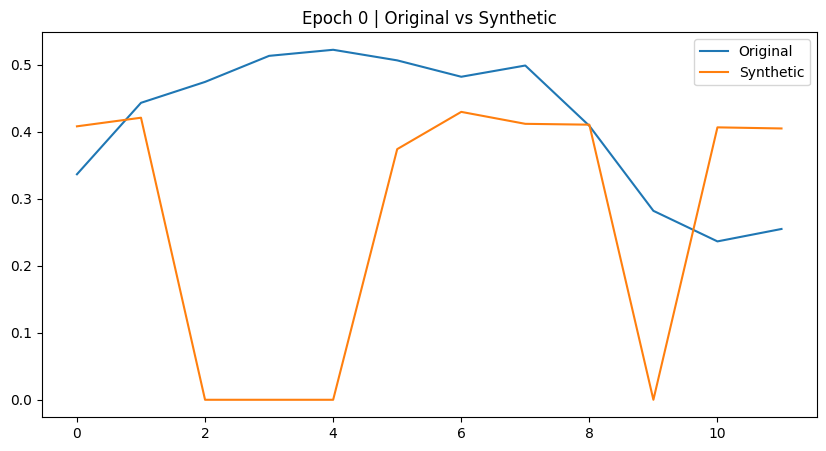

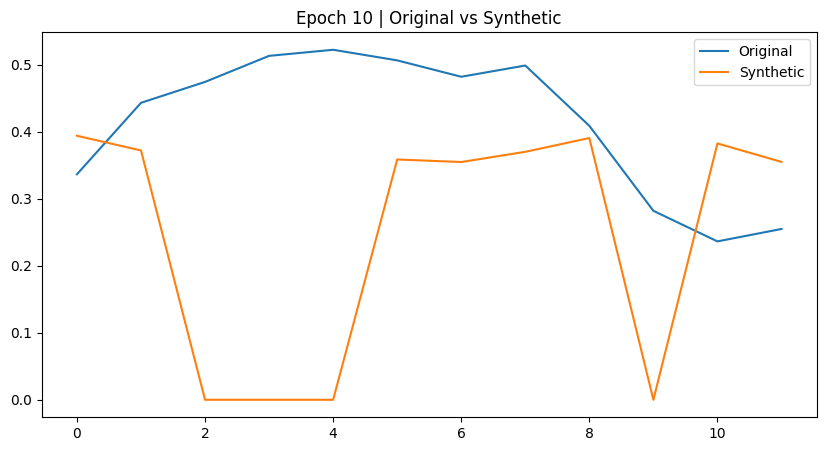

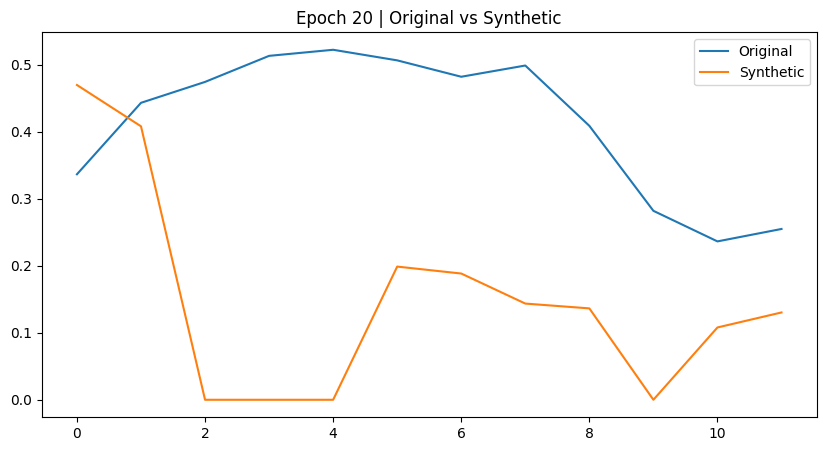

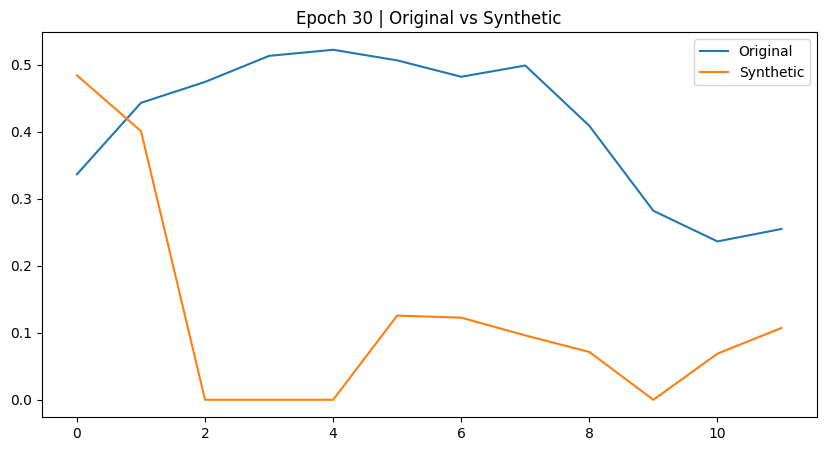

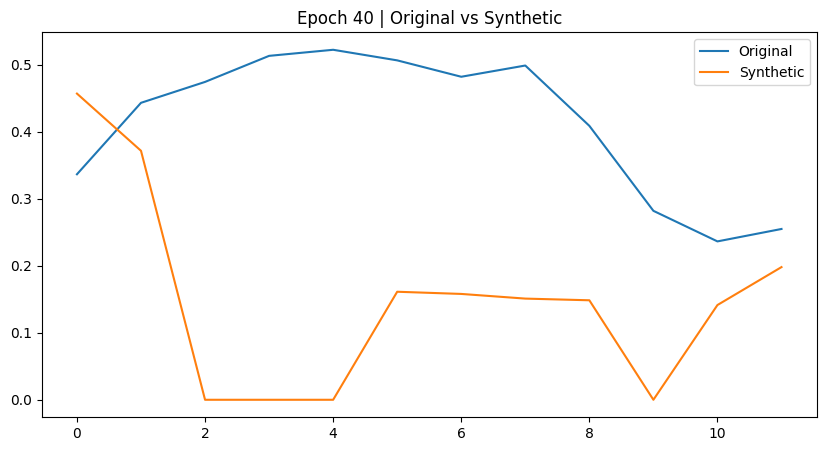

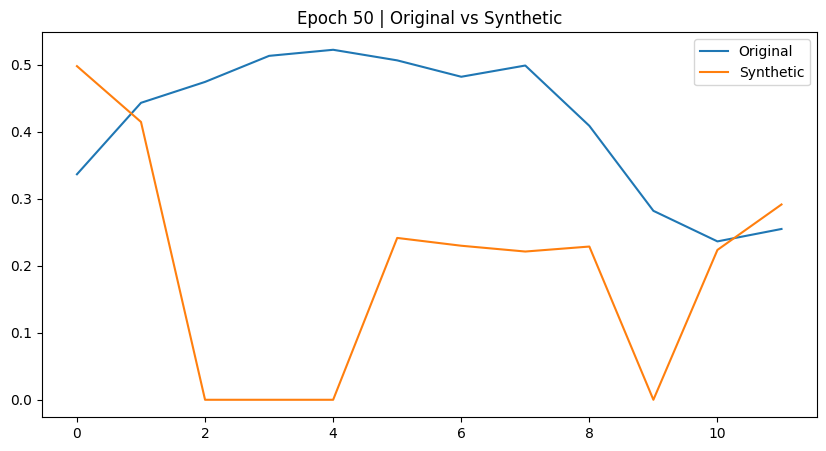

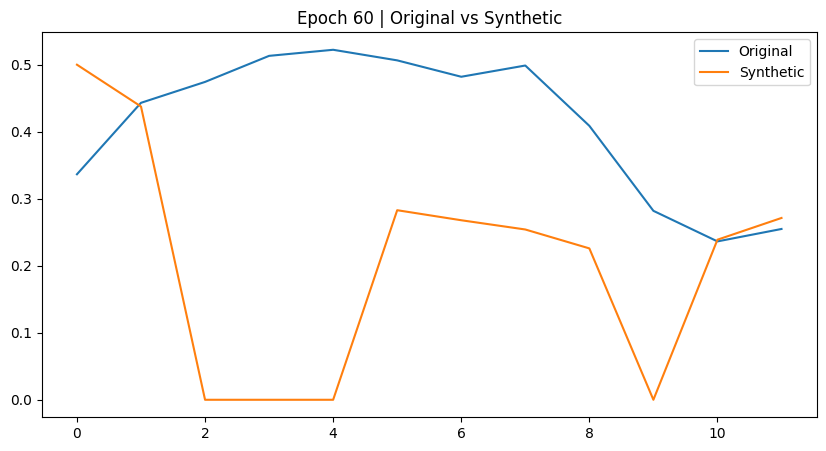

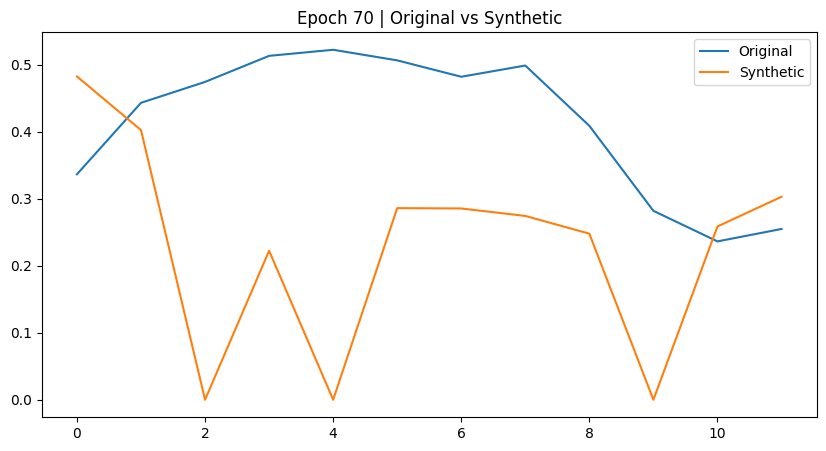

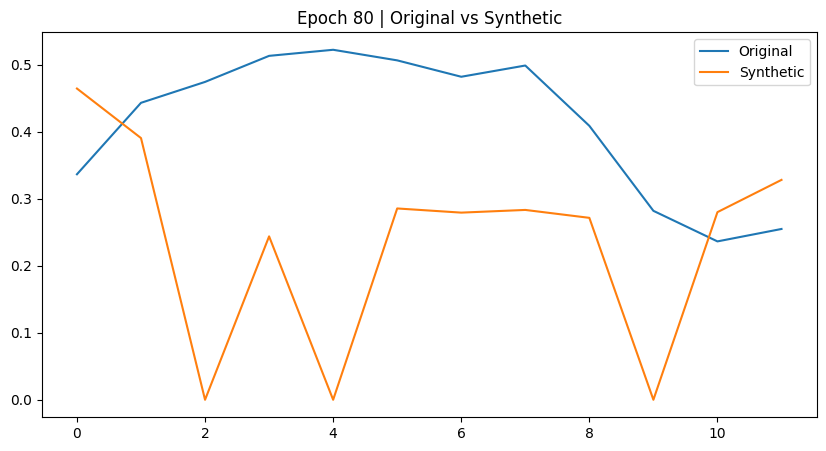

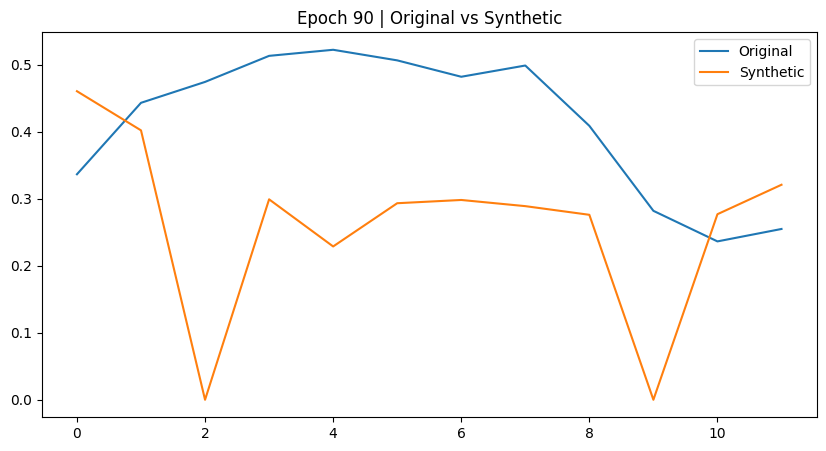

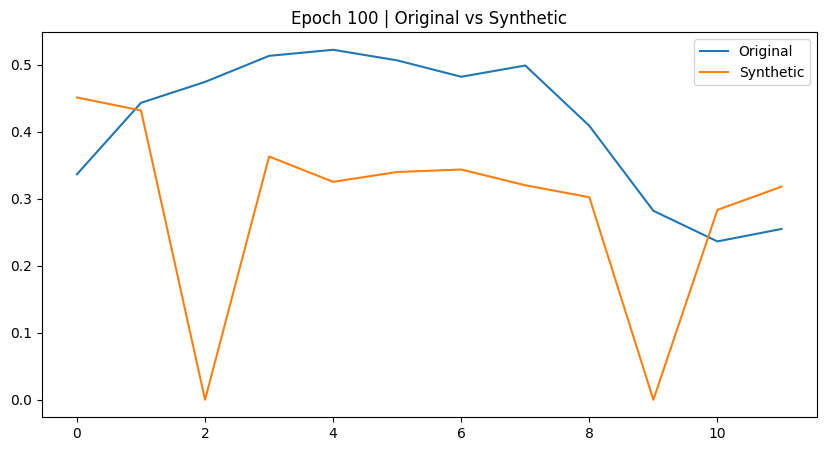

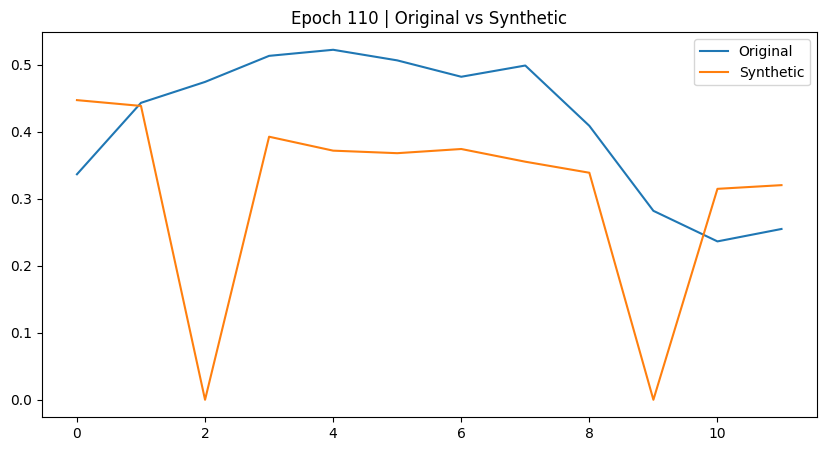

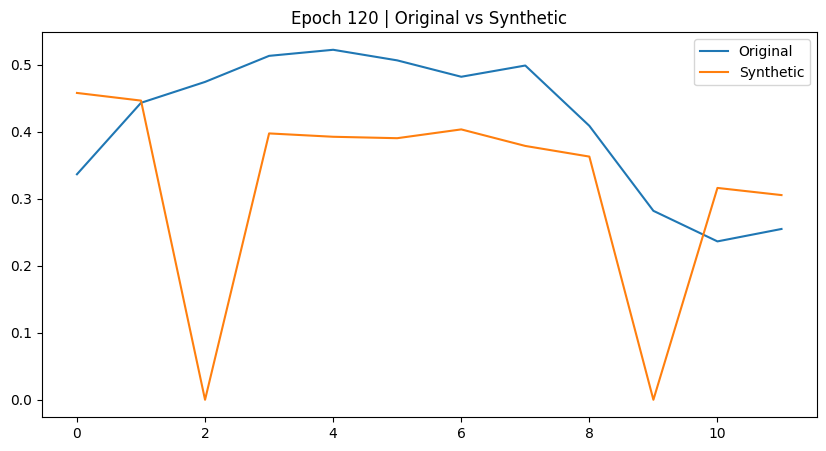

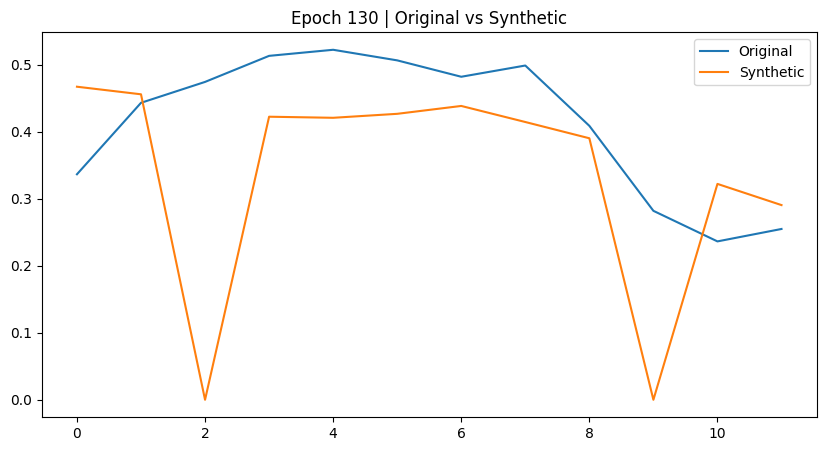

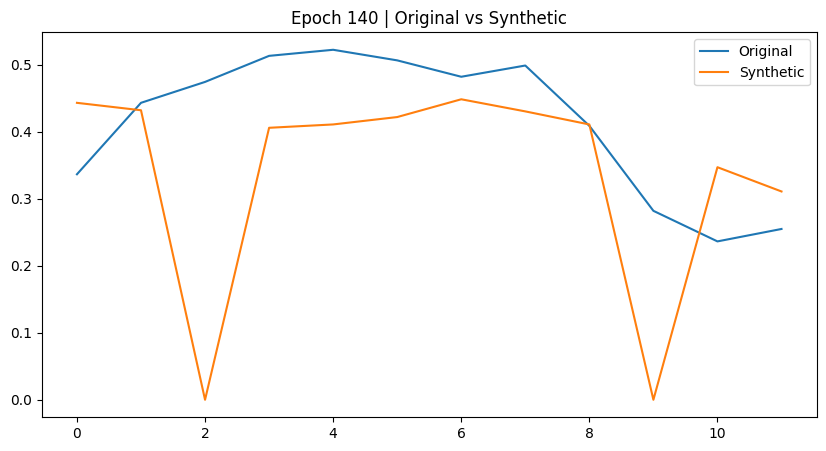

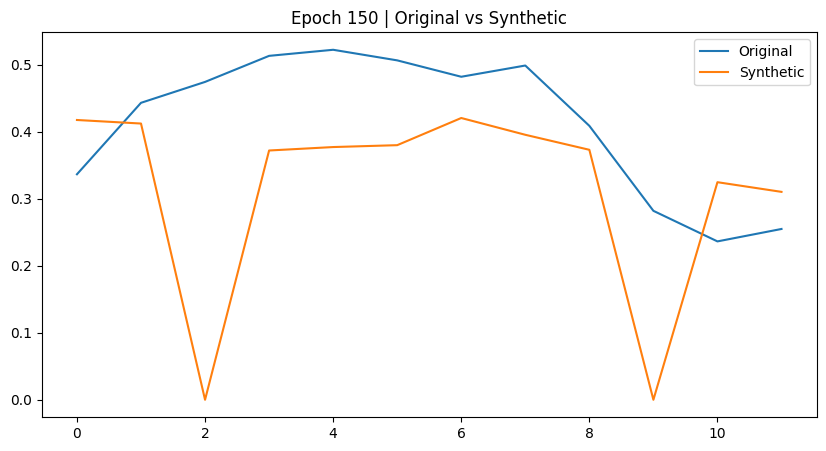

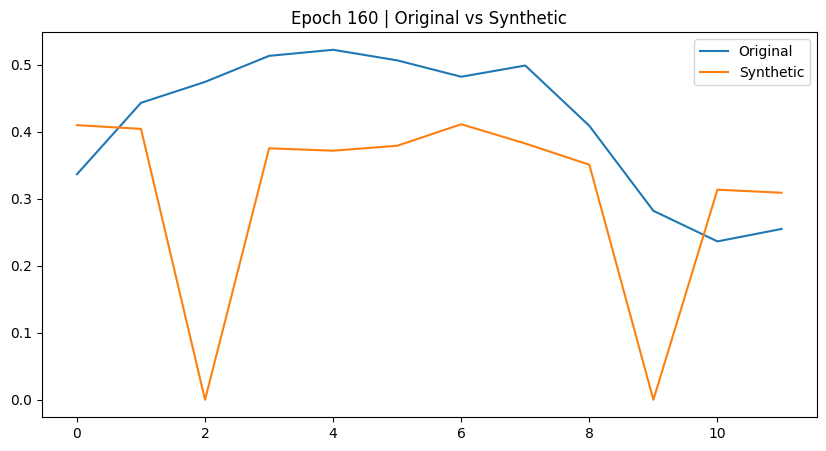

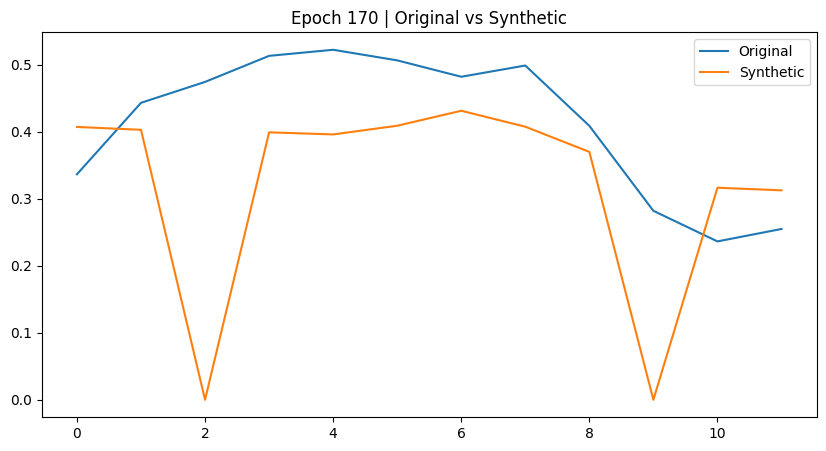

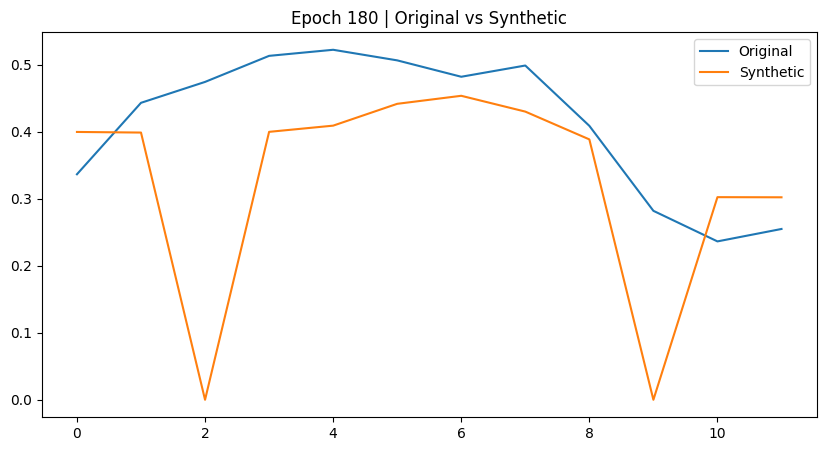

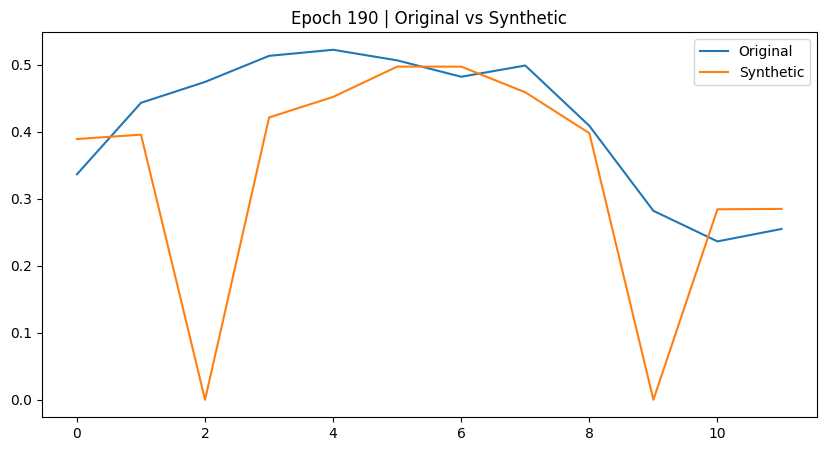

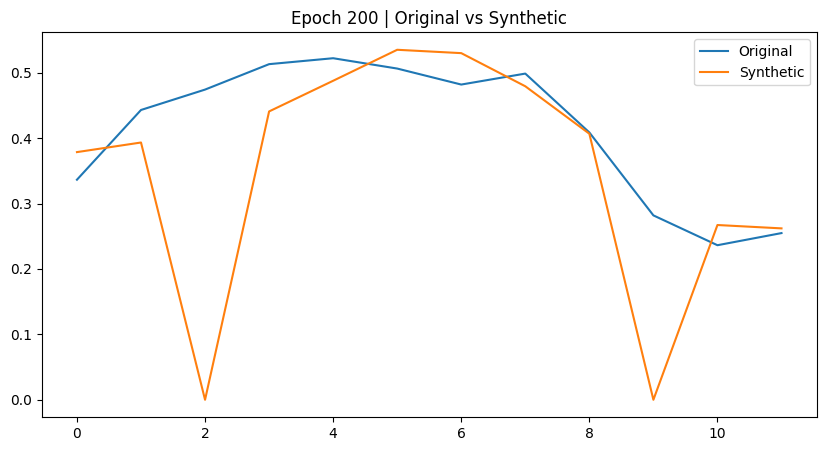

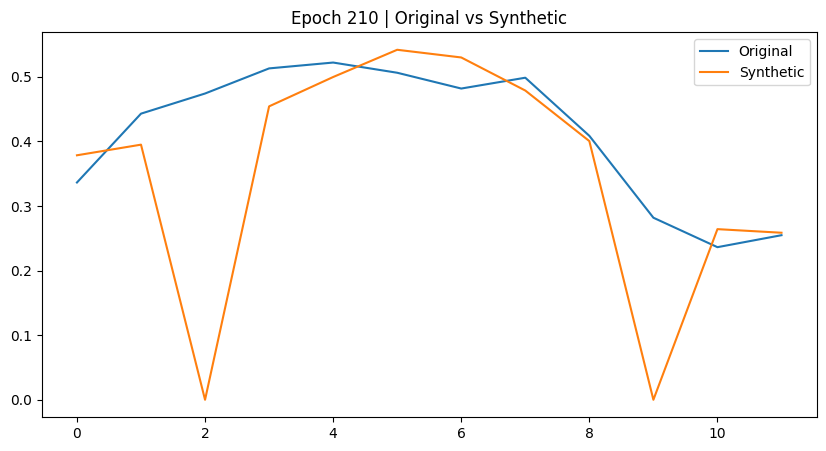

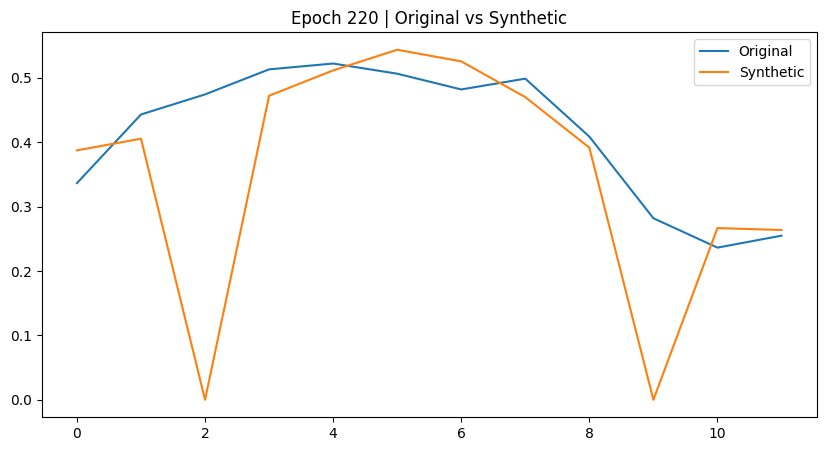

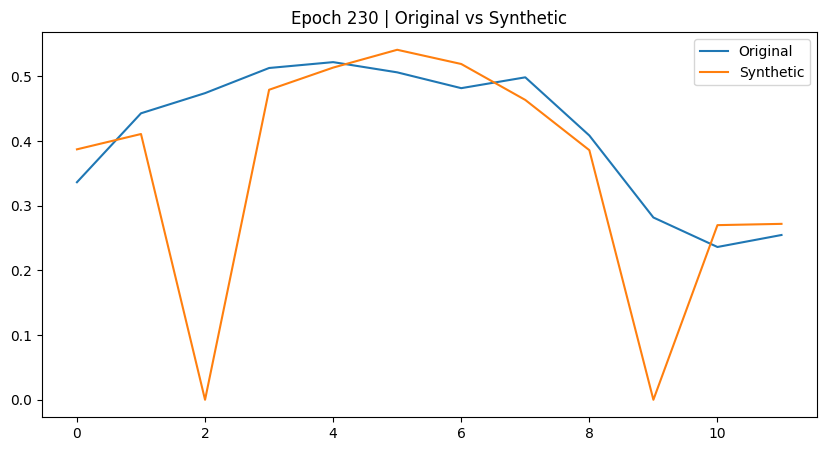

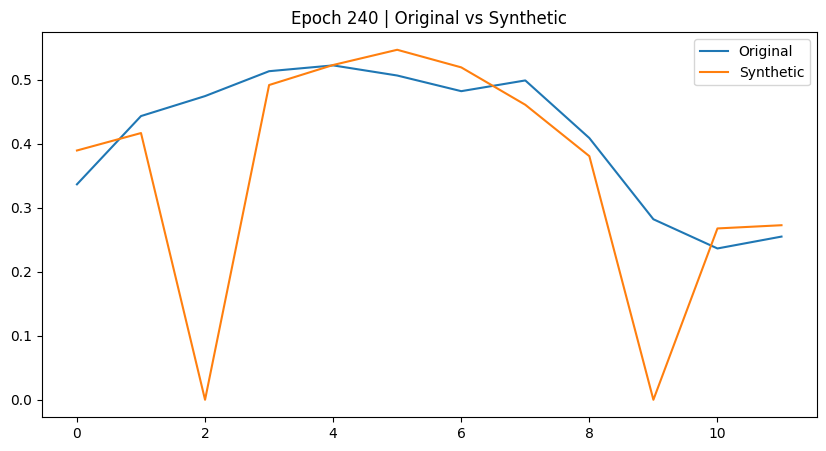

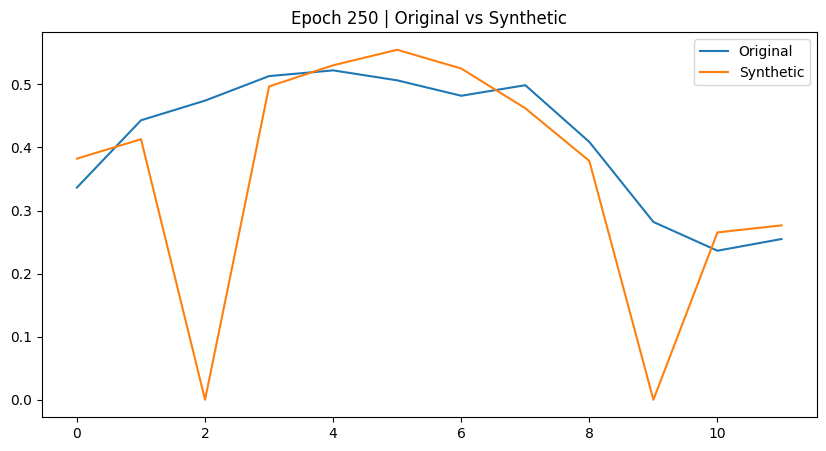

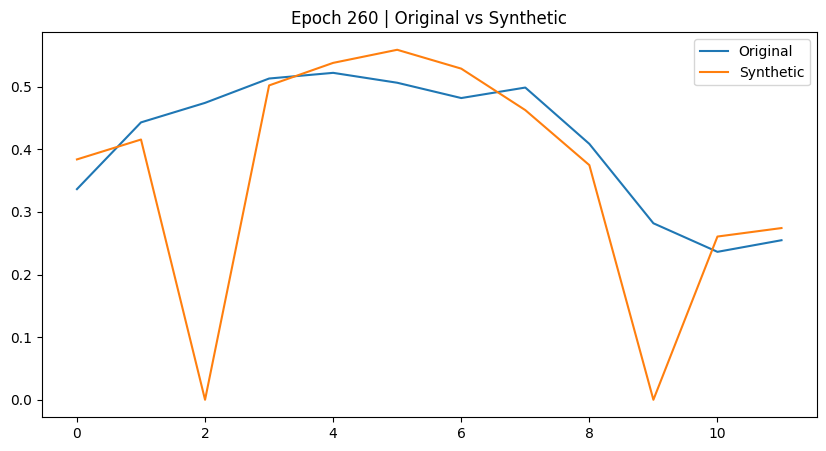

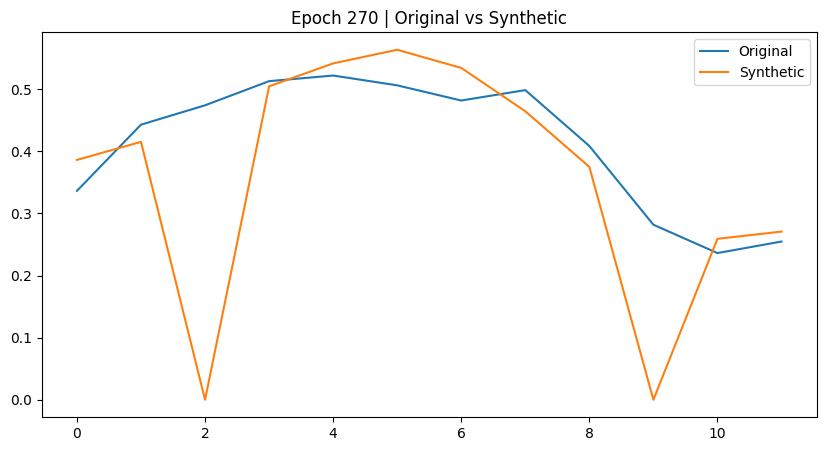

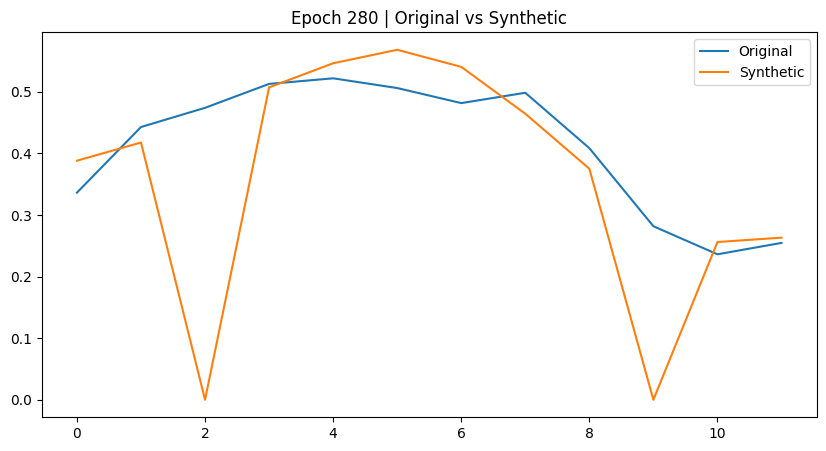

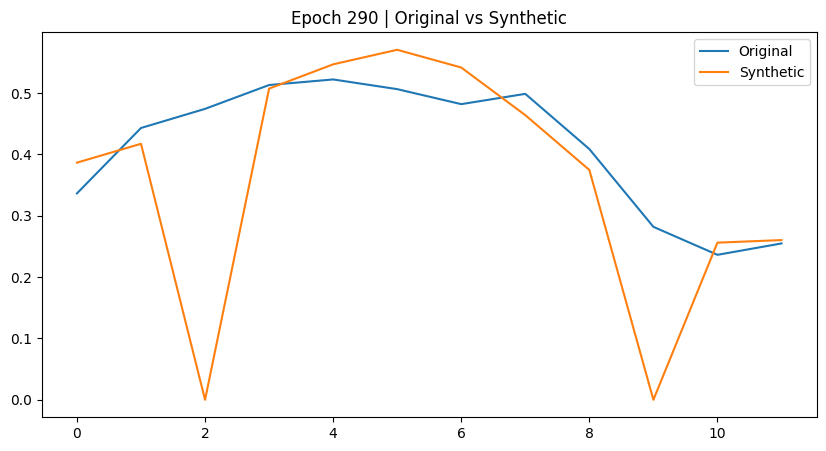

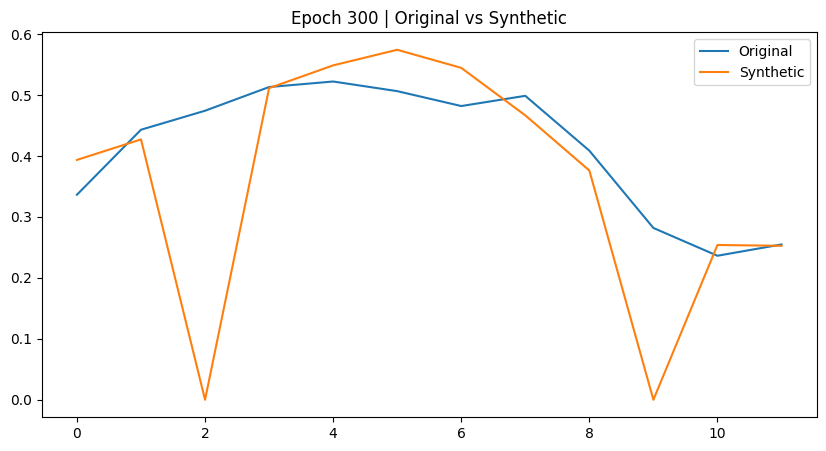

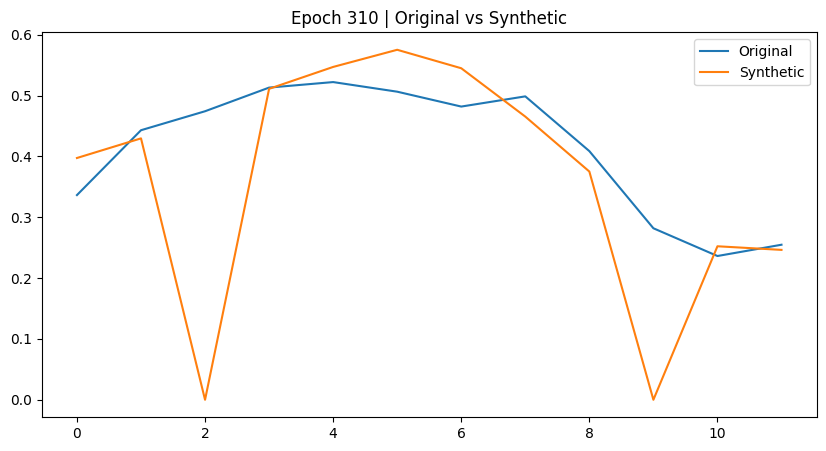

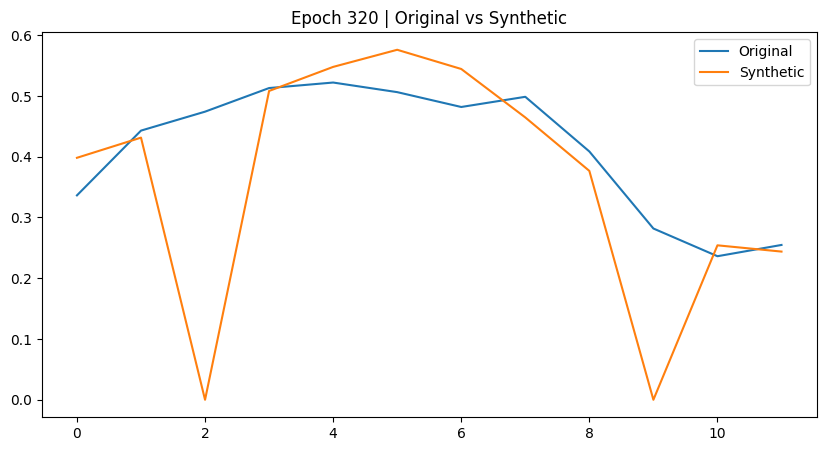

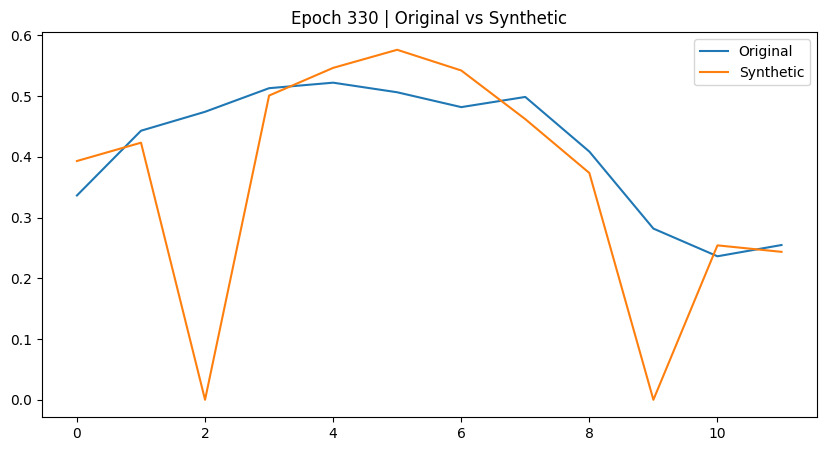

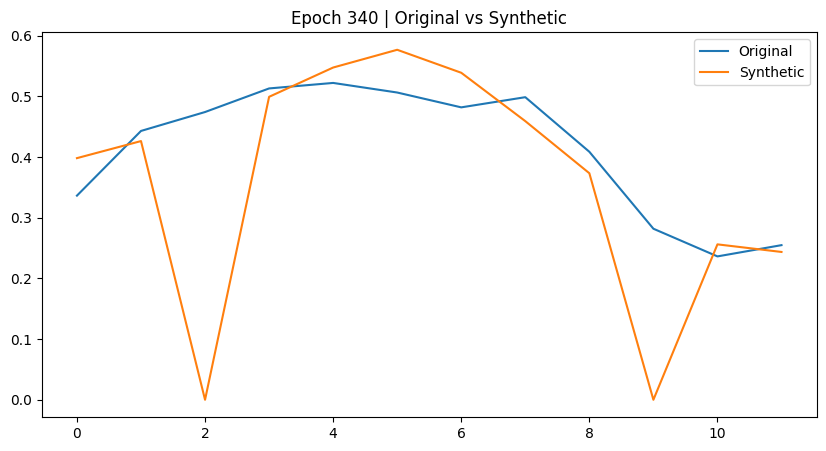

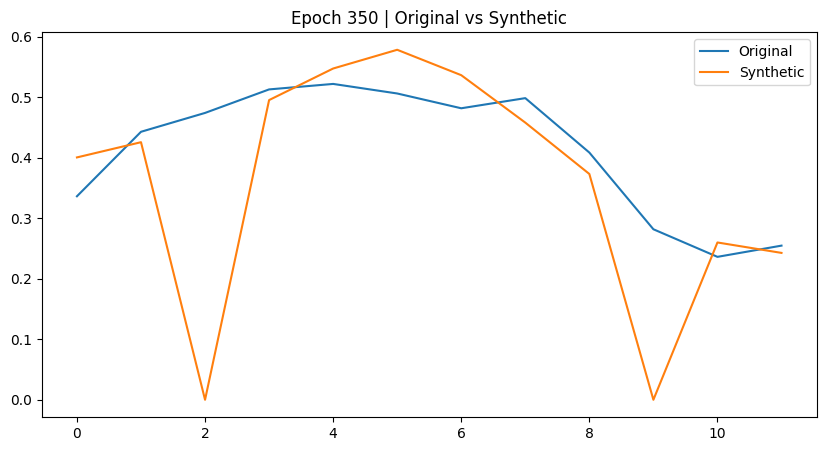

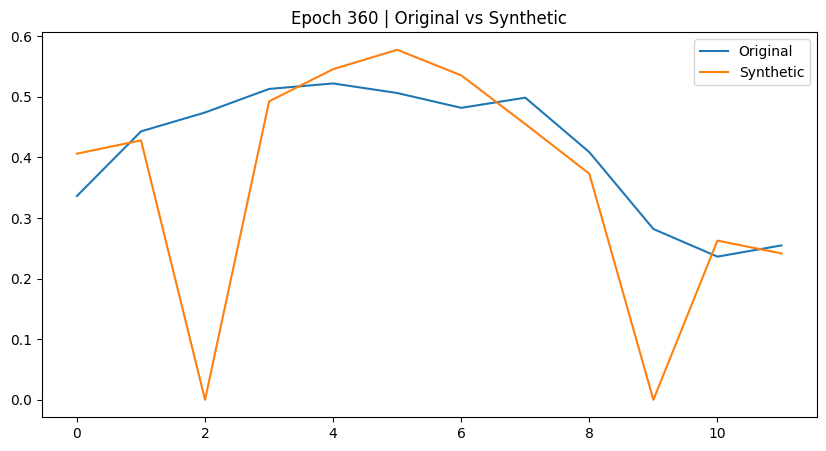

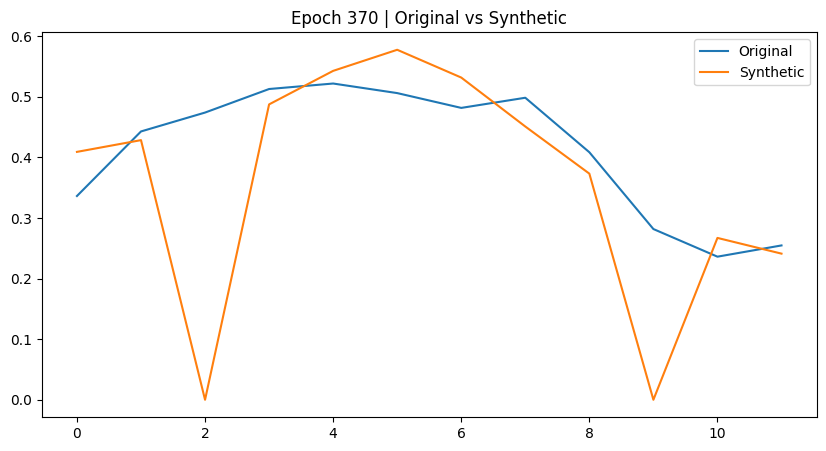

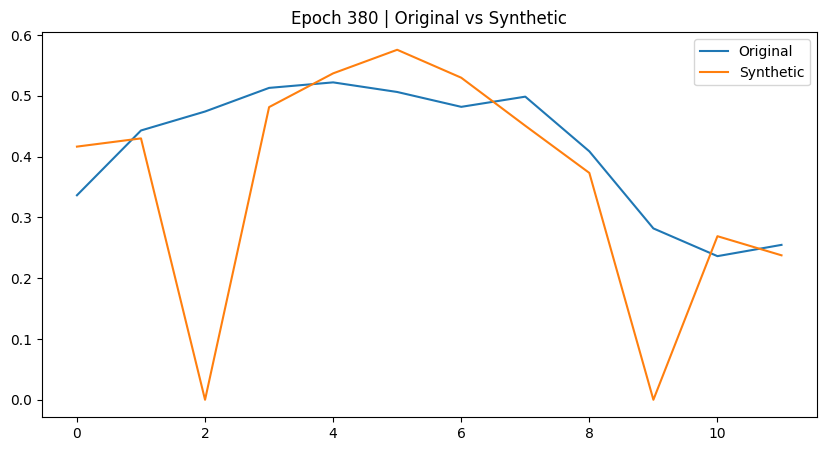

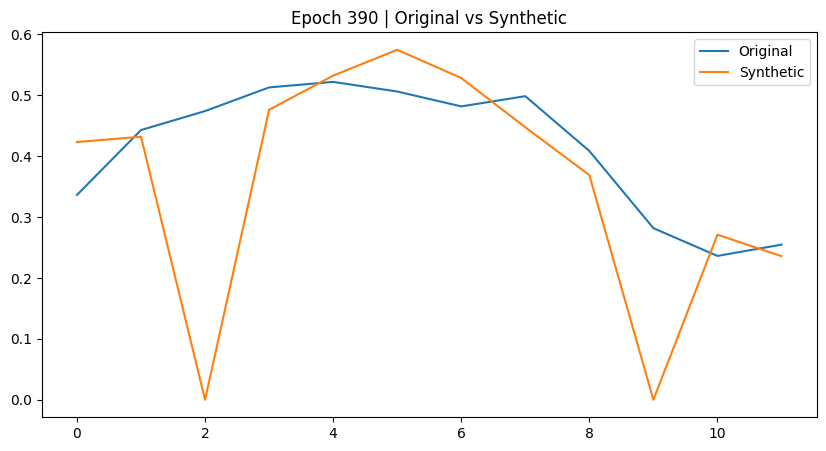

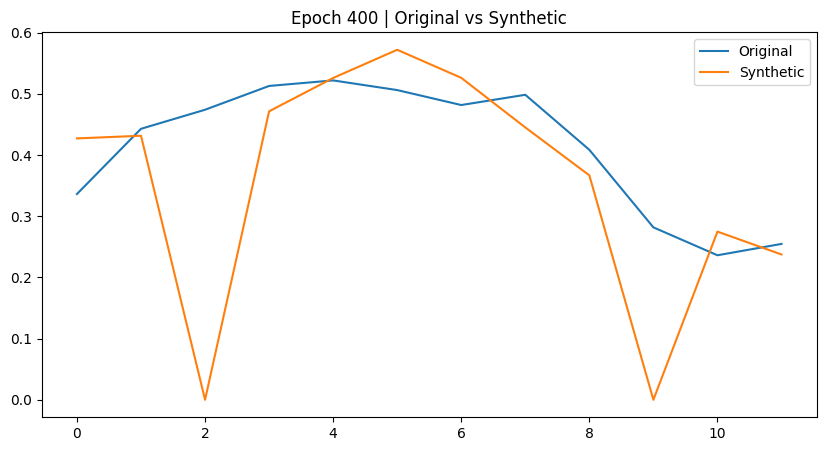

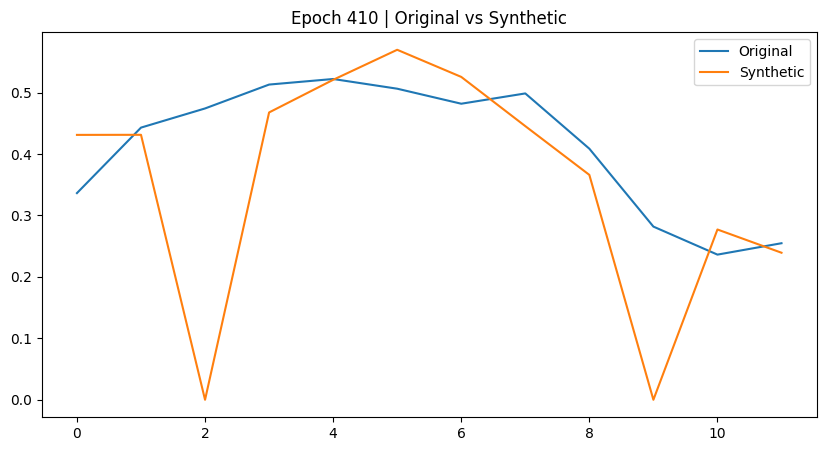

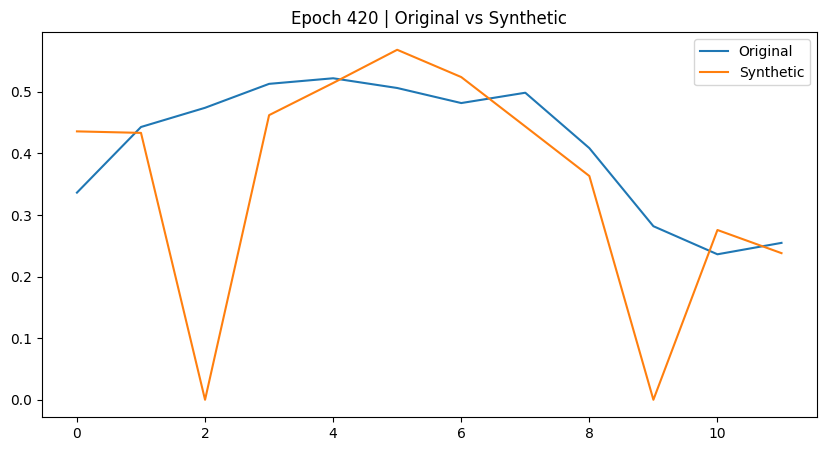

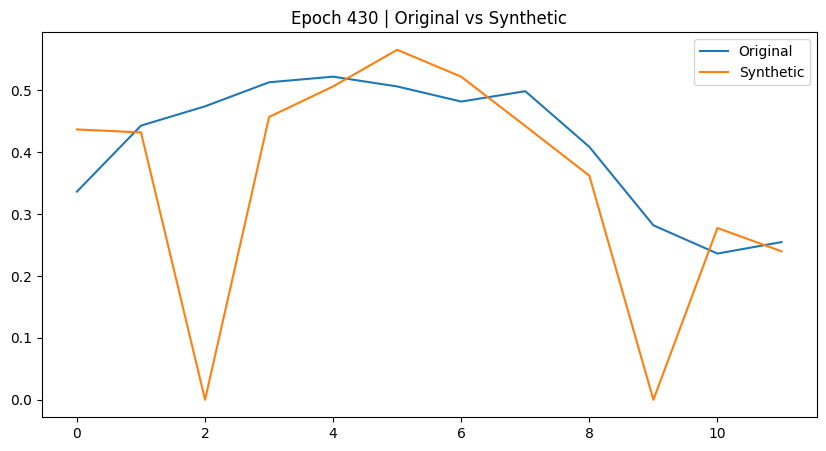

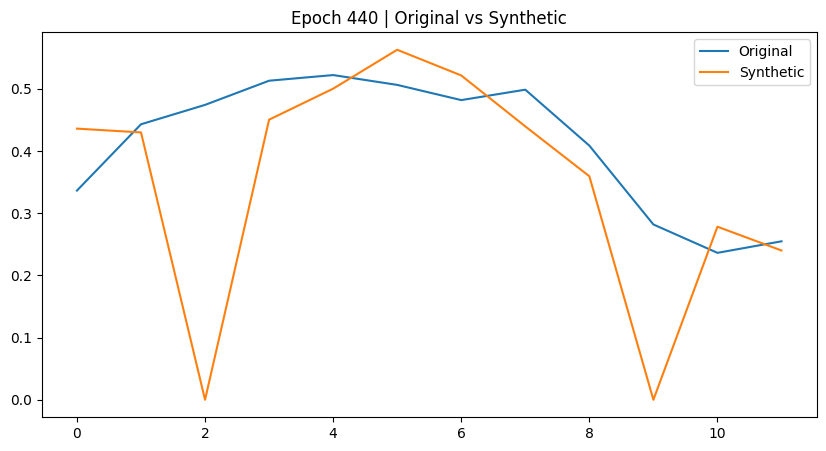

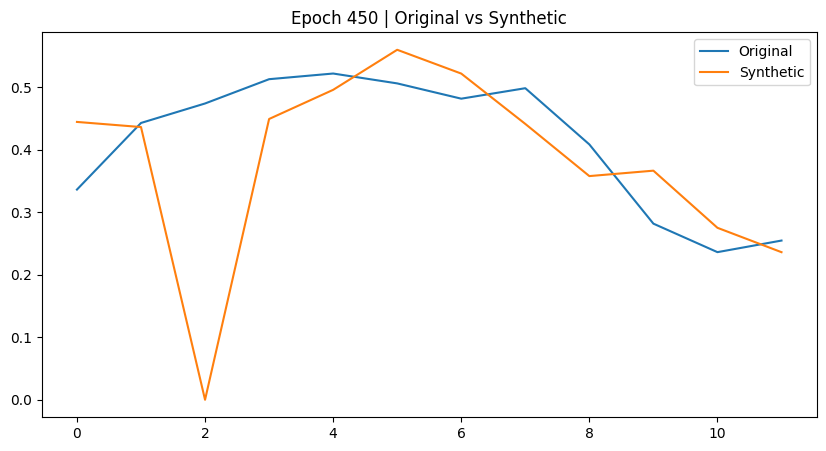

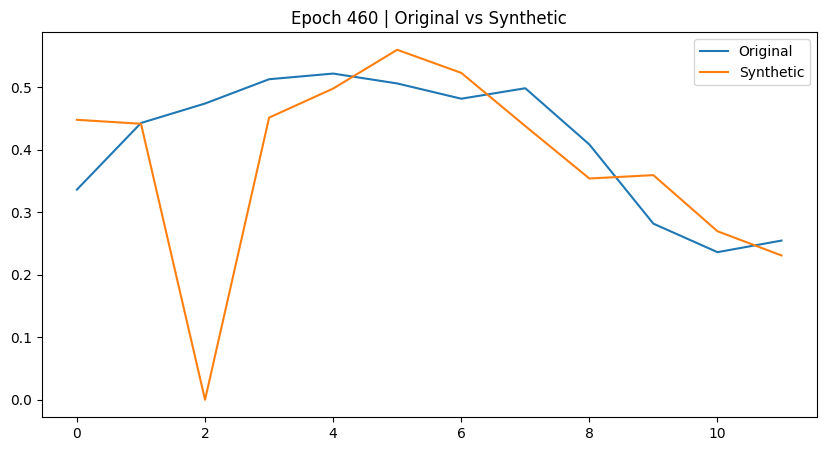

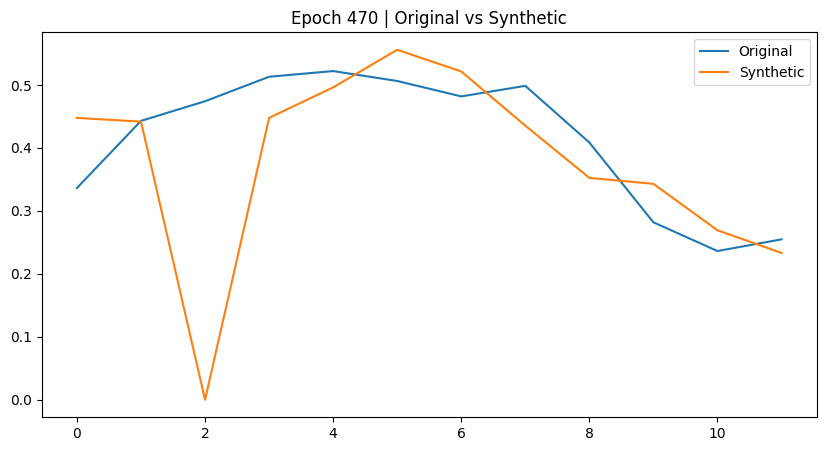

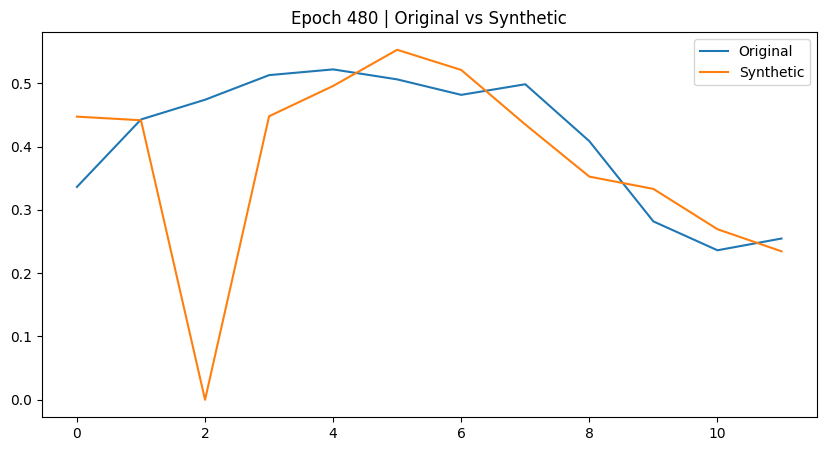

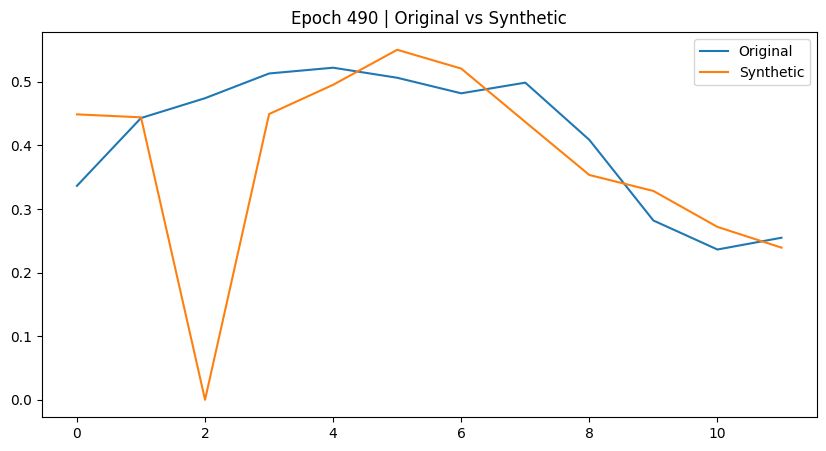

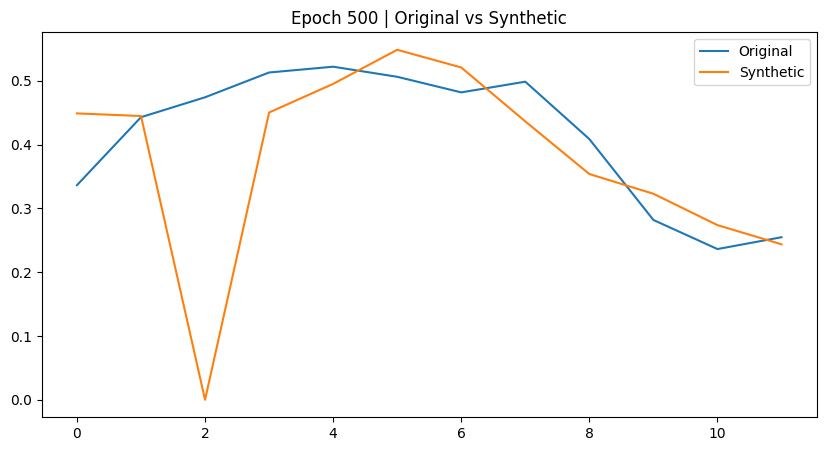

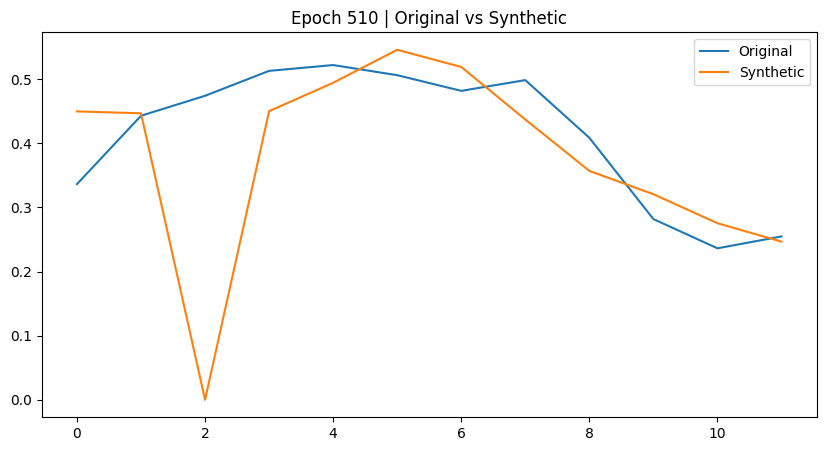

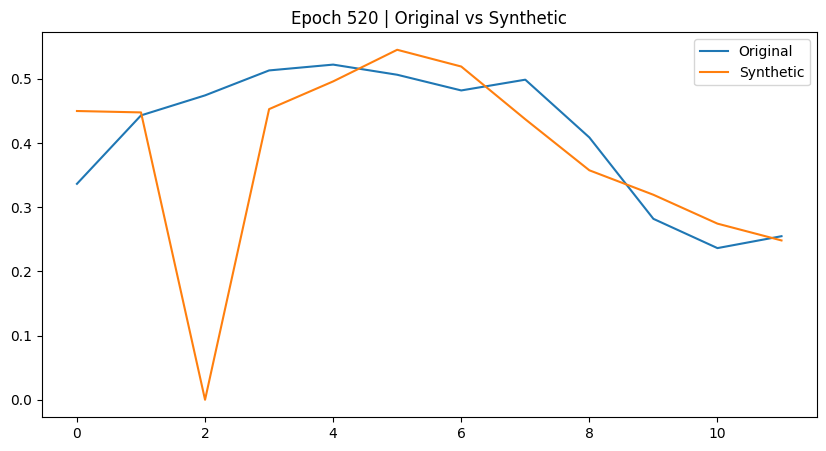

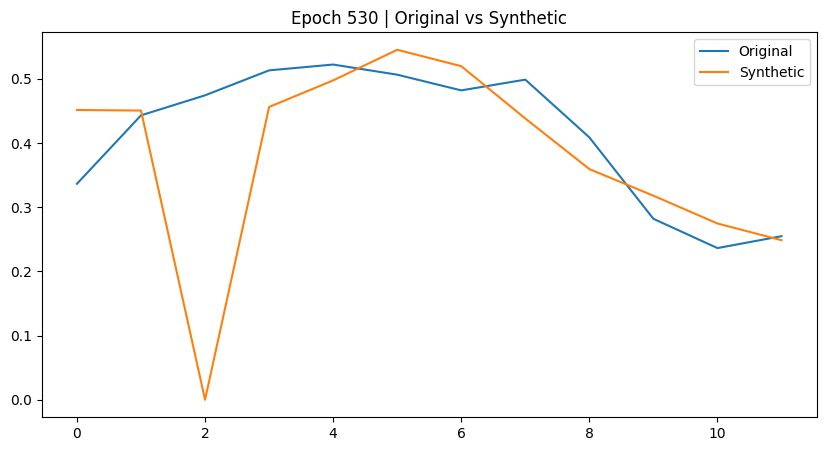

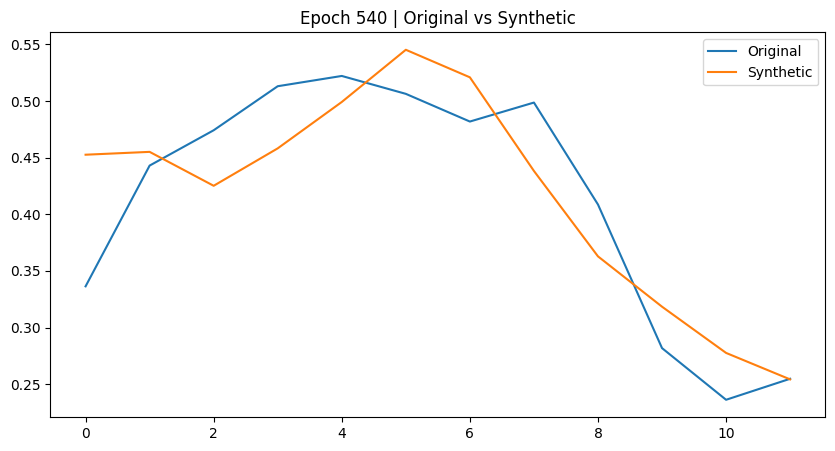

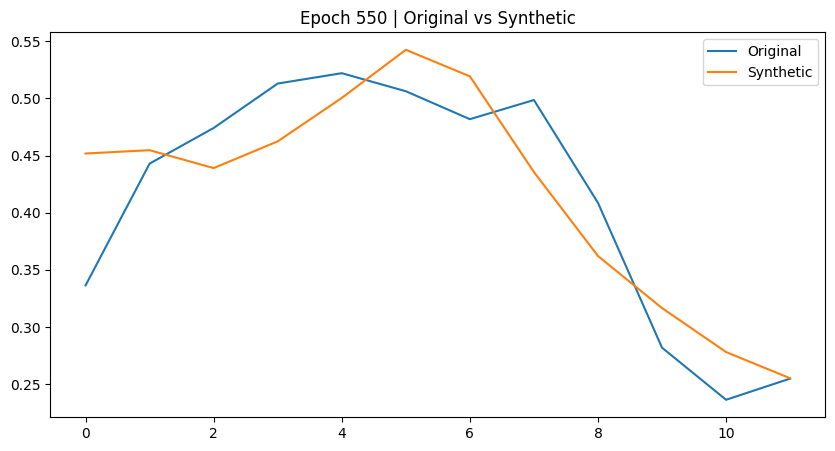

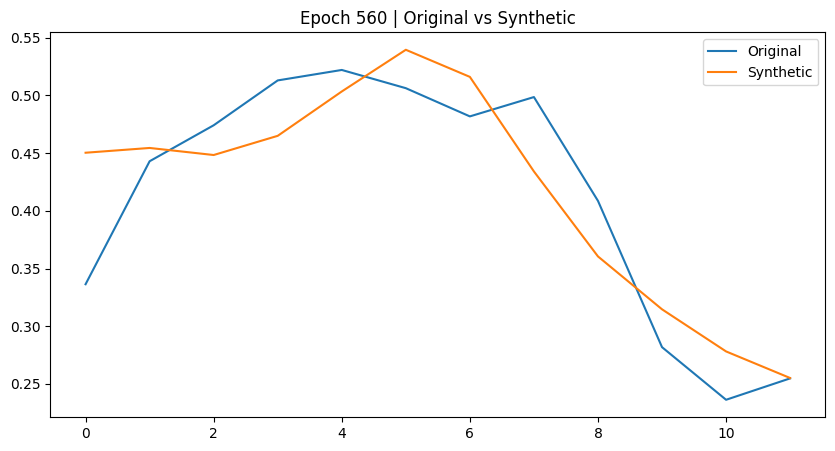

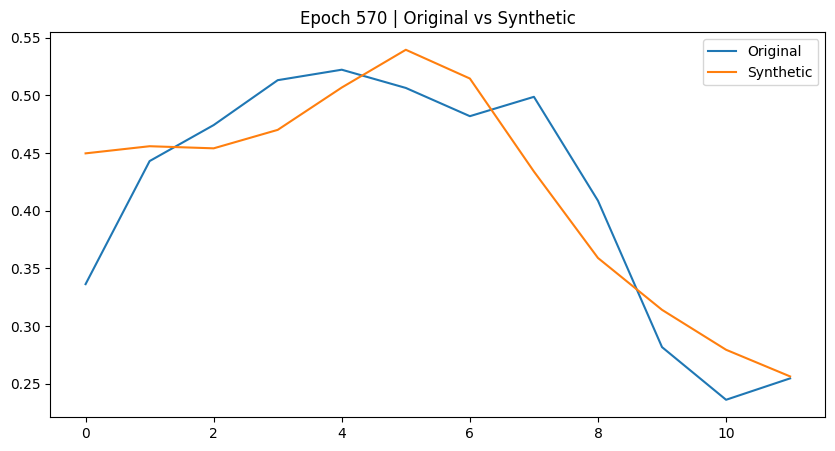

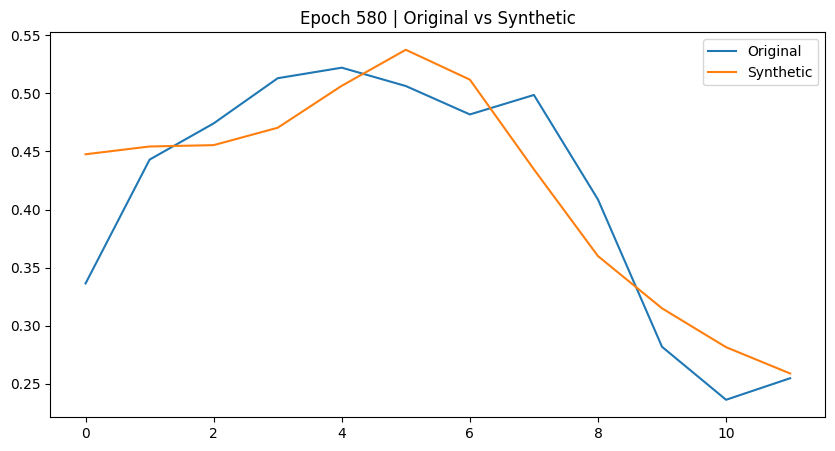

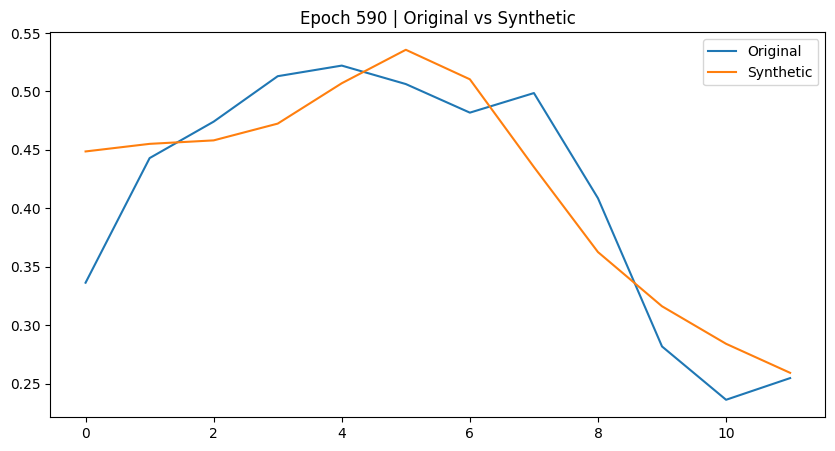

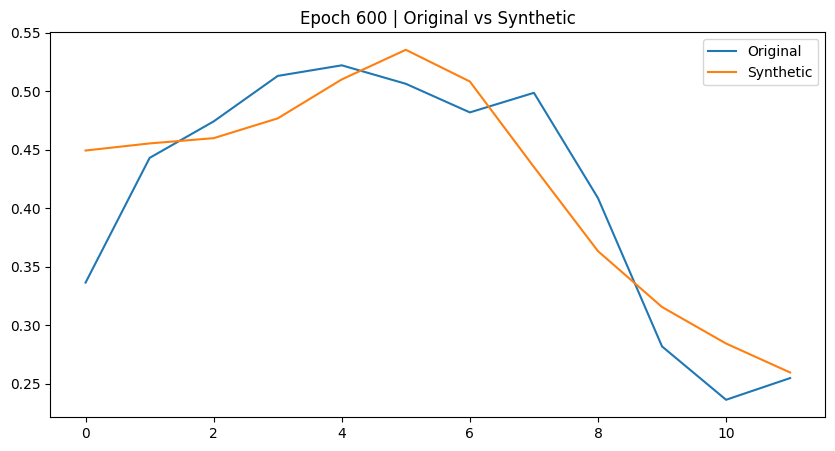

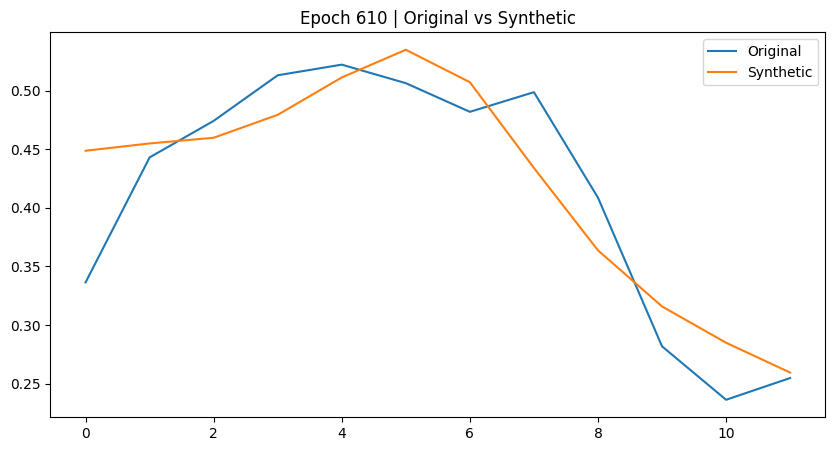

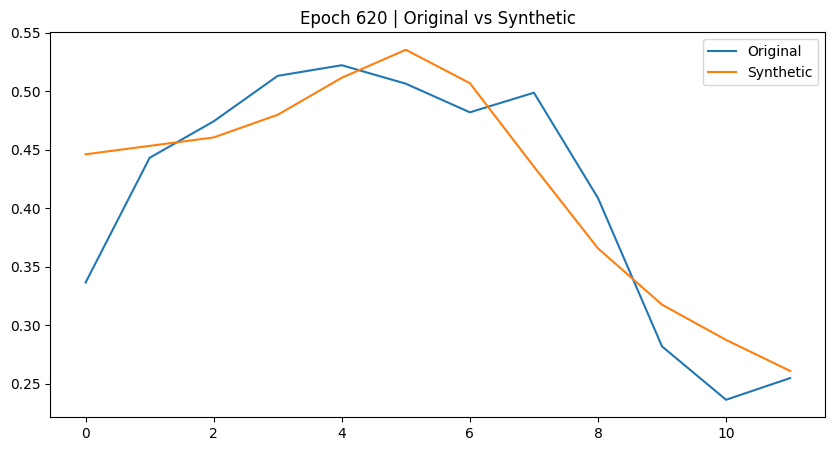

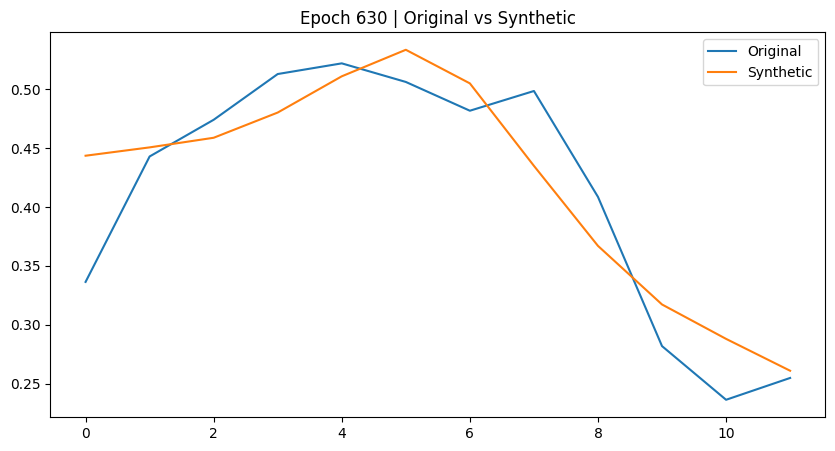

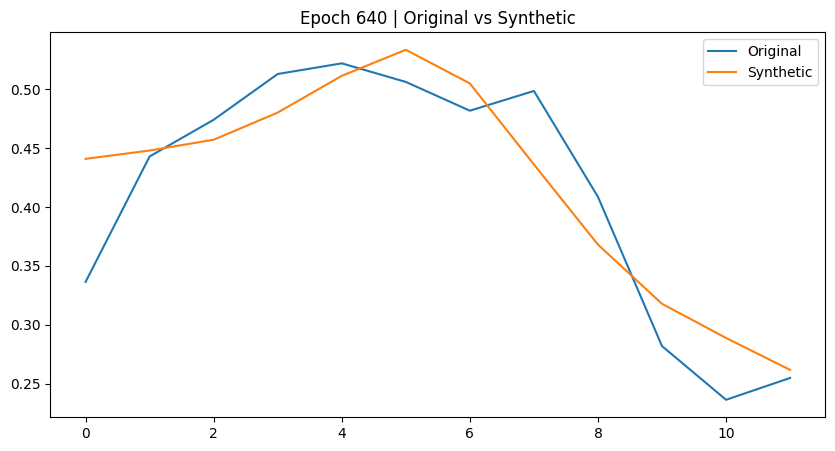

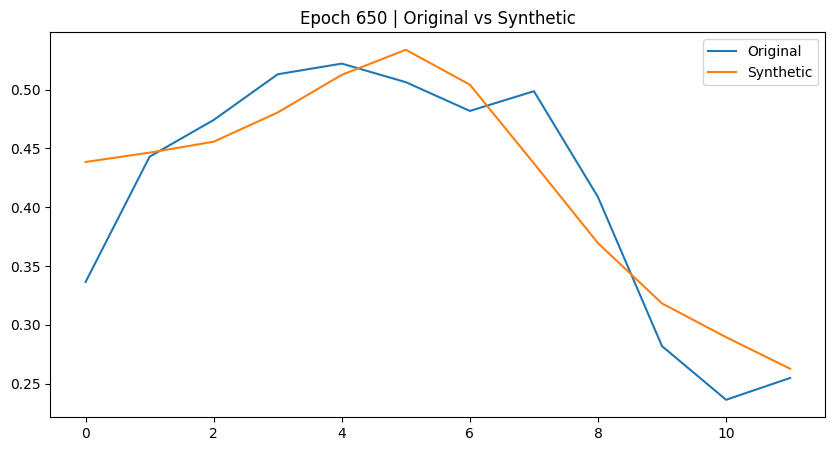

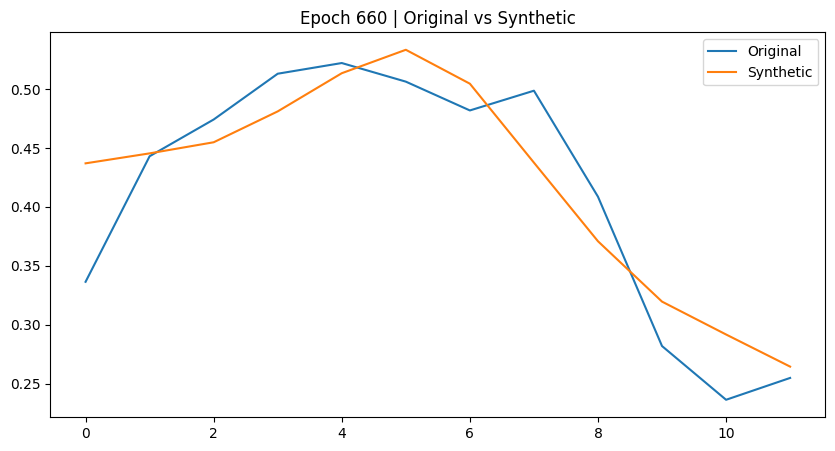

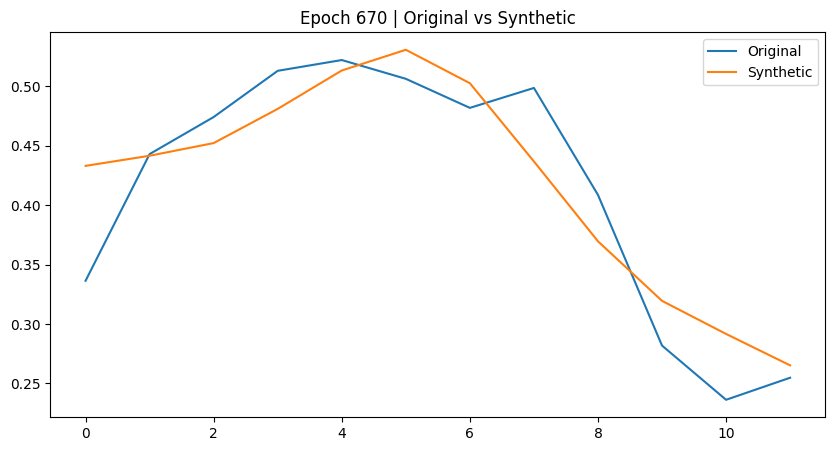

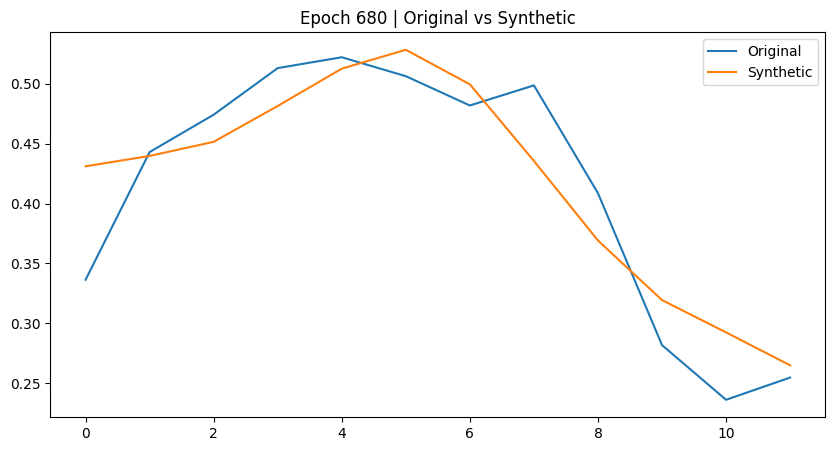

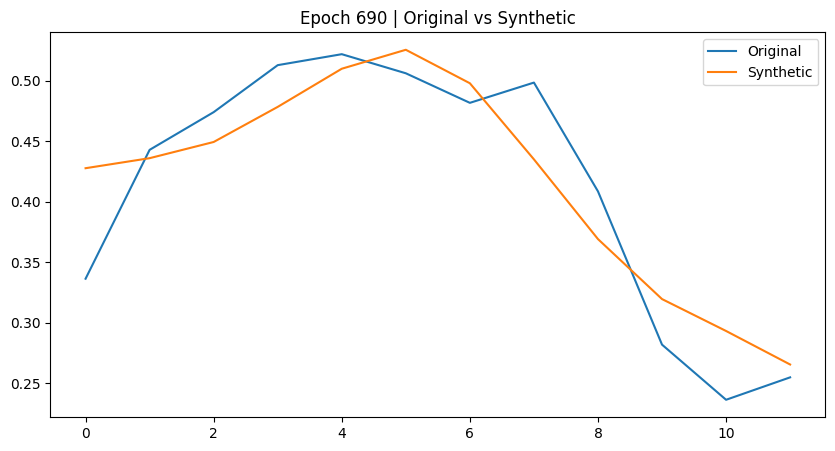

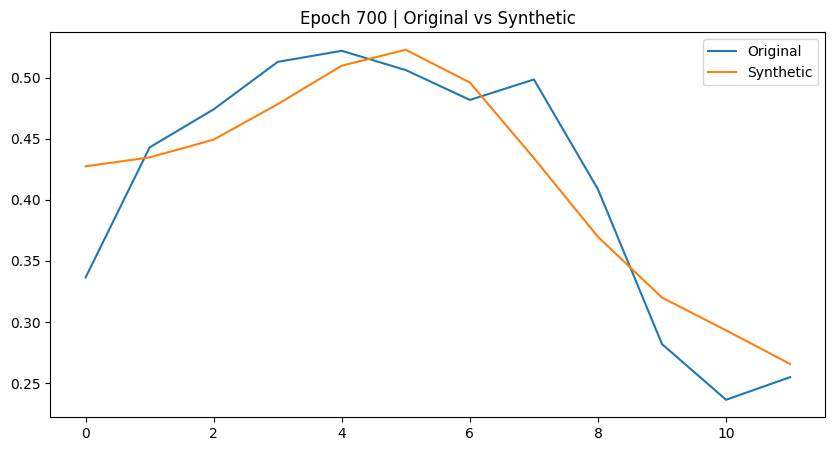

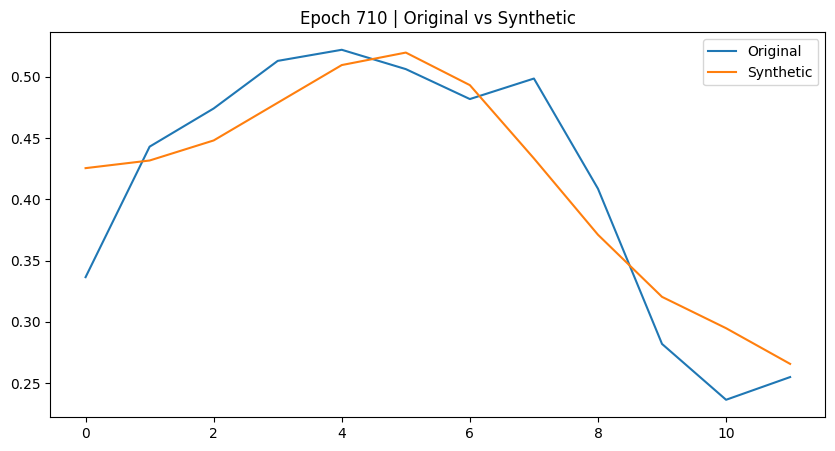

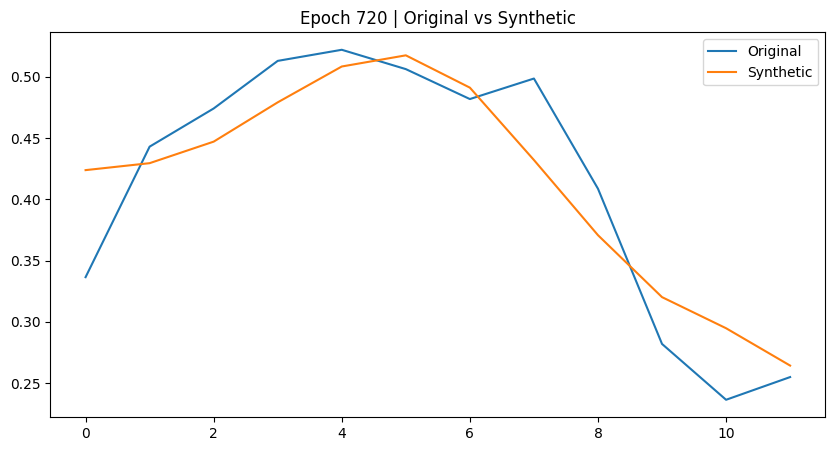

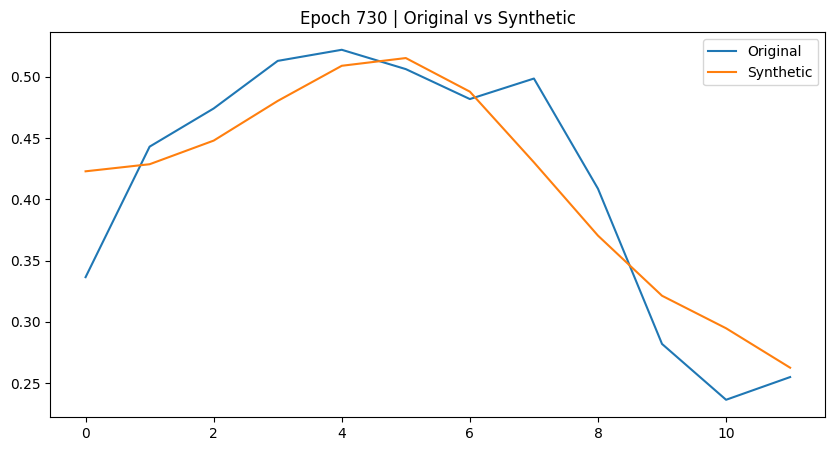

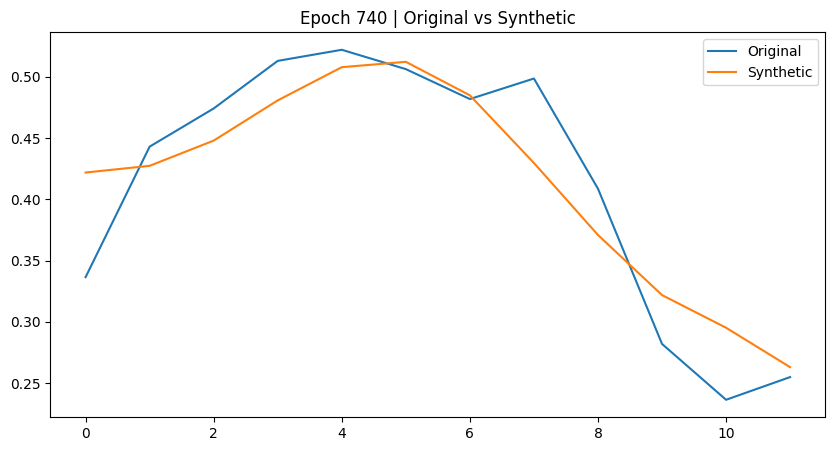

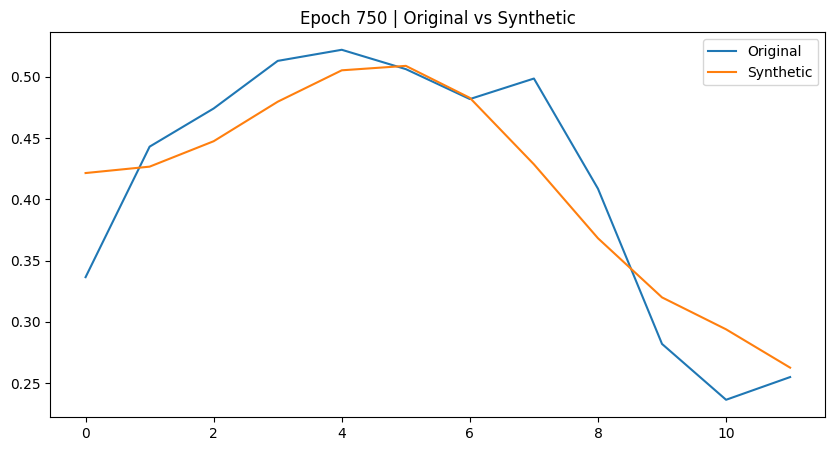

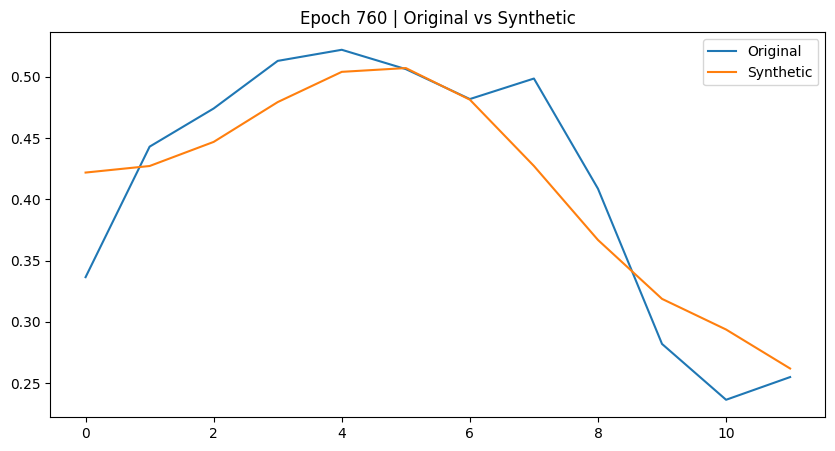

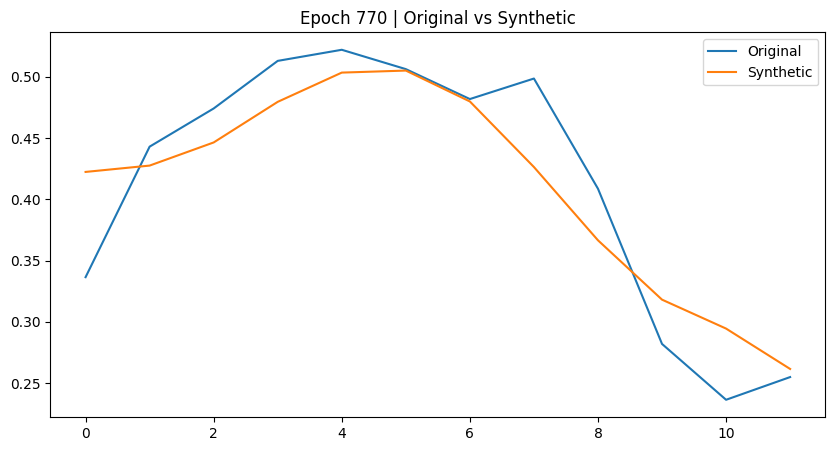

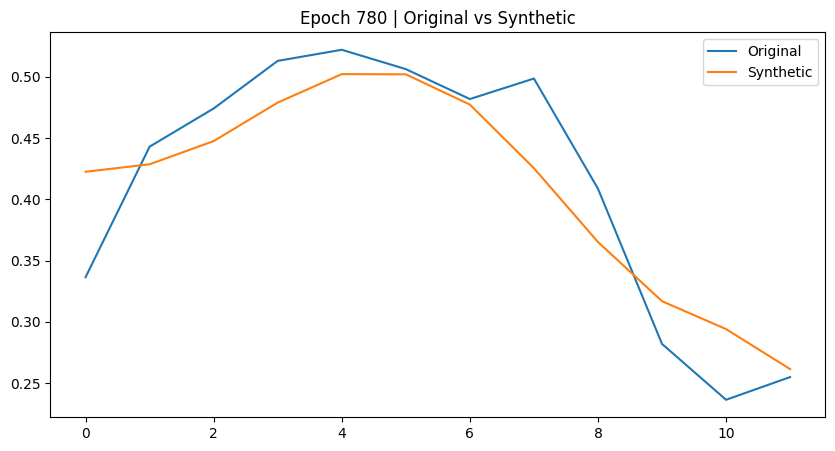

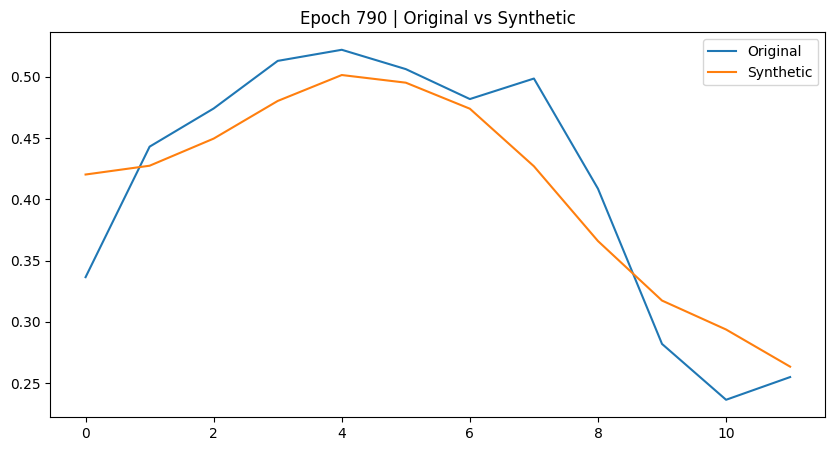

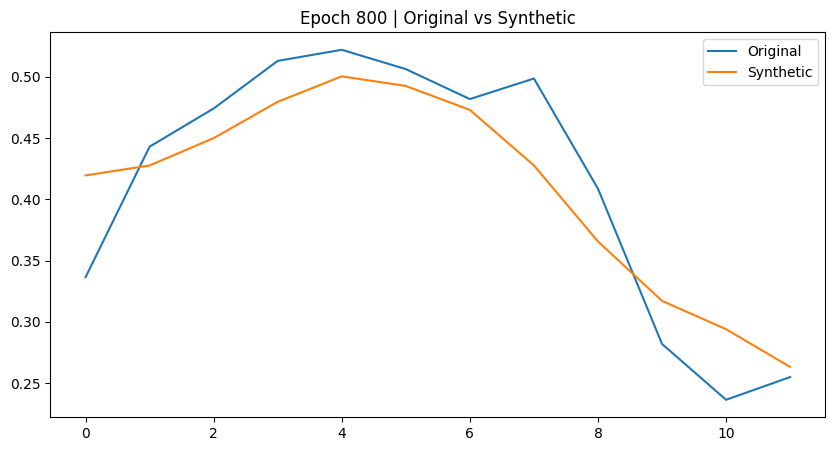

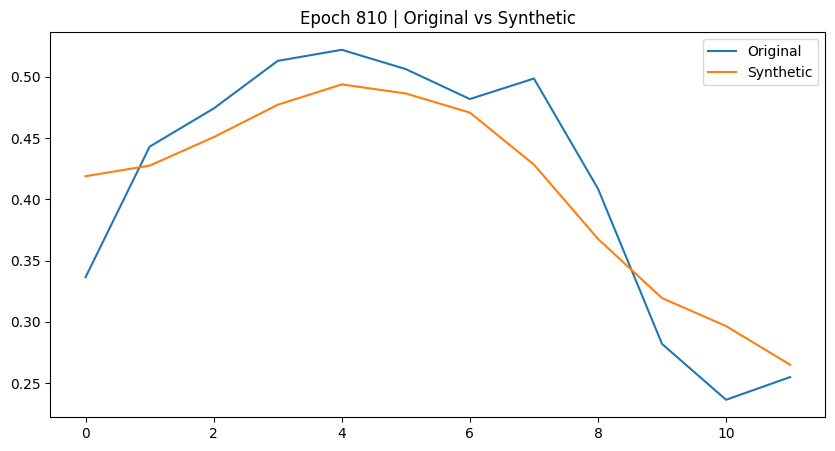

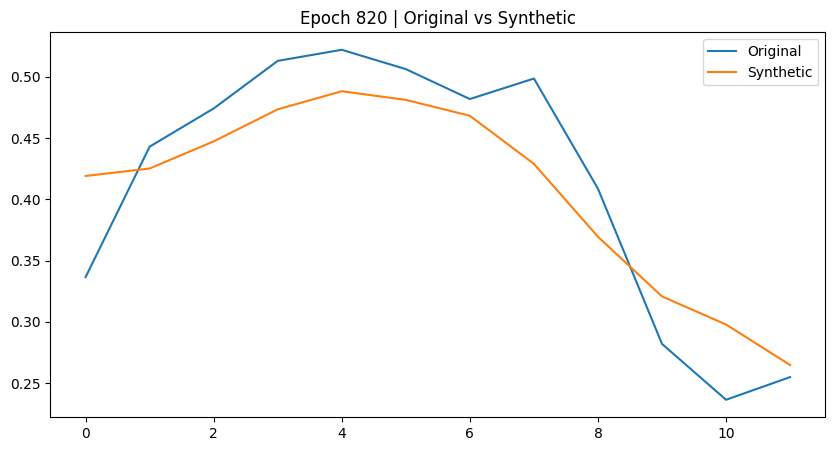

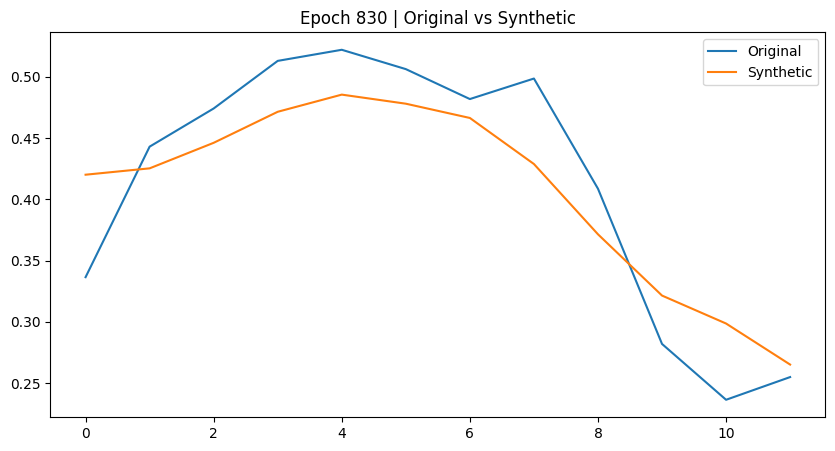

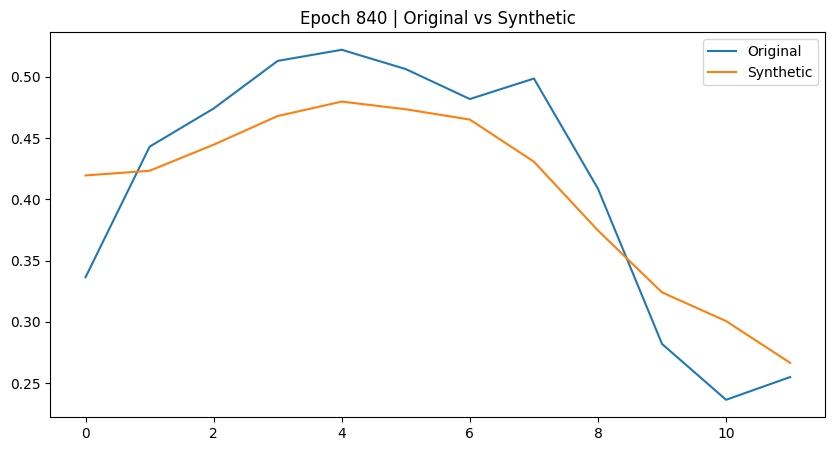

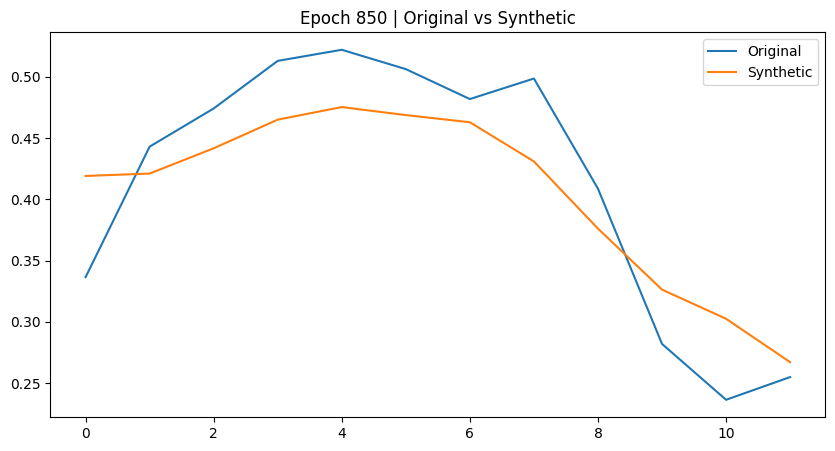

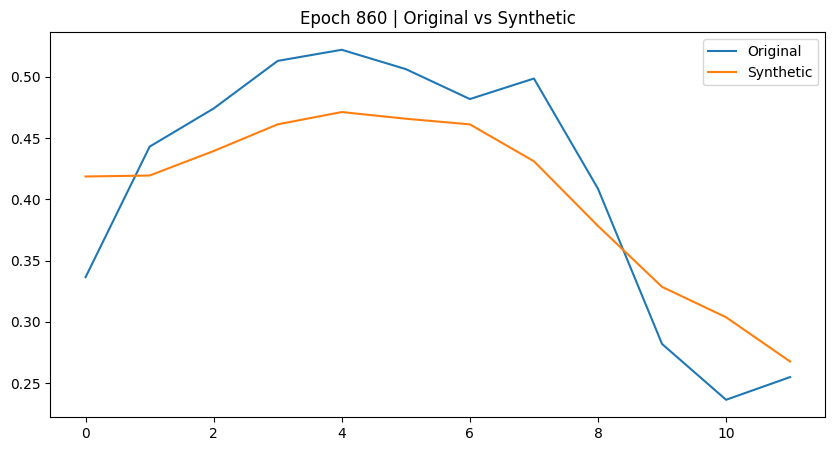

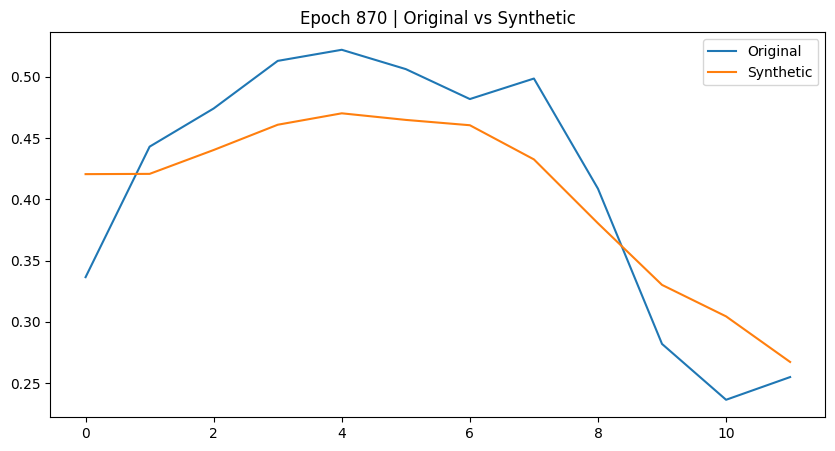

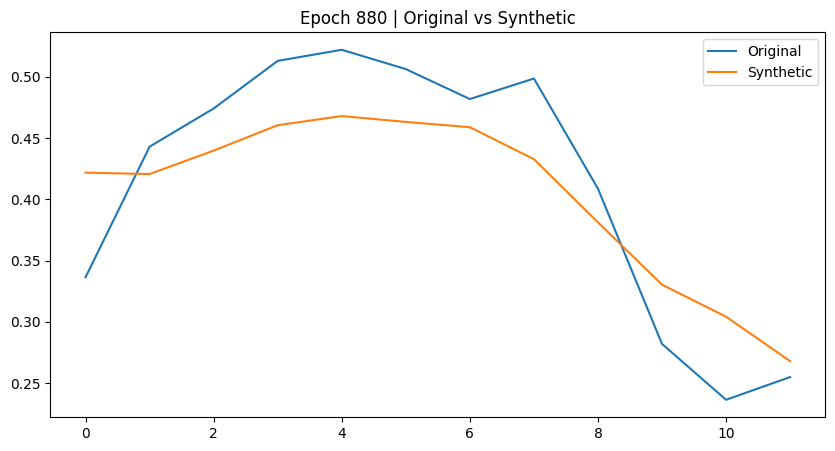

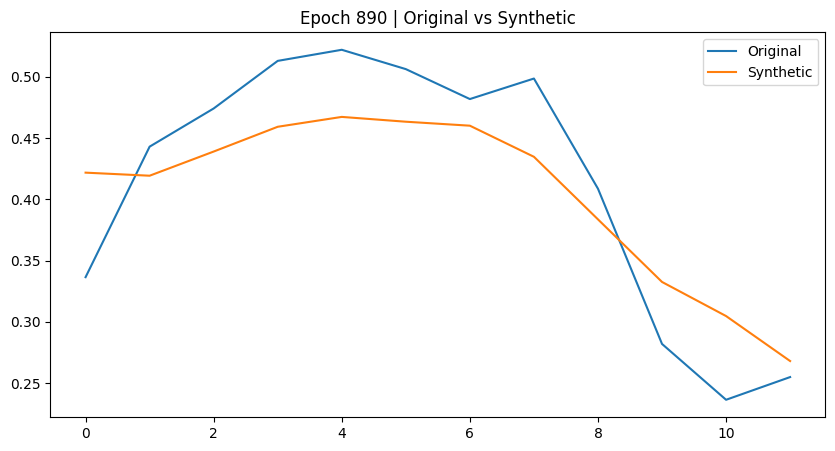

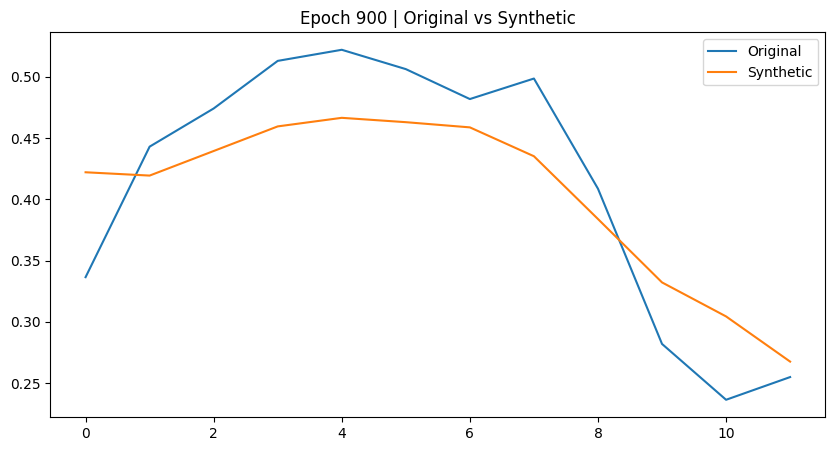

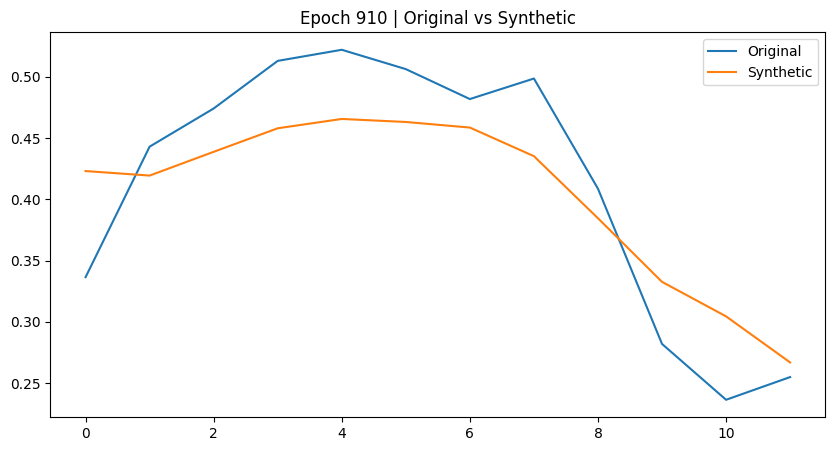

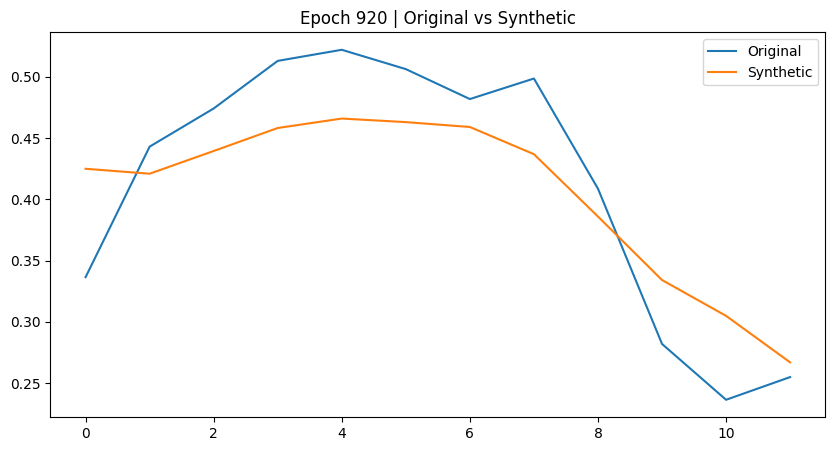

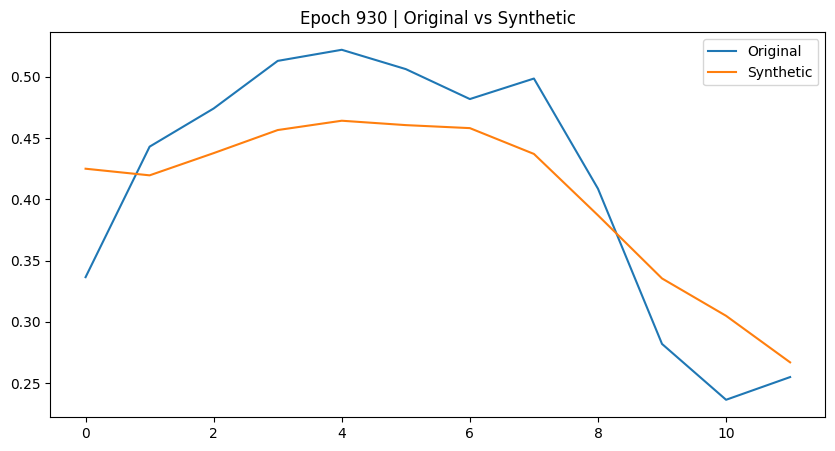

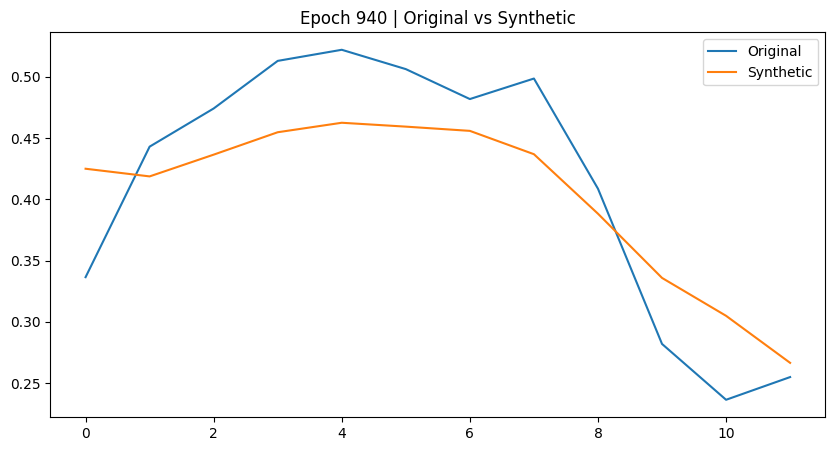

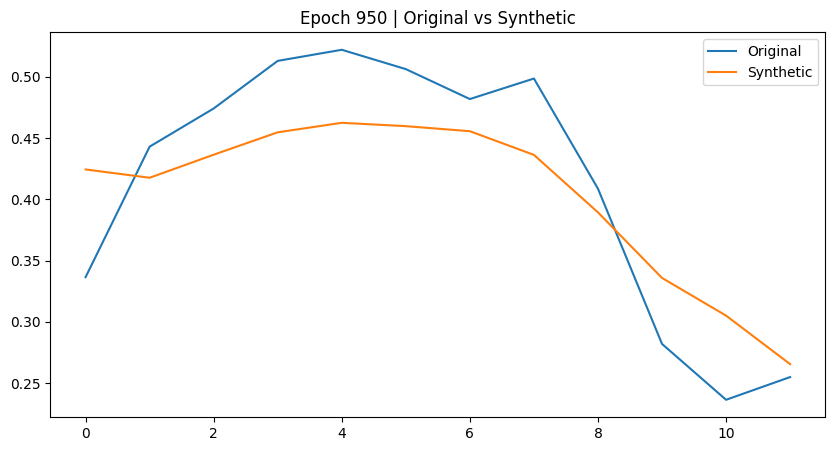

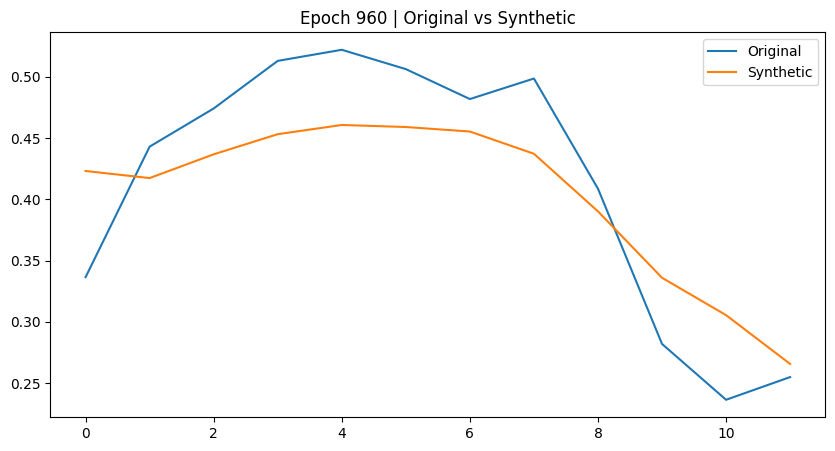

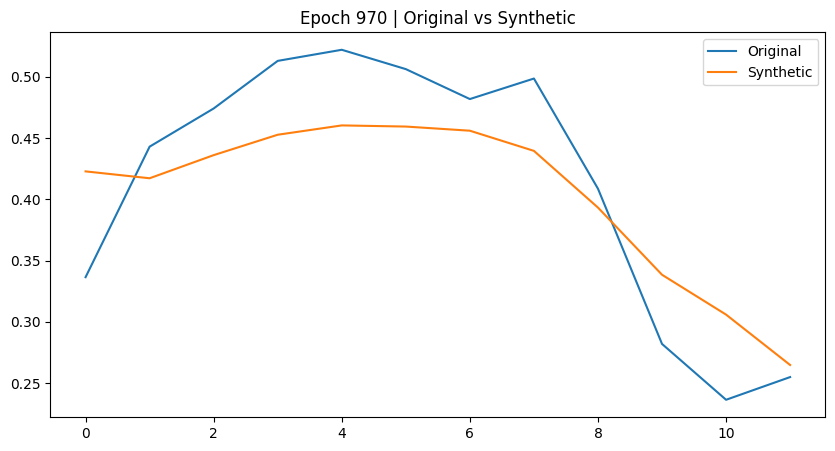

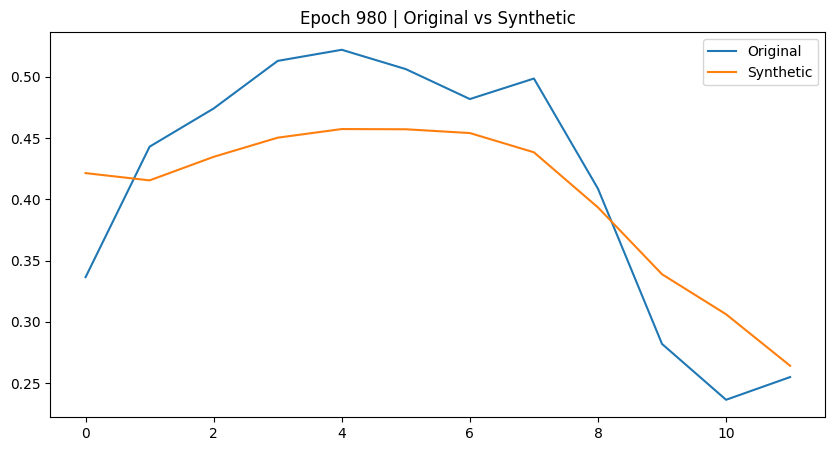

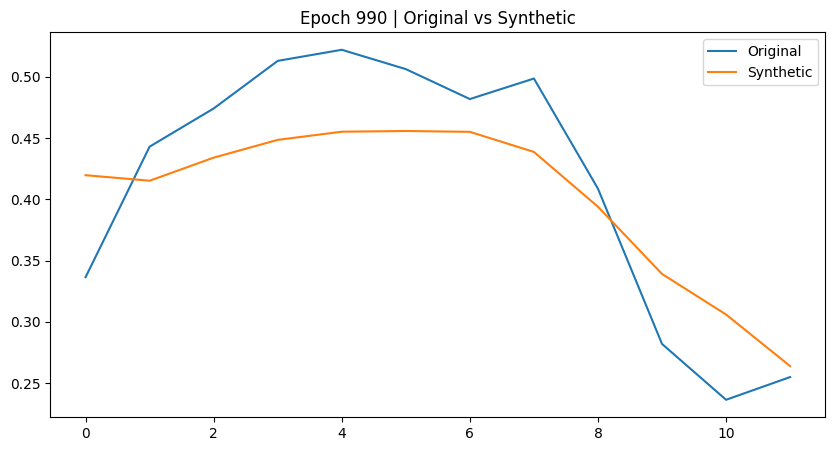

In [16]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"
else:
    model_path = f"{model_name}_checkpoint.pth"

    train_losses, val_losses = train_autoencoder(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_path
    )

## Evaluate Training

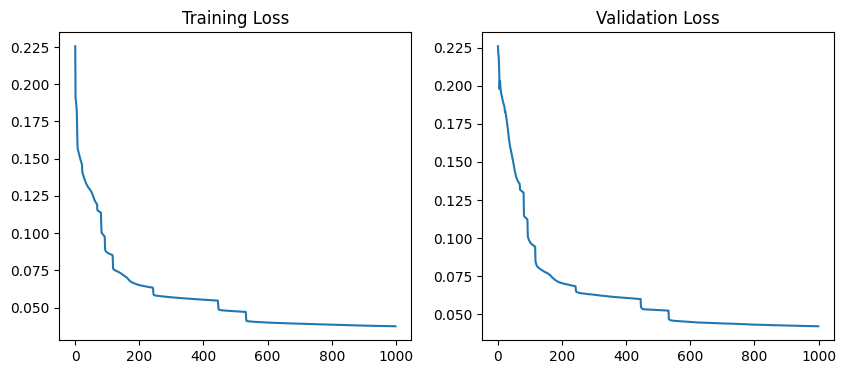

In [17]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [18]:
if not TEST_EXISTING_MODEL:
    smallest_val_loss = val_losses[-11]
    smallest_train_loss = train_losses[-11]
    print(f'Smallest Val Loss: {smallest_val_loss} | Smallest Train Loss: {smallest_train_loss}')

Smallest Val Loss: 0.042008799793763776 | Smallest Train Loss: 0.03743540136820178


## Testing Model

In [19]:
if model_name == "LSTM_AE":
    print("LSMT_AE")
    test_model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    print("FCAE")
    test_model = FCAE(verbose=True).to(hyperparameters['device'])

# load model state dict
test_model.load_state_dict(torch.load(model_path))

LSMT_AE


<All keys matched successfully>

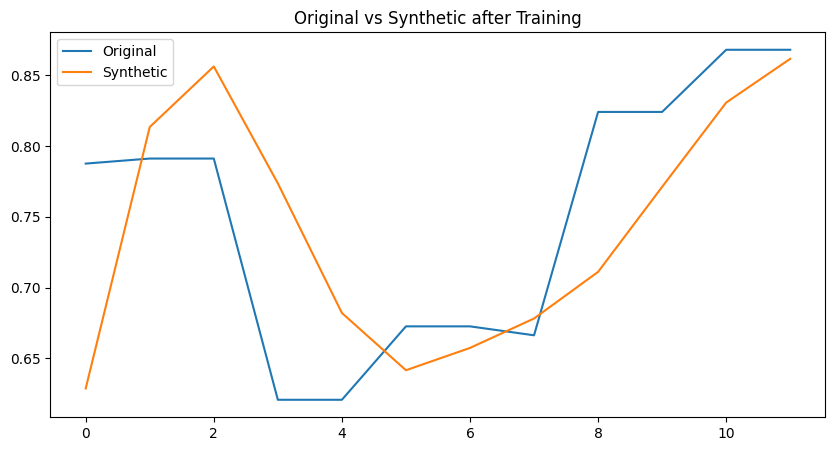

In [20]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [21]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [22]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([22797, 12, 5]),
 torch.Size([2840, 12, 5]),
 torch.Size([2841, 12, 5]))

In [23]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [24]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [25]:
result.shape

(28478, 12, 5)

In [26]:
result_unscaled = scaler.inverse_scale_complete_dataset(result, input_data_is_sequential=True)

In [27]:
no, seq, dim = result_unscaled.shape
data_to_save = result_unscaled.reshape(no, seq*dim)

In [28]:
np.savetxt(f'mitv_{no}_{seq}_{dim}_autoencoder_{model_name}_unscaled.csv', data_to_save, delimiter=',')

### Check on synthetic data

In [29]:
df = pd.DataFrame(result_unscaled.reshape(-1, dim))
df.describe()

0              1         2         3              4
count  341736.000000  341736.000000  341736.0  341736.0  341736.000000
mean     3246.958984     282.898468       0.0       0.0      41.946411
std      1898.209106      12.331297       0.0       0.0      39.537220
min         0.000000     245.715363       0.0       0.0       0.000000
25%      1342.486206     273.555267       0.0       0.0       0.000000
50%      3681.667603     284.773941       0.0       0.0      34.915749
75%      4856.334717     293.137657       0.0       0.0      88.441345
max      8375.253906     309.613892       0.0       0.0     123.771759

In [30]:
traffic_df.describe()

traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361      0.678185      0.008298     39.316195
min           0.00000    243.390000      0.000000      0.000000      0.000000
25%        1289.00000    273.480000      0.000000      0.000000      1.000000
50%        3507.00000    284.550000      0.000000      0.000000     40.000000
75%        4948.00000    292.790000      0.000000      0.000000     90.000000
max        7280.00000    310.070000     42.000000      0.510000    100.000000